## KGB Model LN Auto V2 - FICO < 660

In [1]:
!pip install xgboost


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [3]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import json
import logging
import xgboost as xgb
import ast
import itertools
import scipy.stats as ss
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import chi2
import os
import sys

pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)
pd.set_option('display.max_colwidth', None)

In [4]:
sys.path.append('/root/Unified_LN_V2/')
from Utilities import *

In [5]:
Train = pd.read_csv('/root/Unified_LN_V2/LN_Auto_V2/Data/2_LN_Auto_V2_Train_Funded_Data_250324.csv')
Test = pd.read_csv('/root/Unified_LN_V2/LN_Auto_V2/Data/2_LN_Auto_V2_Test_Funded_Data_250324.csv')
Oot= pd.read_csv('/root/Unified_LN_V2/LN_Auto_V2/Data/2_LN_Auto_V2_Oot_Funded_Data_250324.csv')
TTD= pd.read_csv('/root/Unified_LN_V2/LN_Auto_V2/Data/2_LN_Auto_V2_TTD_Data_250324.csv')
# TTD_Oot= pd.read_csv('/root/Unified_LN_V2/LN_Auto_V2/Data/1_LN_Auto_V2_OOT_Data_220324.csv')

Train.shape, Test.shape, Oot.shape, TTD.shape#, TTD_Oot.shape

((146855, 347), (62938, 347), (37121, 345), (700580, 345))

In [6]:
req_cols= ['assetpropevercount', 'sourcenonderogcount06month', 'addronfilecount', 'addrinputcountyratio', 'assetpropnewestsaleprice', 'addrcurrenttaxvalue', 'addrinputavmvalue', 'addrinputavmvalue60month', 'addrinputlastsaleprice', 'addrinputtaxmarketvalue', 'sourcecredheadertimeoldest', 'addrinputphonecount', 'assetpropcurrenttaxtotal', 'addrcurrentavmvalue', 'assetproppurchasetimeoldest', 'addrpreviouslengthofres', 'addrinputlengthofres', 'addrcurrenttaxmarketvalue', 'addrprevioustimenewest', 'addrcurrenttractratio', 'sourcenonderogcount12month', 'assetpropcurrentcount', 'addrinputsubjectcount', 'sourcenonderogcount', 'addrinputtaxvalue', 'assetpropeversoldcount', 'businessassociationtimeoldest', 'addrinputtractratio', 'derogtimenewest', 'addrchangecount24month', 'addrinputtimelastsale', 'educationinstitutionprivate', 'addrinputblockratio', 'businesstitleleadership', 'addrcurrentlengthofres', 'addrcurrentavmratio12monthprior', 'addrcurrentblockratio', 'derogcount', 'profliccount', 'addrinputavmratio60monthprior', 'addrcurrentcountyratio', 'assetpropsaletimeoldest', 'subjectrecordtimeoldest', 'addrcurrenttimenewest', 'proflictypecategory', 'criminalnonfelonytimenewest', 'lienjudgmentdollartotal', 'addrcurrentlastsalesprice', 'addrinputtimenewest', 'evictiontimenewest', 'bankruptcycount', 'addrcurrenttimelastsale', 'addrinputtimeoldest', 'addrlastmovetaxratiodiff', 'criminalnonfelonycount', 'sourcenonderogcount03month', 'addrchangecount03month', 'addrchangecount06month', 'addrchangecount12month', 'addrchangecount60month', 'addrcurrentavmratio60monthprior', 'addrcurrentavmvalue12month', 'addrcurrentavmvalue60month', 'addrcurrentcorrectional', 'addrcurrentdeedmailing', 'addrcurrentphoneservice', 'addrcurrentsubjectowned', 'addrcurrenttimeoldest', 'addrinputavmratio12monthprior', 'addrinputavmvalue12month', 'addrinputdeedmailing', 'addrinputphoneservice', 'addrinputproblems', 'addrinputsubjectowned', 'addrlastmoveecontrajectory', 'addronfilecollege', 'addronfilecorrectional', 'addronfilehighrisk', 'addrpreviouscorrectional', 'addrprevioussubjectowned', 'addrprevioustimeoldest', 'alertregulatorycondition', 'assetownership', 'assetpersonal', 'assetpersonalcount', 'assetprop', 'assetpropnewestmortgagetype', 'assetproppurchasecount12month', 'assetproppurchasetimenewest', 'assetpropsalepurchaseratio', 'assetpropsaletimenewest', 'assetpropsoldcount12month', 'bankruptcychapter', 'bankruptcycount24month', 'bankruptcydismissed24month', 'bankruptcystatus', 'bankruptcytimenewest', 'businessassociation', 'criminalfelonycount', 'criminalfelonycount12month', 'criminalfelonytimenewest', 'criminalnonfelonycount12month', 'derogcount12month', 'educationattendance', 'educationevidence', 'educationinstitutionrating', 'educationprogramattended', 'evictioncount', 'evictioncount12month', 'inquiryauto12month', 'inquirybanking12month', 'inquirycollections12month', 'inquirynonshortterm12month', 'inquiryshortterm12month', 'inquirytelcom12month', 'lienjudgmentcount', 'lienjudgmentcount12month', 'lienjudgmentcourtcount', 'lienjudgmentforeclosurecount', 'lienjudgmentothercount', 'lienjudgmentsmallclaimscount', 'lienjudgmenttaxcount', 'lienjudgmenttimenewest', 'shorttermloanrequest', 'shorttermloanrequest12month', 'shorttermloanrequest24month', 'sourcecredheadertimenewest', 'sourcevoterregistration', 'subjectnewestrecord12month', 'subjectrecordtimenewest']
len(req_cols)

130

In [7]:
all_cols= ['unique_id', 'client', 'app_date', 'approve_flag', 'funded_flag', 'fico_pb', 'fico_cb', 'bad_flag', 'product', 'auto_score', 'bankcard_score', 'Race', 'Gender', 'age_cuts'] + req_cols
len(all_cols)

144

In [8]:
print({'Length': Train['funded_flag'].sum(), 'Bads': Train['bad_flag'].sum()})
print({'Length': Test['funded_flag'].sum(), 'Bads': Test['bad_flag'].sum()})
print({'Length': Oot['funded_flag'].sum(), 'Bads': Oot['bad_flag'].sum()})

{'Length': 146855.0, 'Bads': 2227.0}
{'Length': 62938.0, 'Bads': 959.0}
{'Length': 37121.0, 'Bads': 545.0}


In [9]:
Train.shape, Test.shape, Oot.shape

((146855, 347), (62938, 347), (37121, 345))

In [10]:
print(TTD.shape)
TTD= TTD[TTD['client']!= 'CPM'].reset_index(drop= True)
print(TTD.shape)
# TTD_Oot= TTD_Oot[TTD_Oot['client']!= 'CPM'].reset_index(drop= True)

(700580, 345)
(685215, 345)


In [11]:
Train= Train[all_cols + ['weight']]
Test= Test[all_cols + ['weight']]
Oot= Oot[all_cols]
TTD= TTD[all_cols]
# TTD_Oot= TTD_Oot[all_cols]

Train.shape, Test.shape, Oot.shape, TTD.shape#, TTD_Oot.shape

((146855, 145), (62938, 145), (37121, 144), (685215, 144))

In [12]:
Train.rename(columns= {'weight': 'wt2'}, inplace= True)
Test.rename(columns= {'weight': 'wt2'}, inplace= True)

In [13]:
Train= Train[~(Train['fico_pb']>=660)].reset_index(drop= True)
print(Train.shape, Train['fico_pb'].agg(['min', 'max']))

Test= Test[~(Test['fico_pb']>=660)].reset_index(drop= True)
print(Test.shape, Test['fico_pb'].agg(['min', 'max']))

Oot= Oot[~(Oot['fico_pb']>=660)].reset_index(drop= True)
print(Oot.shape, Oot['fico_pb'].agg(['min', 'max']))

TTD= TTD[~(TTD['fico_pb']>=660)].reset_index(drop= True)
print(TTD.shape, TTD['fico_pb'].agg(['min', 'max']))

(26137, 145) min      0.0
max    659.0
Name: fico_pb, dtype: float64
(11350, 145) min      0.0
max    659.0
Name: fico_pb, dtype: float64
(6668, 144) min      0.0
max    659.0
Name: fico_pb, dtype: float64
(259792, 144) min      0.0
max    659.0
Name: fico_pb, dtype: float64


In [14]:
Train['bad_flag'].mean(), Test['bad_flag'].mean(), Oot['bad_flag'].mean()

(0.05115353713126985, 0.0494273127753304, 0.047240551889622076)

In [15]:
TTD['funded_flag'].sum(), len(Train), len(Test)

(35158.0, 26137, 11350)

In [16]:
TTD_lt_660= pd.concat([Train, Test]).reset_index(drop= True)
TTD_lt_660.shape

(37487, 145)

In [17]:
TTD_lt_660['client'].value_counts(dropna= False)

client
Guardian    9860
Numerica    5257
GESA        5154
SECU        4357
Tower       4230
Arkansas    4097
CPM         2329
Bethpage     952
HFCU         570
NCU          350
Hawaii       331
Name: count, dtype: int64

In [18]:
TTD_lt_660['bad_flag'].mean()

0.05063088537359618

In [19]:
# !mkdir /root/Unified_LN_V2/LN_Auto_V2/Model_Data/Auto_FICO_lt_660_Model
# !mkdir /root/Unified_LN_V2/LN_Auto_V2/Model_Data/Auto_FICO_lt_660_Model/Mono_Data
# !mkdir /root/Unified_LN_V2/LN_Auto_V2/Model_Data/Auto_FICO_lt_660_Model/Data

In [20]:
path_mono= '/root/Unified_LN_V2/LN_Auto_V2/Model_Data/Auto_FICO_lt_660_Model/Mono_Data/'
path_data= '/root/Unified_LN_V2/LN_Auto_V2/Model_Data/Auto_FICO_lt_660_Model/Data/'
path_model= '/root/Unified_LN_V2/LN_Auto_V2/Model_Data/Auto_FICO_lt_660_Model/'

In [21]:
del Train, Test

In [24]:
## Splitting the data into train and test
from sklearn.model_selection import train_test_split
diff= 100
for i in np.random.randint(100, 10000, 50):
    Train, Test= train_test_split(TTD_lt_660, test_size= 0.3, random_state= i)
    if np.abs(Train['bad_flag'].mean() - Test['bad_flag'].mean())< diff:
        diff= np.abs(Train['bad_flag'].mean() - Test['bad_flag'].mean())
        print(i, Train.shape, Test.shape)
        print(Train['bad_flag'].mean(), Test['bad_flag'].mean())
        print(sum(Train['bad_flag']*Train['wt2'])/Train['wt2'].sum(), sum(Test['bad_flag']*Test['wt2'])/Test['wt2'].sum())
    else:
        pass

4628 (26240, 145) (11247, 145)
0.05076219512195122 0.05032453098604072
0.05975874552349814 0.059406818424708616
1261 (26240, 145) (11247, 145)
0.05053353658536586 0.05085800657953232
0.059500714683301724 0.06000906516264512
4023 (26240, 145) (11247, 145)
0.05064786585365854 0.05059126878278652
0.060365178415629536 0.057980667334976886


In [26]:
## Splitting the data into train and test
from sklearn.model_selection import train_test_split
Train, Test= train_test_split(TTD_lt_660, test_size= 0.3, random_state= 4628)
print(Train.shape, Test.shape)
print(Train['bad_flag'].mean(), Test['bad_flag'].mean())
print(sum(Train['bad_flag']*Train['wt2'])/Train['wt2'].sum(), sum(Test['bad_flag']*Test['wt2'])/Test['wt2'].sum())

(26240, 145) (11247, 145)
0.05076219512195122 0.05032453098604072
0.05975874552349814 0.059406818424708616


In [27]:
pref= 'FICO_lt_660'
Train.to_csv(f'{path_data}{pref}_Auto_train_raw_data_280324.csv', index= False)
Test.to_csv(f'{path_data}{pref}_Auto_test_raw_data_280324.csv', index= False)
Oot.to_csv(f'{path_data}{pref}_Auto_oot_raw_data_280324.csv', index= False)
TTD.to_csv(f'{path_data}{pref}_Auto_ttd_raw_data_280324.csv', index= False)

In [28]:
TTD_lt_660['fico_pb'].isnull().sum()

270

In [29]:
TTD_lt_660.groupby(['client']).agg(
    funded= ('funded_flag', 'sum'),
    bad= ('bad_flag', 'sum'),
    bad_rate= ('bad_flag', 'mean')
)

,funded,bad,bad_rate
client,,,
Arkansas,4097.0,95.0,0.023188
Bethpage,952.0,18.0,0.018908
CPM,2329.0,91.0,0.039073
GESA,5154.0,389.0,0.075475
Guardian,9860.0,323.0,0.032759
HFCU,570.0,36.0,0.063158
Hawaii,331.0,2.0,0.006042
NCU,350.0,12.0,0.034286
Numerica,5257.0,247.0,0.046985


In [30]:
del TTD_lt_660

In [31]:
Train['bad_flag'].mean(), Test['bad_flag'].mean(), Oot['bad_flag'].mean()

(0.05076219512195122, 0.05032453098604072, 0.047240551889622076)

In [32]:
Train.shape, Train['funded_flag'].sum(), Test.shape, Test['funded_flag'].sum(), Oot.shape, Oot['funded_flag'].sum()

((26240, 145), 26240.0, (11247, 145), 11247.0, (6668, 144), 6668.0)

In [33]:
### Convert the Variable into categorical
var_to_cat= '''businesstitleleadership
proflictypecategory
addrcurrentdeedmailing
addrcurrentphoneservice
addrcurrentsubjectowned
addrinputdeedmailing
addrinputphoneservice
addrinputproblems
addrinputsubjectowned
addrlastmoveecontrajectory
addronfilecollege
addronfilecorrectional
addronfilehighrisk
addrprevioussubjectowned
alertregulatorycondition
assetownership
assetpersonal
assetprop
assetpropnewestmortgagetype
bankruptcychapter
bankruptcystatus
businessassociation
educationattendance
educationevidence
educationinstitutionrating
educationprogramattended
inquiryauto12month
inquirybanking12month
inquirycollections12month
inquirynonshortterm12month
inquiryshortterm12month
inquirytelcom12month
shorttermloanrequest
shorttermloanrequest12month
shorttermloanrequest24month
subjectnewestrecord12month
sourcevoterregistration'''.splitlines()
len(var_to_cat)

37

In [34]:
for var in var_to_cat:
    Train[var]= [f"[{i}]" if i!= '[-1]' else i for i in Train[var].astype(int).astype(str)]
    Test[var]= [f"[{i}]" if i!= '[-1]' else i for i in Test[var].astype(int).astype(str)]
    Oot[var]= [f"[{i}]" if i!= '[-1]' else i for i in Oot[var].astype(int).astype(str)]
    TTD[var]= [f"[{i}]" if i!= '[-1]' else i for i in TTD[var].astype(int).astype(str)]

In [35]:
print(Train['bankruptcystatus'].value_counts(dropna= False))
print(Test['bankruptcystatus'].value_counts(dropna= False))
print(Oot['bankruptcystatus'].value_counts(dropna= False))
print(TTD['bankruptcystatus'].value_counts(dropna= False))

bankruptcystatus
[0]     24197
[1]      1822
[2]       202
[-1]       19
Name: count, dtype: int64
bankruptcystatus
[0]     10371
[1]       776
[2]        90
[-1]       10
Name: count, dtype: int64
bankruptcystatus
[0]     6152
[1]      472
[2]       42
[-1]       2
Name: count, dtype: int64
bankruptcystatus
[0]     236029
[1]      20812
[2]       2602
[-1]       349
Name: count, dtype: int64


#### Monotonic Binning

In [36]:
import pickle

configFile= Train[req_cols].dtypes.reset_index()
configFile.columns= ['Feature_Name', 'dtypes']
configFile['Special_values']= '[[-1]]'
# configFile['Monotonicity']= 'Y'
configFile['Monotonicity']= np.where(~configFile['Feature_Name'].isin(var_to_cat), 'Y', 'N')
del configFile['dtypes']
configFile.head()

,Feature_Name,Special_values,Monotonicity
0,assetpropevercount,[[-1]],Y
1,sourcenonderogcount06month,[[-1]],Y
2,addronfilecount,[[-1]],Y
3,addrinputcountyratio,[[-1]],Y
4,assetpropnewestsaleprice,[[-1]],Y


In [37]:
with open(f'{path_mono}configFile.pickle', 'wb') as f:
    pickle.dump(configFile, f)

In [38]:
dep_var = "bad_flag"
weight_column = 'wt2'
min_bin_size = 0.1
index_col=[]

In [39]:
# Get feature meta
# special_values = pd.read_csv(config_file)
import ast
special_values= configFile.copy()
# Converting the string entered in CSV to list of lists
special_values['Special_values'] = special_values['Special_values'].apply(lambda x: ast.literal_eval(str(x)))
# Generate feature meta
feature_meta = GenMeta(Train, index_col, sample_size=50000)
feature_meta = pd.merge(feature_meta, special_values, on="Feature_Name", how="left").replace(np.nan, '')
feature_meta.index = feature_meta['Feature_Name']
feature_meta.head()

,Feature_Name,Datatype,Special_values,Monotonicity
Feature_Name,,,,
unique_id,unique_id,string,,
client,client,string,,
app_date,app_date,string,,
approve_flag,approve_flag,float,,
funded_flag,funded_flag,float,,


In [40]:
with open(f'{path_mono}feature_meta.pickle', 'wb') as f:
    pickle.dump(feature_meta, f)

In [41]:
# Get numeric and embedding dataframe
embed_df, numeric_df = embedding_numeric_df(feature_meta, dep_var, index_col)

# Removing weight_column and columns that are not mentioned in the config file
embed_df.loc[np.invert(embed_df['Feature_Name'].isin(special_values['Feature_Name'].tolist())), 'Use_Feature'] = 'N'
numeric_df.loc[
        np.invert(numeric_df['Feature_Name'].isin(special_values['Feature_Name'].tolist())), 'Use_Feature'] = 'N'

if weight_column is not None:
    numeric_df.loc[numeric_df['Feature_Name'] == weight_column, 'Use_Feature'] = 'N'
    
display(numeric_df.head())
display(embed_df.head())

,Feature_Name,Use_Feature,Bucket_Size
Feature_Name,,,
approve_flag,approve_flag,N,10
funded_flag,funded_flag,N,10
fico_pb,fico_pb,N,10
fico_cb,fico_cb,N,10
bad_flag,bad_flag,N,10


,Feature_Name,Use_Feature,Num_Hash_Buckets,Num_Embedding_Columns
Feature_Name,,,,
unique_id,unique_id,N,10,2
client,client,N,10,2
app_date,app_date,N,10,2
product,product,N,10,2
Race,Race,N,10,2


In [42]:
with open(f'{path_mono}embed_df.pickle', 'wb') as f:
    pickle.dump(embed_df, f)

with open(f'{path_mono}numeric_df.pickle', 'wb') as f:
    pickle.dump(numeric_df, f)

In [43]:
# Get feature boundaries
feature_boundaries, numeric_df = get_boundaries_cart(filename=Train, sample_size=5000, shuffle_ind=False,
                                                         batch_size=100000,
                                                         shuffle_size=50000, feature_meta=feature_meta,
                                                         numeric_df=numeric_df,
                                                         dep_var=dep_var,
                                                         weight_column=weight_column, min_bin_size=float(min_bin_size))

assetpropevercount
0.0
assetpropevercount : [-inf, 1.0, 2.0, inf]
sourcenonderogcount06month
0.0
sourcenonderogcount06month : [-inf, 2.0, inf]
addronfilecount
0.0
addronfilecount : [-inf, 2.0, 4.0, 6.0, inf]
addrinputcountyratio
0.0
addrinputcountyratio : [-inf, 0.379999995, 0.850000024, 1.04999995, inf]
assetpropnewestsaleprice
1.0
assetpropnewestsaleprice : [-inf, 50980.0, 203500.0, inf]
addrcurrenttaxvalue
0.0
addrcurrenttaxvalue : [-inf, 365.0, inf]
addrinputavmvalue
2403.0
addrinputavmvalue : [-inf, 100713.0, 134700.0, inf]
addrinputavmvalue60month
4147.0
addrinputavmvalue60month : [-inf, 62887.0, 104609.0, inf]
addrinputlastsaleprice
1.0
addrinputlastsaleprice : [-inf, 33000.0, 150180.0, 179900.0, 231000.0, inf]
addrinputtaxmarketvalue
0.0
addrinputtaxmarketvalue : [-inf, 3000.0, inf]
sourcecredheadertimeoldest
1.0
sourcecredheadertimeoldest : [-inf, 64.0, 114.0, 189.0, 250.0, 337.0, 404.0, inf]
addrinputphonecount
0.0
addrinputphonecount : [-inf, 1.0, inf]
assetpropcurrenttaxtot

In [44]:
with open(f'{path_mono}feature_boundaries.pickle', 'wb') as f:
    pickle.dump(feature_boundaries, f)

In [45]:
# Get train bivar tables + get binned train dataframe
bivar_tables, rep_values, binned_df = get_bivar_tables(filename=Train, predicted=None,
                                                           feature_meta=feature_meta,
                                                           feature_boundaries=feature_boundaries,
                                                           num_features=numeric_df.loc[numeric_df['Use_Feature'] == 'Y', 'Feature_Name'].tolist(),
                                                           embed_features=embed_df.loc[embed_df['Use_Feature'] == 'Y', 'Feature_Name'].tolist(),
                                                           dep_var=dep_var, weight_column=None)

assetpropevercount
sourcenonderogcount06month
addronfilecount
addrinputcountyratio
assetpropnewestsaleprice
addrcurrenttaxvalue
addrinputavmvalue
addrinputavmvalue60month
addrinputlastsaleprice
addrinputtaxmarketvalue
sourcecredheadertimeoldest
addrinputphonecount
assetpropcurrenttaxtotal
addrcurrentavmvalue
assetproppurchasetimeoldest
addrpreviouslengthofres
addrinputlengthofres
addrcurrenttaxmarketvalue
addrprevioustimenewest
addrcurrenttractratio
sourcenonderogcount12month
assetpropcurrentcount
addrinputsubjectcount
sourcenonderogcount
addrinputtaxvalue
assetpropeversoldcount
businessassociationtimeoldest
addrinputtractratio
derogtimenewest
addrchangecount24month
addrinputtimelastsale
educationinstitutionprivate
addrinputblockratio
addrcurrentlengthofres
addrcurrentavmratio12monthprior
addrcurrentblockratio
derogcount
profliccount
addrinputavmratio60monthprior
addrcurrentcountyratio
assetpropsaletimeoldest
subjectrecordtimeoldest
addrcurrenttimenewest
criminalnonfelonytimenewest
lie

In [46]:
# Get train bivar tables + get binned train dataframe
bivar_tables_holdout, rep_values_holdout, binned_df_holdout = get_bivar_tables(filename=Test, predicted=None,
                                                           feature_meta=feature_meta,
                                                           feature_boundaries=feature_boundaries,
                                                           num_features=numeric_df.loc[numeric_df['Use_Feature'] == 'Y', 'Feature_Name'].tolist(),
                                                           embed_features=embed_df.loc[embed_df['Use_Feature'] == 'Y', 'Feature_Name'].tolist(),
                                                           dep_var=dep_var, weight_column=None)

assetpropevercount
sourcenonderogcount06month
addronfilecount
addrinputcountyratio
assetpropnewestsaleprice
addrcurrenttaxvalue
addrinputavmvalue
addrinputavmvalue60month
addrinputlastsaleprice
addrinputtaxmarketvalue
sourcecredheadertimeoldest
addrinputphonecount
assetpropcurrenttaxtotal
addrcurrentavmvalue
assetproppurchasetimeoldest
addrpreviouslengthofres
addrinputlengthofres
addrcurrenttaxmarketvalue
addrprevioustimenewest
addrcurrenttractratio
sourcenonderogcount12month
assetpropcurrentcount
addrinputsubjectcount
sourcenonderogcount
addrinputtaxvalue
assetpropeversoldcount
businessassociationtimeoldest
addrinputtractratio
derogtimenewest
addrchangecount24month
addrinputtimelastsale
educationinstitutionprivate
addrinputblockratio
addrcurrentlengthofres
addrcurrentavmratio12monthprior
addrcurrentblockratio
derogcount
profliccount
addrinputavmratio60monthprior
addrcurrentcountyratio
assetpropsaletimeoldest
subjectrecordtimeoldest
addrcurrenttimenewest
criminalnonfelonytimenewest
lie

In [47]:
# Get train bivar tables + get binned train dataframe
binned_df_oot = get_bivar_tables_test(filename=Oot, predicted=None,
                                   feature_meta=feature_meta,
                                   feature_boundaries=feature_boundaries,
                                   num_features=numeric_df.loc[numeric_df['Use_Feature'] == 'Y', 'Feature_Name'].tolist(),
                                   embed_features=embed_df.loc[embed_df['Use_Feature'] == 'Y', 'Feature_Name'].tolist(),
                                   dep_var=None, weight_column= None)

assetpropevercount
sourcenonderogcount06month
addronfilecount
addrinputcountyratio
assetpropnewestsaleprice
addrcurrenttaxvalue
addrinputavmvalue
addrinputavmvalue60month
addrinputlastsaleprice
addrinputtaxmarketvalue
sourcecredheadertimeoldest
addrinputphonecount
assetpropcurrenttaxtotal
addrcurrentavmvalue
assetproppurchasetimeoldest
addrpreviouslengthofres
addrinputlengthofres
addrcurrenttaxmarketvalue
addrprevioustimenewest
addrcurrenttractratio
sourcenonderogcount12month
assetpropcurrentcount
addrinputsubjectcount
sourcenonderogcount
addrinputtaxvalue
assetpropeversoldcount
businessassociationtimeoldest
addrinputtractratio
derogtimenewest
addrchangecount24month
addrinputtimelastsale
educationinstitutionprivate
addrinputblockratio
addrcurrentlengthofres
addrcurrentavmratio12monthprior
addrcurrentblockratio
derogcount
profliccount
addrinputavmratio60monthprior
addrcurrentcountyratio
assetpropsaletimeoldest
subjectrecordtimeoldest
addrcurrenttimenewest
criminalnonfelonytimenewest
lie

In [48]:
# Get train bivar tables + get binned train dataframe
binned_df_ttd = get_bivar_tables_test(filename=TTD, predicted=None,
                                   feature_meta=feature_meta,
                                   feature_boundaries=feature_boundaries,
                                   num_features=numeric_df.loc[numeric_df['Use_Feature'] == 'Y', 'Feature_Name'].tolist(),
                                   embed_features=embed_df.loc[embed_df['Use_Feature'] == 'Y', 'Feature_Name'].tolist(),
                                   dep_var=None, weight_column= None)

assetpropevercount
sourcenonderogcount06month
addronfilecount
addrinputcountyratio
assetpropnewestsaleprice
addrcurrenttaxvalue
addrinputavmvalue
addrinputavmvalue60month
addrinputlastsaleprice
addrinputtaxmarketvalue
sourcecredheadertimeoldest
addrinputphonecount
assetpropcurrenttaxtotal
addrcurrentavmvalue
assetproppurchasetimeoldest
addrpreviouslengthofres
addrinputlengthofres
addrcurrenttaxmarketvalue
addrprevioustimenewest
addrcurrenttractratio
sourcenonderogcount12month
assetpropcurrentcount
addrinputsubjectcount
sourcenonderogcount
addrinputtaxvalue
assetpropeversoldcount
businessassociationtimeoldest
addrinputtractratio
derogtimenewest
addrchangecount24month
addrinputtimelastsale
educationinstitutionprivate
addrinputblockratio
addrcurrentlengthofres
addrcurrentavmratio12monthprior
addrcurrentblockratio
derogcount
profliccount
addrinputavmratio60monthprior
addrcurrentcountyratio
assetpropsaletimeoldest
subjectrecordtimeoldest
addrcurrenttimenewest
criminalnonfelonytimenewest
lie

In [49]:
print(binned_df.shape, Train.shape)
print(binned_df_holdout.shape, Test.shape)
print(binned_df_oot.shape, Oot.shape)
print(binned_df_ttd.shape, TTD.shape)

(26240, 145) (26240, 145)
(11247, 145) (11247, 145)
(6668, 144) (6668, 144)
(259792, 144) (259792, 144)


In [50]:
binned_df.to_csv(f'{path_mono}{pref}_1_Auto_Train_Binned_Data_280324.csv', index= False)
binned_df_holdout.to_csv(f'{path_mono}{pref}_1_Auto_Test_Binned_Data_280324.csv', index= False)
binned_df_oot.to_csv(f'{path_mono}{pref}_1_Auto_Oot_Binned_Data_280324.csv', index= False)
binned_df_ttd.to_csv(f'{path_mono}{pref}_1_Auto_Ttd_Binned_Data_280324.csv', index= False)

In [51]:
del Train, Test, Oot, TTD, binned_df, binned_df_holdout, binned_df_oot, binned_df_ttd

#### Reading Data For Model Building

In [5]:
import gc
gc.collect()

0

In [6]:
pref= 'FICO_lt_660'
path_mono= '/root/Unified_LN_V2/LN_Auto_V2/Model_Data/Auto_FICO_lt_660_Model/Mono_Data/'
path_data= '/root/Unified_LN_V2/LN_Auto_V2/Model_Data/Auto_FICO_lt_660_Model/Data/'
path_model= '/root/Unified_LN_V2/LN_Auto_V2/Model_Data/Auto_FICO_lt_660_Model/'

In [7]:
Train = pd.read_csv(f'{path_mono}{pref}_1_Auto_Train_Binned_Data_280324.csv')
Test = pd.read_csv(f'{path_mono}{pref}_1_Auto_Test_Binned_Data_280324.csv')
Oot= pd.read_csv(f'{path_mono}{pref}_1_Auto_Oot_Binned_Data_280324.csv')
TTD= pd.read_csv(f'{path_mono}{pref}_1_Auto_Ttd_Binned_Data_280324.csv')
# TTD_Oot= pd.read_csv('/root/Unified_LN_V2/LN_Auto_V2/Data/1_LN_Auto_V2_OOT_Data_220324.csv')

Train.shape, Test.shape, Oot.shape, TTD.shape#, TTD_Oot.shape

((26240, 145), (11247, 145), (6668, 144), (259792, 144))

In [8]:
req_cols= ['assetpropevercount', 'sourcenonderogcount06month', 'addronfilecount', 'addrinputcountyratio', 'assetpropnewestsaleprice', 'addrcurrenttaxvalue', 'addrinputavmvalue', 'addrinputavmvalue60month', 'addrinputlastsaleprice', 'addrinputtaxmarketvalue', 'sourcecredheadertimeoldest', 'addrinputphonecount', 'assetpropcurrenttaxtotal', 'addrcurrentavmvalue', 'assetproppurchasetimeoldest', 'addrpreviouslengthofres', 'addrinputlengthofres', 'addrcurrenttaxmarketvalue', 'addrprevioustimenewest', 'addrcurrenttractratio', 'sourcenonderogcount12month', 'assetpropcurrentcount', 'addrinputsubjectcount', 'sourcenonderogcount', 'addrinputtaxvalue', 'assetpropeversoldcount', 'businessassociationtimeoldest', 'addrinputtractratio', 'derogtimenewest', 'addrchangecount24month', 'addrinputtimelastsale', 'educationinstitutionprivate', 'addrinputblockratio', 'businesstitleleadership', 'addrcurrentlengthofres', 'addrcurrentavmratio12monthprior', 'addrcurrentblockratio', 'derogcount', 'profliccount', 'addrinputavmratio60monthprior', 'addrcurrentcountyratio', 'assetpropsaletimeoldest', 'subjectrecordtimeoldest', 'addrcurrenttimenewest', 'proflictypecategory', 'criminalnonfelonytimenewest', 'lienjudgmentdollartotal', 'addrcurrentlastsalesprice', 'addrinputtimenewest', 'evictiontimenewest', 'bankruptcycount', 'addrcurrenttimelastsale', 'addrinputtimeoldest', 'addrlastmovetaxratiodiff', 'criminalnonfelonycount', 'sourcenonderogcount03month', 'addrchangecount03month', 'addrchangecount06month', 'addrchangecount12month', 'addrchangecount60month', 'addrcurrentavmratio60monthprior', 'addrcurrentavmvalue12month', 'addrcurrentavmvalue60month', 'addrcurrentcorrectional', 'addrcurrentdeedmailing', 'addrcurrentphoneservice', 'addrcurrentsubjectowned', 'addrcurrenttimeoldest', 'addrinputavmratio12monthprior', 'addrinputavmvalue12month', 'addrinputdeedmailing', 'addrinputphoneservice', 'addrinputproblems', 'addrinputsubjectowned', 'addrlastmoveecontrajectory', 'addronfilecollege', 'addronfilecorrectional', 'addronfilehighrisk', 'addrpreviouscorrectional', 'addrprevioussubjectowned', 'addrprevioustimeoldest', 'alertregulatorycondition', 'assetownership', 'assetpersonal', 'assetpersonalcount', 'assetprop', 'assetpropnewestmortgagetype', 'assetproppurchasecount12month', 'assetproppurchasetimenewest', 'assetpropsalepurchaseratio', 'assetpropsaletimenewest', 'assetpropsoldcount12month', 'bankruptcychapter', 'bankruptcycount24month', 'bankruptcydismissed24month', 'bankruptcystatus', 'bankruptcytimenewest', 'businessassociation', 'criminalfelonycount', 'criminalfelonycount12month', 'criminalfelonytimenewest', 'criminalnonfelonycount12month', 'derogcount12month', 'educationattendance', 'educationevidence', 'educationinstitutionrating', 'educationprogramattended', 'evictioncount', 'evictioncount12month', 'inquiryauto12month', 'inquirybanking12month', 'inquirycollections12month', 'inquirynonshortterm12month', 'inquiryshortterm12month', 'inquirytelcom12month', 'lienjudgmentcount', 'lienjudgmentcount12month', 'lienjudgmentcourtcount', 'lienjudgmentforeclosurecount', 'lienjudgmentothercount', 'lienjudgmentsmallclaimscount', 'lienjudgmenttaxcount', 'lienjudgmenttimenewest', 'shorttermloanrequest', 'shorttermloanrequest12month', 'shorttermloanrequest24month', 'sourcecredheadertimenewest', 'sourcevoterregistration', 'subjectnewestrecord12month', 'subjectrecordtimenewest']
len(req_cols)

130

In [9]:
all_cols= ['unique_id', 'client', 'app_date', 'approve_flag', 'funded_flag', 'fico_pb', 'fico_cb', 'bad_flag', 'product', 'auto_score', 'bankcard_score', 'Race', 'Gender', 'age_cuts'] + req_cols
len(all_cols)

144

In [10]:
Train[all_cols].head(2)

,unique_id,client,app_date,approve_flag,funded_flag,fico_pb,fico_cb,bad_flag,product,auto_score,bankcard_score,Race,Gender,age_cuts,assetpropevercount,sourcenonderogcount06month,addronfilecount,addrinputcountyratio,assetpropnewestsaleprice,addrcurrenttaxvalue,addrinputavmvalue,addrinputavmvalue60month,addrinputlastsaleprice,addrinputtaxmarketvalue,sourcecredheadertimeoldest,addrinputphonecount,assetpropcurrenttaxtotal,addrcurrentavmvalue,assetproppurchasetimeoldest,addrpreviouslengthofres,addrinputlengthofres,addrcurrenttaxmarketvalue,addrprevioustimenewest,addrcurrenttractratio,sourcenonderogcount12month,assetpropcurrentcount,addrinputsubjectcount,sourcenonderogcount,addrinputtaxvalue,assetpropeversoldcount,businessassociationtimeoldest,addrinputtractratio,derogtimenewest,addrchangecount24month,addrinputtimelastsale,educationinstitutionprivate,addrinputblockratio,businesstitleleadership,addrcurrentlengthofres,addrcurrentavmratio12monthprior,addrcurrentblockratio,derogcount,profliccount,addrinputavmratio60monthprior,addrcurrentcountyratio,assetpropsaletimeoldest,subjectrecordtimeoldest,addrcurrenttimenewest,proflictypecategory,criminalnonfelonytimenewest,lienjudgmentdollartotal,addrcurrentlastsalesprice,addrinputtimenewest,evictiontimenewest,bankruptcycount,addrcurrenttimelastsale,addrinputtimeoldest,addrlastmovetaxratiodiff,criminalnonfelonycount,sourcenonderogcount03month,addrchangecount03month,addrchangecount06month,addrchangecount12month,addrchangecount60month,addrcurrentavmratio60monthprior,addrcurrentavmvalue12month,addrcurrentavmvalue60month,addrcurrentcorrectional,addrcurrentdeedmailing,addrcurrentphoneservice,addrcurrentsubjectowned,addrcurrenttimeoldest,addrinputavmratio12monthprior,addrinputavmvalue12month,addrinputdeedmailing,addrinputphoneservice,addrinputproblems,addrinputsubjectowned,addrlastmoveecontrajectory,addronfilecollege,addronfilecorrectional,addronfilehighrisk,addrpreviouscorrectional,addrprevioussubjectowned,addrprevioustimeoldest,alertregulatorycondition,assetownership,assetpersonal,assetpersonalcount,assetprop,assetpropnewestmortgagetype,assetproppurchasecount12month,assetproppurchasetimenewest,assetpropsalepurchaseratio,assetpropsaletimenewest,assetpropsoldcount12month,bankruptcychapter,bankruptcycount24month,bankruptcydismissed24month,bankruptcystatus,bankruptcytimenewest,businessassociation,criminalfelonycount,criminalfelonycount12month,criminalfelonytimenewest,criminalnonfelonycount12month,derogcount12month,educationattendance,educationevidence,educationinstitutionrating,educationprogramattended,evictioncount,evictioncount12month,inquiryauto12month,inquirybanking12month,inquirycollections12month,inquirynonshortterm12month,inquiryshortterm12month,inquirytelcom12month,lienjudgmentcount,lienjudgmentcount12month,lienjudgmentcourtcount,lienjudgmentforeclosurecount,lienjudgmentothercount,lienjudgmentsmallclaimscount,lienjudgmenttaxcount,lienjudgmenttimenewest,shorttermloanrequest,shorttermloanrequest12month,shorttermloanrequest24month,sourcecredheadertimenewest,sourcevoterregistration,subjectnewestrecord12month,subjectrecordtimenewest
0,2018-09-26 11:19|537-88-4113,GESA,2018-09-26,1.0,1.0,0.0,NaN,0.0,Auto,655.0,744.0,hispanic,F,Age below 62,"[-inf, 1.0)","[-inf, 2.0)","[-inf, 2.0)","[-inf, 0.38)",[-1],"[-inf, 365.0)",[-1],[-1],[-1],"[-inf, 3000.0)","[-inf, 64.0)","[-inf, 1.0)",[-1],"[90180.0, inf)",[-1],[-1],[-1],"[-inf, 10520.0)",[-1],"[0.71, 1.04)","[-inf, 2.0)","[-inf, 1.0)",[-1],"[-inf, 2.0)","[-inf, 300.0)","[-inf, 0.137)",[-1],"[-inf, 0.13)",[-1],"[1.0, inf)",[-1],[-1],"[-inf, 0.51)",[-1],"[5.0, 26.0)","[1.33, inf)","[0.71, 1.01)","[-inf, 1.0)","[-inf, 0.0234)",[-1],"[0.58, 0.93)",[-1],"[-inf, 65.0)","[-inf, 5.27)",[-1],[-1],"[-inf, 299.0)",[-1],[-1],[-1],"[-inf, 1.0)",[-1],[-1],[-1],"[-inf, 0.0325)","[-inf, 2.0)","[-inf, 0.0593)","[-inf, 1.0)","[1.0, inf)","[1.0, 2.0)","[-inf, 1.72)","[88480.0, inf)","[80257.0, 224590.0)","[0.0, inf)",[1],[0],[0],"[7.0, 36.0)",[-1],[-1],[-1],[0],[0],[-1],[0],[0]

In [11]:
print({'Length': Train['funded_flag'].sum(), 'Bads': Train['bad_flag'].sum(), 'Bad_Rate': Train['bad_flag'].mean()*100})
print({'Length': Test['funded_flag'].sum(), 'Bads': Test['bad_flag'].sum(), 'Bad_Rate': Test['bad_flag'].mean()*100})
print({'Length': Oot['funded_flag'].sum(), 'Bads': Oot['bad_flag'].sum(), 'Bad_Rate': Oot['bad_flag'].mean()*100})

{'Length': 26240.0, 'Bads': 1332.0, 'Bad_Rate': 5.076219512195122}
{'Length': 11247.0, 'Bads': 566.0, 'Bad_Rate': 5.032453098604072}
{'Length': 6668.0, 'Bads': 315.0, 'Bad_Rate': 4.7240551889622076}


In [12]:
print(Train['fico_pb'].agg(['min', 'max']), Train['fico_pb'].isnull().sum())
print(Test['fico_pb'].agg(['min', 'max']), Test['fico_pb'].isnull().sum())
print(Oot['fico_pb'].agg(['min', 'max']), Oot['fico_pb'].isnull().sum())
print(TTD['fico_pb'].agg(['min', 'max']), TTD['fico_pb'].isnull().sum())

min      0.0
max    659.0
Name: fico_pb, dtype: float64 196
min      0.0
max    659.0
Name: fico_pb, dtype: float64 74
min      0.0
max    659.0
Name: fico_pb, dtype: float64 41
min      0.0
max    659.0
Name: fico_pb, dtype: float64 6226


In [13]:
Train.shape, Test.shape, Oot.shape

((26240, 145), (11247, 145), (6668, 144))

In [14]:
Train['wt2'].describe([0.9, 0.95, 0.99])

count    26240.000000
mean         2.203909
std          0.877450
min          1.068181
50%          1.997019
90%          3.158327
95%          3.785907
99%          5.437004
max         14.729193
Name: wt2, dtype: float64

In [15]:
Train.groupby('client')['wt2'].agg(['count', 'min', 'mean', 'max'])

,count,min,mean,max
client,,,,
Arkansas,2905,1.157263,2.036463,12.480578
Bethpage,642,1.068181,1.798726,4.755939
CPM,1637,1.116454,1.881381,5.743122
GESA,3554,1.153807,2.412001,9.780985
Guardian,6907,1.150556,2.415200,14.729193
HFCU,400,1.175220,2.057778,8.384495
Hawaii,238,1.177419,2.053690,8.729644
NCU,242,1.257861,2.087893,4.476998
Numerica,3682,1.126235,2.247117,12.683987


In [16]:
Train= Train[all_cols + ['wt2']]
Test= Test[all_cols + ['wt2']]
Oot= Oot[all_cols]
TTD= TTD[all_cols]
# TTD_Oot= TTD_Oot[all_cols]

Train.shape, Test.shape, Oot.shape, TTD.shape#, TTD_Oot.shape

((26240, 145), (11247, 145), (6668, 144), (259792, 144))

In [17]:
### Convert the Variable into categorical
var_to_cat= '''businesstitleleadership
proflictypecategory
addrcurrentdeedmailing
addrcurrentphoneservice
addrcurrentsubjectowned
addrinputdeedmailing
addrinputphoneservice
addrinputproblems
addrinputsubjectowned
addrlastmoveecontrajectory
addronfilecollege
addronfilecorrectional
addronfilehighrisk
addrprevioussubjectowned
alertregulatorycondition
assetownership
assetpersonal
assetprop
assetpropnewestmortgagetype
bankruptcychapter
bankruptcystatus
businessassociation
educationattendance
educationevidence
educationinstitutionrating
educationprogramattended
inquiryauto12month
inquirybanking12month
inquirycollections12month
inquirynonshortterm12month
inquiryshortterm12month
inquirytelcom12month
shorttermloanrequest
shorttermloanrequest12month
shorttermloanrequest24month
subjectnewestrecord12month
sourcevoterregistration'''.splitlines()
len(var_to_cat)

37

In [18]:
var_to_cat= list(set(var_to_cat))
len(var_to_cat)

37

In [19]:
# for var in var_to_cat:
#     Train[var]= [f"[{i}]" if i!= '[-1]' else i for i in Train[var].astype(int).astype(str)]
#     Test[var]= [f"[{i}]" if i!= '[-1]' else i for i in Test[var].astype(int).astype(str)]
#     Oot[var]= [f"[{i}]" if i!= '[-1]' else i for i in Oot[var].astype(int).astype(str)]
#     TTD[var]= [f"[{i}]" if i!= '[-1]' else i for i in TTD[var].astype(int).astype(str)]

In [20]:
print(Train['bankruptcystatus'].value_counts(dropna= False))
print(Test['bankruptcystatus'].value_counts(dropna= False))
print(Oot['bankruptcystatus'].value_counts(dropna= False))
print(TTD['bankruptcystatus'].value_counts(dropna= False))

bankruptcystatus
[0]     24197
[1]      1822
[2]       202
[-1]       19
Name: count, dtype: int64
bankruptcystatus
[0]     10371
[1]       776
[2]        90
[-1]       10
Name: count, dtype: int64
bankruptcystatus
[0]     6152
[1]      472
[2]       42
[-1]       2
Name: count, dtype: int64
bankruptcystatus
[0]     236029
[1]      20812
[2]       2602
[-1]       349
Name: count, dtype: int64


In [21]:
Train[req_cols].isnull().sum()

assetpropevercount                 0
sourcenonderogcount06month         0
addronfilecount                    0
addrinputcountyratio               0
assetpropnewestsaleprice           0
addrcurrenttaxvalue                0
addrinputavmvalue                  0
addrinputavmvalue60month           0
addrinputlastsaleprice             0
addrinputtaxmarketvalue            0
sourcecredheadertimeoldest         0
addrinputphonecount                0
assetpropcurrenttaxtotal           0
addrcurrentavmvalue                0
assetproppurchasetimeoldest        0
addrpreviouslengthofres            0
addrinputlengthofres               0
addrcurrenttaxmarketvalue          0
addrprevioustimenewest             0
addrcurrenttractratio              0
sourcenonderogcount12month         0
assetpropcurrentcount              0
addrinputsubjectcount              0
sourcenonderogcount                0
addrinputtaxvalue                  0
assetpropeversoldcount             0
businessassociationtimeoldest      0
a

In [22]:
path_to_save= '/root/Unified_LN_V2/LN_Auto_V2/Model_Data/Auto_FICO_lt_660_Model/'

In [23]:
Train['funded_flag'].sum(), Train.shape, Train['bad_flag'].sum(), Train['bad_flag'].mean()

(26240.0, (26240, 145), 1332.0, 0.05076219512195122)

In [24]:
Test['funded_flag'].sum(), Test.shape, Test['bad_flag'].sum(), Test['bad_flag'].mean()

(11247.0, (11247, 145), 566.0, 0.05032453098604072)

In [25]:
def Bucket_Order(data):
    data['lower_bound'] = data['Bucket'].str.replace('[','').str.replace(']','').str.replace('(','').str.replace(')','').str.split(',').str[0]
    data['lower_bound'] = data['lower_bound'].apply(lambda x: -np.inf if x == '-inf' else np.inf if x == 'inf' else float(x))
    data = data.sort_values('lower_bound')
    a = data.loc[data['lower_bound']==-1]
    b = data.loc[data['lower_bound']!=-1]
    b['Is_Trend']= 'Yes' if (
            (b['Train_BadRate'].is_monotonic_decreasing and b['Test_BadRate'].is_monotonic_decreasing) or
            (b['Train_BadRate'].is_monotonic_increasing and b['Test_BadRate'].is_monotonic_increasing)
        ) else 'No'
    data = pd.concat(objs=[a,b])
    data = data.drop(columns=['lower_bound'])
    return data

In [26]:
# df_bv= pd.DataFrame()

# for col in req_cols:
#     print(col)
#     ### Train
#     temp_tr= Train.groupby(col).agg(
#         bad_count_tr= ('bad_flag', 'sum'),
#         bad_rate_tr= ('bad_flag', 'mean'),
#                                 # p1_bad_rate_tr= ('p1', 'mean'),
#                                    volume_tr= ('unique_id', 'count')).reset_index()
#     temp_tr.columns= ['Bucket', 'Train_BadCount', 'Train_BadRate', 'Train_Count']#'Train_P1', 
#     temp_tr.insert(0, 'variable', col)
    
#     # temp_tr= temp_tr.sort_values(by= ['bad_rate_tr']).reset_index(drop= True)
#     # temp_tr['bad_rate_rank_tr']= range(1, len(temp_tr)+1)
#     # temp_tr= temp_tr.sort_values(by= ['p1_bad_rate_tr']).reset_index(drop= True)
#     # temp_tr['p1_bad_rank_tr']= range(1, len(temp_tr)+1)
    
#     ### Test
#     temp_te= Test.groupby(col).agg(
#         bad_count_te= ('bad_flag', 'sum'),
#         bad_rate_te= ('bad_flag', 'mean'),
#                                 # p1_bad_rate_te= ('p1', 'mean'),
#                                   volume_te= ('unique_id', 'count')).reset_index()
#     temp_te.columns= ['Bucket', 'Test_BadCount', 'Test_BadRate', 'Test_Count']#'Test_P1', 
#     #temp_te['variable']= col
    
#     # temp_te= temp_te.sort_values(by= ['bad_rate_te']).reset_index(drop= True)
#     # temp_te['bad_rate_rank_te']= range(1, len(temp_te)+1)
#     # temp_te= temp_te.sort_values(by= ['p1_bad_rate_te']).reset_index(drop= True)
#     # temp_te['p1_bad_rank_te']= range(1, len(temp_te)+1)
    
#     ### Concatenating
#     temp= temp_tr.merge(temp_te, on= ['Bucket'], how= 'left')
#     # temp= temp.sort_values(by= ['bucket']).reset_index(drop= True)
#     temp= Bucket_Order(temp)
#     # display(temp)
    
#     df_bv= pd.concat([df_bv, temp]).reset_index(drop= True)
    
#     del temp, temp_tr, temp_te

In [27]:
pd.options.display.max_rows= 1000
# df_bv[df_bv['Is_Trend']== 'No'].head()

In [28]:
# var_trend_break= list(df_bv[(df_bv['Is_Trend']== 'No') & (~(df_bv['variable'].isin(var_to_cat)))]['variable'].unique())
# var_trend_break, len(var_trend_break)

In [29]:
var_trend_break= ['addronfilecount',
  'addrinputcountyratio',
  'assetpropnewestsaleprice',
  'addrinputavmvalue',
  'addrinputlastsaleprice',
  'sourcecredheadertimeoldest',
  'addrinputphonecount',
  'assetpropcurrenttaxtotal',
  'assetproppurchasetimeoldest',
  'addrprevioustimenewest',
  'addrinputsubjectcount',
  'businessassociationtimeoldest',
  'derogtimenewest',
  'addrinputtimelastsale',
  'educationinstitutionprivate',
  'addrinputblockratio',
  'addrcurrentlengthofres',
  'addrcurrentavmratio12monthprior',
  'addrcurrentblockratio',
  'addrcurrentcountyratio',
  'assetpropsaletimeoldest',
  'subjectrecordtimeoldest',
  'addrcurrenttimenewest',
  'criminalnonfelonytimenewest',
  'lienjudgmentdollartotal',
  'addrcurrentlastsalesprice',
  'addrinputtimenewest',
  'evictiontimenewest',
  'addrcurrenttimelastsale',
  'addrinputtimeoldest',
  'addrchangecount60month',
  'addrcurrentavmvalue12month',
  'addrcurrentavmvalue60month',
  'addrprevioustimeoldest',
  'assetproppurchasetimenewest',
  'assetpropsaletimenewest',
  'bankruptcycount24month',
  'bankruptcytimenewest',
  'criminalfelonycount12month',
  'criminalfelonytimenewest',
  'lienjudgmentcount',
  'lienjudgmentcount12month',
  'lienjudgmentsmallclaimscount',
  'lienjudgmenttaxcount',
  'lienjudgmenttimenewest',
  'sourcecredheadertimenewest',
  'subjectrecordtimenewest']
len(var_trend_break), len(list(set(var_trend_break)))

(47, 47)

### Base Model Weighted Auto Without Segmentation Without FLA, LDA

In [30]:
!pip install hyperopt


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [31]:
import numpy as np
import pandas as pd
from hyperopt import Trials, STATUS_OK, tpe, hp, fmin
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)
import h2o
from h2o.estimators import H2OXGBoostEstimator
from hyperopt.pyll import scope as ho_scope
from hyperopt.pyll.stochastic import sample as ho_sample
import warnings
warnings.filterwarnings('ignore')

In [32]:
### Starting H2o Session
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,1 hour 47 mins
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.1
H2O_cluster_version_age:,25 days
H2O_cluster_name:,H2O_from_python_unknownUser_mtq6rc
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.088 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [33]:
Train['unique_id']= Train['unique_id'].astype(str)
Test['unique_id']= Test['unique_id'].astype(str)
Oot['unique_id']= Oot['unique_id'].astype(str)
TTD['unique_id']= TTD['unique_id'].astype(str)

In [34]:
train_h2o = h2o.H2OFrame(Train)
test_h2o = h2o.H2OFrame(Test)
oot_h2o= h2o.H2OFrame(Oot)
ttd_h2o= h2o.H2OFrame(TTD)
print(Train.shape,train_h2o.shape,Test.shape,test_h2o.shape, oot_h2o.shape, ttd_h2o.shape)
bad_col = 'bad_flag'
Train[bad_col].mean(),Test[bad_col].mean()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
(26240, 145) (26240, 145) (11247, 145) (11247, 145) (6668, 144) (259792, 144)


(0.05076219512195122, 0.05032453098604072)

In [35]:
# for col in var_to_cat:
#     train_h2o[col] = train_h2o[col].asfactor()
#     test_h2o[col] = test_h2o[col].asfactor()
#     oot_h2o[col] = oot_h2o[col].asfactor()
#     ttd_h2o[col] = ttd_h2o[col].asfactor()

In [36]:
for k in Train['bankruptcychapter'].unique():
    print(k, train_h2o[train_h2o['bankruptcychapter']== k].shape)

[0] (24197, 145)
[2] (601, 145)
[1] (1442, 145)


In [37]:
train_h2o[req_cols].head(rows= 2)

assetpropevercount,sourcenonderogcount06month,addronfilecount,addrinputcountyratio,assetpropnewestsaleprice,addrcurrenttaxvalue,addrinputavmvalue,addrinputavmvalue60month,addrinputlastsaleprice,addrinputtaxmarketvalue,sourcecredheadertimeoldest,addrinputphonecount,assetpropcurrenttaxtotal,addrcurrentavmvalue,assetproppurchasetimeoldest,addrpreviouslengthofres,addrinputlengthofres,addrcurrenttaxmarketvalue,addrprevioustimenewest,addrcurrenttractratio,sourcenonderogcount12month,assetpropcurrentcount,addrinputsubjectcount,sourcenonderogcount,addrinputtaxvalue,assetpropeversoldcount,businessassociationtimeoldest,addrinputtractratio,derogtimenewest,addrchangecount24month,addrinputtimelastsale,educationinstitutionprivate,addrinputblockratio,businesstitleleadership,addrcurrentlengthofres,addrcurrentavmratio12monthprior,addrcurrentblockratio,derogcount,profliccount,addrinputavmratio60monthprior,addrcurrentcountyratio,assetpropsaletimeoldest,subjectrecordtimeoldest,addrcurrenttimenewest,proflictypecategory,criminalnonfelonytimenewest,lienjudgmentdollartotal,addrcurrentlastsalesprice,addrinputtimenewest,evictiontimenewest,bankruptcycount,addrcurrenttimelastsale,addrinputtimeoldest,addrlastmovetaxratiodiff,criminalnonfelonycount,sourcenonderogcount03month,addrchangecount03month,addrchangecount06month,addrchangecount12month,addrchangecount60month,addrcurrentavmratio60monthprior,addrcurrentavmvalue12month,addrcurrentavmvalue60month,addrcurrentcorrectional,addrcurrentdeedmailing,addrcurrentphoneservice,addrcurrentsubjectowned,addrcurrenttimeoldest,addrinputavmratio12monthprior,addrinputavmvalue12month,addrinputdeedmailing,addrinputphoneservice,addrinputproblems,addrinputsubjectowned,addrlastmoveecontrajectory,addronfilecollege,addronfilecorrectional,addronfilehighrisk,addrpreviouscorrectional,addrprevioussubjectowned,addrprevioustimeoldest,alertregulatorycondition,assetownership,assetpersonal,assetpersonalcount,assetprop,assetpropnewestmortgagetype,assetproppurchasecount12month,assetproppurchasetimenewest,assetpropsalepurchaseratio,assetpropsaletimenewest,assetpropsoldcount12month,bankruptcychapter,bankruptcycount24month,bankruptcydismissed24month,bankruptcystatus,bankruptcytimenewest,businessassociation,criminalfelonycount,criminalfelonycount12month,criminalfelonytimenewest,criminalnonfelonycount12month,derogcount12month,educationattendance,educationevidence,educationinstitutionrating,educationprogramattended,evictioncount,evictioncount12month,inquiryauto12month,inquirybanking12month,inquirycollections12month,inquirynonshortterm12month,inquiryshortterm12month,inquirytelcom12month,lienjudgmentcount,lienjudgmentcount12month,lienjudgmentcourtcount,lienjudgmentforeclosurecount,lienjudgmentothercount,lienjudgmentsmallclaimscount,lienjudgmenttaxcount,lienjudgmenttimenewest,shorttermloanrequest,shorttermloanrequest12month,shorttermloanrequest24month,sourcecredheadertimenewest,sourcevoterregistration,subjectnewestrecord12month,subjectrecordtimenewest
"[-inf, 1.0)","[-inf, 2.0)","[-inf, 2.0)","[-inf, 0.38)",[-1],"[-inf, 365.0)",[-1],[-1],[-1],"[-inf, 3000.0)","[-inf, 64.0)","[-inf, 1.0)",[-1],"[90180.0, inf)",[-1],[-1],[-1],"[-inf, 10520.0)",[-1],"[0.71, 1.04)","[-inf, 2.0)","[-inf, 1.0)",[-1],"[-inf, 2.0)","[-inf, 300.0)","[-inf, 0.137)",[-1],"[-inf, 0.13)",[-1],"[1.0, inf)",[-1],[-1],"[-inf, 0.51)",[-1],"[5.0, 26.0)","[1.33, inf)","[0.71, 1.01)","[-inf, 1.0)","[-inf, 0.0234)",[-1],"[0.58, 0.93)",[-1],"[-inf, 65.0)","[-inf, 5.27)",[-1],[-1],"[-inf, 299.0)",[-1],[-1],[-1],"[-inf, 1.0)",[-1],[-1],[-1],"[-inf, 0.0325)","[-inf, 2.0)","[-inf, 0.0593)","[-inf, 1.0)","[1.0, inf)","[1.0, 2.0)","[-inf, 1.72)","[88480.0, inf)","[80257.0, 224590.0)","[0.0, inf)",[1],[0],[0],"[7.0, 36.0)",[-1],[-1],[-1],[0],[0],[-1],[0],[0],[0],[0],"[0.0, inf)",[-1],[-1],[1],[0],[0],"[-inf, 0.11)",[0],[-1],"[-inf, 0.0418)",[-1],"[-inf, 0.0627)",[-1],"[-inf, 0.0122)",[0],"[-inf, 0.0173)","[-inf, 0.000686)",[0],[-1],[0],"[-inf, 0.00995)","[-inf, 0.000419)",[-1],"[-inf, 0.00164)

In [38]:
# for var in var_to_cat:
#     print(var, ttd_h2o[var].unique())

### Baseline

In [39]:
req_cols_orig= req_cols.copy()
len(req_cols_orig), len(req_cols)

(130, 130)

In [40]:
barsath_list_to_drop= '''addrinputavmvalue
addrinputphonecount
addrinputavmvalue12month
sourcevoterregistration
addrinputblockratio
addrinputcountyratio
educationinstitutionrating
addrcurrentavmvalue12month
addrinputavmvalue60month
addrlastmoveecontrajectory
addrcurrentavmvalue
businesstitleleadership
assetpropeversoldcount
addrprevioussubjectowned
addrinputtractratio
addrcurrentcountyratio
addrcurrentavmvalue60month
addrcurrentavmratio60monthprior
educationevidence
assetpersonal
proflictypecategory
addrprevioustimenewest'''.splitlines()
len(barsath_list_to_drop), len(list(set(barsath_list_to_drop)))

(22, 22)

In [41]:
unique_cols = ['unique_id', 'client']
wt_col = 'wt2'
folds = 10
# predictors = train_h2o.columns
req_cols = [var for var in req_cols if var not in barsath_list_to_drop + var_trend_break]
model_cols = unique_cols + [wt_col] + [bad_col] + req_cols
train_h2o[bad_col]= train_h2o[bad_col].asfactor()
len(req_cols)

69

In [42]:
train_h2o[req_cols].isna().sum()

0.0

### Run the Code

In [49]:
xgbm_auto_wt_segment_wt_lda_model = H2OXGBoostEstimator(
    ntrees=2000,    
    learn_rate=0.01,
    max_depth=2,    
    model_id=f"xgb_auto_wt_segment_with_lda_model_{pref}",
    distribution = "bernoulli",    
    seed=42,
    nfolds = folds)#,    ignored_columns = unique_cols)

In [50]:
%%time
xgbm_auto_wt_segment_wt_lda_model.train(y=bad_col, x= req_cols, training_frame=train_h2o, weights_column =wt_col)

xgboost Model Build progress: |██████████████████████████████████████████████████| (done) 100%
CPU times: user 3.32 s, sys: 390 ms, total: 3.71 s
Wall time: 13min 58s


Model Details
=============
H2OXGBoostEstimator : XGBoost
Model Key: xgb_auto_wt_segment_with_lda_model_FICO_lt_660


Model Summary: 
    number_of_trees
--  -----------------
    2000

ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.05299724285320765
RMSE: 0.23021130044636742
LogLoss: 0.20637880797391367
Mean Per-Class Error: 0.3856729419017402
AUC: 0.7189839482216874
AUCPR: 0.19117936692954998
Gini: 0.43796789644337486

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1110830641949706
       0      1     Error    Rate
-----  -----  ----  -------  ----------------
0      49746  4627  0.0851   (4627.0/54373.0)
1      2371   1084  0.6863   (2371.0/3455.0)
Total  52117  5711  0.121    (6998.0/57828.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.111083     0.236545  145
max f2                       0.0681832    0.324626  230
max f0point5                 0.188755     0.245228  65
max accuracy                 0.378818     0.941589  10
max precision                0.676436     1         0
max recall                   0.00830711   1         396
max specificity              0.676436     1         0
max absolute_mcc             0.111083     0.181659  145
max min_per_class_accuracy   0.0618756    0.651405  246
max mean_per_class_accuracy  0.0532263    0.656273  269
max tns                      0.676436     54374.7   0
max fns                      0.676436     3450.47   0
max fps                      0.00481157   54374.7   399
max tps                      0.00830711   3455.88   396
max tnr                      0.676436     1         0
max fnr                      0.676436     0.998433  0
max fpr                      0.00481157   1         399
max tpr                      0.00830711   1         396

Gains/Lift Table: Avg response rate:  6.24 %, avg score:  7.79 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0084352                   0.23153            8.61486   8.61486            0.537433         0.360547   0.537433                    0.360547            0.0726681       0.0726681                  761.486   761.486            0.0685067
2        0.0203663                   0.181699           3.3332    5.52073            0.20794          0.228566   0.344408                    0.283229            0.0397686       0.112437                   233.32    452.073            0.0981964
3        0.0320493                   0.159013           2.5994    4.45581            0.162162         0.196029   0.277973                    0.251442            0.0303688       0.142805                   159.94    345.581            0.118125
4        0.0435969                   0.146005           2.22286   3.86436            0.138672         0.175424   0.241076                    0.231307            0.0256688       0.168474                   122.286   286.436            0.133186
5        0.0549416                   0.137164           3.28241   3.7442             0.204771         0.163564   0.23358                     0.217319            0.0372379       0.205712                   228.241   274.42             0.160802
6        0.11047                     0.110881           2.3439    3.04033            0.146223         0.144169   0.189669                    0.18055             0.130152        0.335864                   134.39    204.033            0.240391
7        0.164915                    0.0942519          1.56711   

##### Train Predictions

In [51]:
col_tuple_pass= ["unique_id", 'client', "wt2", 'fico_pb', 'auto_score', 'approve_flag', 'funded_flag', 'bad_flag', 'Race', 'Gender', 'age_cuts']

In [52]:
def get_risk_rank(model, data, data_h2o, target, cols_tuple, score_col= 'p1', weight= 'RECWGT', asc= False):
    
    if data_h2o!= None:
        predict = model.predict(data_h2o)
    else:
        predict = model.predict(h2o.H2OFrame(data))
    p =predict.as_data_frame()
    dd = data.loc[:, cols_tuple]
    dd = pd.DataFrame(dd)
    dd = dd.reset_index()
    dd['RECWGT'] = dd["wt2"]
    dd['conwt'] = 1
    dd[target] = dd[target] 
    pred = pd.concat([dd.loc[:, cols_tuple + ['RECWGT', 'conwt']],p],axis=1)
    print(pred[weight].sum(),((pred[weight]*pred[target]).sum()),pred[weight].max())

    data_ks_cap5= rnkOrderingN(pred, target, weight, score_col, 5, asc)
    display(data_ks_cap5[0])
    print(data_ks_cap5[1])
    # data_ks_cap10= rnkOrderingN(pred, target, weight, score_col, 10, asc)
    # display(data_ks_cap10[0])
    # print(data_ks_cap10[1])

#### Weighted

In [53]:
get_risk_rank(model= xgbm_auto_wt_segment_wt_lda_model, data= Train, data_h2o= train_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'RECWGT')

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
57830.57001941233 3455.8823172688976 14.729193454912512


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.083558,0.676436,0.118349,11566.883868,9957.881046,1609.002822,13.91,20.00,18.31,46.56,28.25
1,0.058090,0.083553,0.069068,11566.310584,10798.544717,767.765867,6.64,40.00,38.17,68.77,30.60
2,0.043121,0.058078,0.049980,11565.280209,11013.254732,552.025477,4.77,60.00,58.43,84.75,26.32
3,0.027048,0.043120,0.035212,11570.604457,11195.852128,374.752330,3.24,80.01,79.02,95.59,16.57
4,0.004080,0.027048,0.018830,11561.490902,11409.155080,152.335822,1.32,100.00,100.00,100.00,0.00


{'Gini': 40.699999999999996, 'KS': 30.6}


In [54]:
get_risk_rank(model= xgbm_auto_wt_segment_wt_lda_model, data= Test, data_h2o= test_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'RECWGT')

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
24826.766145285226 1474.8791884656648 14.3471756739957


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.081319,0.634731,0.116891,4966.623640,4343.538939,623.084700,12.55,20.01,18.60,42.25,23.65
1,0.057241,0.081299,0.067911,4965.964475,4627.290798,338.673678,6.82,40.01,38.42,65.21,26.79
2,0.042757,0.057241,0.049454,4965.320284,4723.468797,241.851487,4.87,60.01,58.64,81.61,22.97
3,0.027530,0.042754,0.035088,4963.643657,4805.805882,157.837775,3.18,80.00,79.22,92.31,13.09
4,0.003784,0.027511,0.019024,4965.214089,4851.782541,113.431548,2.28,100.00,100.00,100.00,0.00


{'Gini': 34.599999999999994, 'KS': 26.79}


#### Non-weighted

In [55]:
get_risk_rank(model= xgbm_auto_wt_segment_wt_lda_model, data= Train, data_h2o= train_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
26240 1332.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.071200,0.676436,0.105013,5249,4654.0,595.0,11.34,20.0,18.68,44.67,25.99
1,0.050750,0.071199,0.059799,5247,4929.0,318.0,6.06,40.0,38.47,68.54,30.07
2,0.037486,0.050750,0.044083,5249,5039.0,210.0,4.00,60.0,58.70,84.31,25.61
3,0.023649,0.037484,0.030395,5248,5107.0,141.0,2.69,80.0,79.21,94.89,15.68
4,0.004080,0.023649,0.017069,5247,5179.0,68.0,1.30,100.0,100.00,100.00,0.00


{'Gini': 38.940000000000005, 'KS': 30.07}


In [56]:
get_risk_rank(model= xgbm_auto_wt_segment_wt_lda_model, data= Test, data_h2o= test_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
11247 566.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.070480,0.634731,0.104066,2250,2014.0,236.0,10.49,20.01,18.86,41.70,22.84
1,0.050273,0.070471,0.059197,2249,2107.0,142.0,6.31,40.00,38.58,66.78,28.20
2,0.037363,0.050270,0.043899,2250,2173.0,77.0,3.42,60.01,58.93,80.39,21.46
3,0.023911,0.037363,0.030583,2249,2181.0,68.0,3.02,80.00,79.35,92.40,13.05
4,0.003784,0.023904,0.017226,2249,2206.0,43.0,1.91,100.00,100.00,100.00,0.00


{'Gini': 34.22, 'KS': 28.2}


In [57]:
Oot['wt2']= 1
TTD['wt2']= 1

In [58]:
get_risk_rank(model= xgbm_auto_wt_segment_wt_lda_model, data= Oot, data_h2o= oot_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
6668 315.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.070525,0.682180,0.105993,1334,1194.0,140.0,10.49,20.01,18.79,44.44,25.65
1,0.050855,0.070504,0.059838,1334,1266.0,68.0,5.10,40.01,38.72,66.03,27.31
2,0.037839,0.050816,0.044253,1333,1296.0,37.0,2.78,60.00,59.12,77.78,18.66
3,0.023411,0.037839,0.030662,1334,1293.0,41.0,3.07,80.01,79.47,90.79,11.32
4,0.005652,0.023406,0.016750,1333,1304.0,29.0,2.18,100.00,100.00,100.00,0.00


{'Gini': 33.18, 'KS': 27.31}


In [59]:
var_imp = xgbm_auto_wt_segment_wt_lda_model._model_json['output']['variable_importances'].as_data_frame()
var_imp['Var_unique'] = var_imp['variable'].str.split('.', expand=True)[0]
var_imp_list_baseline1 = list(var_imp['Var_unique'].unique())

print(var_imp_list_baseline1, len(var_imp_list_baseline1))

['assetownership', 'inquiryauto12month', 'sourcenonderogcount', 'inquiryshortterm12month', 'inquirytelcom12month', 'evictioncount', 'criminalnonfelonycount', 'addrinputlengthofres', 'evictioncount12month', 'inquirynonshortterm12month', 'criminalfelonycount', 'bankruptcystatus', 'addrpreviouslengthofres', 'educationattendance', 'addrcurrenttractratio', 'educationprogramattended', 'addrchangecount24month', 'addrcurrenttimeoldest', 'criminalnonfelonycount12month', 'inquirybanking12month', 'inquirycollections12month', 'assetpropnewestmortgagetype', 'addrlastmovetaxratiodiff', 'bankruptcydismissed24month', 'addrinputavmratio60monthprior', 'addrinputdeedmailing', 'addrchangecount03month', 'addrinputproblems', 'derogcount12month', 'bankruptcychapter', 'addrchangecount12month', 'shorttermloanrequest', 'assetpropevercount', 'addrinputavmratio12monthprior', 'alertregulatorycondition', 'businessassociation', 'assetproppurchasecount12month', 'addrinputsubjectowned', 'addrcurrentdeedmailing', 'addr

In [60]:
var_imp

,variable,relative_importance,scaled_importance,percentage,Var_unique
0,assetownership.[0],13921.179688,1.000000,0.123605,assetownership
1,inquiryauto12month.[0],11090.737305,0.796681,0.098473,inquiryauto12month
2,"sourcenonderogcount.[4.0, inf)",8130.057129,0.584006,0.072186,sourcenonderogcount
3,inquiryshortterm12month.[0],5755.919434,0.413465,0.051106,inquiryshortterm12month
4,inquirytelcom12month.[0],5714.669922,0.410502,0.050740,inquirytelcom12month
5,"evictioncount.[-inf, 0.0166)",4315.099121,0.309966,0.038313,evictioncount
6,"criminalnonfelonycount.[-inf, 0.0325)",3939.248047,0.282968,0.034976,criminalnonfelonycount
7,"addrinputlengthofres.[-inf, 10.0)",3308.015869,0.237625,0.029371,addrinputlengthofres
8,"evictioncount12month.[-inf, 0.00171)",3159.408447,0.226950,0.028052,evictioncount12month
9,addrinputlengthofres.[-1],3099.588135,0.222653,0.027521,addrinputlengthofres


## HyperOpt

In [61]:
train_h2o[bad_col] = train_h2o[bad_col].asfactor()
# test_h2o[bad_col] = test_h2o[bad_col].asfactor()
# oot_h2o[bad_col] = oot_h2o[bad_col].asfactor()
# col_list = var_imp_list_baseline1
# len(col_list)
# 62
col_list = ['assetownership', 'inquiryauto12month', 'sourcenonderogcount', 'inquiryshortterm12month', 'inquirytelcom12month', 'evictioncount', 'criminalnonfelonycount', 'addrinputlengthofres', 'evictioncount12month', 'inquirynonshortterm12month', 'criminalfelonycount', 'bankruptcystatus', 'addrpreviouslengthofres', 'educationattendance', 'addrcurrenttractratio', 'educationprogramattended', 'addrchangecount24month', 'addrcurrenttimeoldest', 'criminalnonfelonycount12month', 'inquirybanking12month', 'inquirycollections12month', 'assetpropnewestmortgagetype', 'addrlastmovetaxratiodiff', 'bankruptcydismissed24month', 'addrinputavmratio60monthprior', 'addrinputdeedmailing', 'addrchangecount03month', 'addrinputproblems', 'derogcount12month', 'bankruptcychapter', 'addrchangecount12month', 'shorttermloanrequest', 'assetpropevercount', 'addrinputavmratio12monthprior', 'alertregulatorycondition', 'businessassociation', 'assetproppurchasecount12month', 'addrinputsubjectowned', 'addrcurrentdeedmailing', 'addrchangecount06month', 'addronfilecollege', 'assetpropcurrentcount', 'lienjudgmentothercount', 'subjectnewestrecord12month', 'lienjudgmentcourtcount', 'sourcenonderogcount06month', 'addrcurrentsubjectowned', 'sourcenonderogcount12month', 'derogcount', 'profliccount', 'addrcurrenttaxmarketvalue', 'assetpropsalepurchaseratio', 'shorttermloanrequest24month', 'addronfilehighrisk', 'assetpersonalcount']
len(col_list)

55

In [62]:
from IPython.display import clear_output


def get_predictions(data_h2o, bad_col, wt_col, classifier):
    predict = classifier.predict(data_h2o)
    p = predict.as_data_frame()
    dd = pd.DataFrame(data_h2o[:, unique_cols + [bad_col] + [wt_col] + ['age_cuts','Race','Gender']].as_data_frame())
    dd['RECWGT'] = dd[wt_col]
    dd['con_wt'] = 1
    dd['bad'] = dd[bad_col]
    pred = pd.concat([dd.loc[:, ('bad', "RECWGT", 'con_wt', 'age_cuts','Race','Gender')], p], axis=1)
    return pred


def find_cutoff(pred):
    sorted_pred = pred.sort_values(by='p1').reset_index(drop= True)
    cum_bad = sorted_pred['bad'].cumsum()
    bad_rate= sorted_pred['bad'].mean()
    cum_p1 = sorted_pred['p1'].cumsum()
    total_bad = cum_bad.iloc[-1]
#     total_bad= bad_rate
    cutoff_idx = (cum_p1 >= total_bad).idxmax()
    cutoff = sorted_pred.loc[cutoff_idx, 'p1']
    
    print('Pred Description')
    display(pd.DataFrame(pred[['p1']].describe()).T)
    print('Last Row')
    display(pd.DataFrame(sorted_pred.iloc[-1]).T)
    print('Cutoff Index Row')
    display(pd.DataFrame(sorted_pred.iloc[cutoff_idx]).T)
    
    print({'total_bad': total_bad, 'bad_rate': bad_rate, 'cutoff': cutoff, 'total_predicted': cum_p1.iloc[-1], 'max_prob': pred['p1'].max()})
    
    return cutoff

def Equal_Approval_Cutoff_Barsath(pred, target, score_col):
    pred= pred.copy()
    actual_approved_count= pred[target].sum()
    pred= pred.sort_values(by= [score_col])
    pred['con_wt']= 1
    pred['cumsum']= pred['con_wt'].cumsum()
    pred['approved']= np.where(pred['cumsum']<= actual_approved_count, 1, 0)
    return pred #cutoff, original_dataset

def find_cutoff_2(pred):
    pred= pred.copy()
    print('Pred Description')
    display(pd.DataFrame(pred[['p1']].describe()).T)
    prev_min = 1
    for k in range(1,100,1):
        pred["model_approval"] = [1 if i>k/100 else 0 for i in pred['p1']]
        a,b = pred.describe().loc['mean',['model_approval','bad']]
        if prev_min < abs(a-b):
            pred["model_approval"] = [1 if i>(k-1)/100 else 0 for i in pred['p1']]
            break
        else:
            prev_min = abs(a-b)
    print({'cutoff': (k-1)/100})
    return (k-1)/100

def air_calc(pred,prefix):
    air = {}
    target_control_dict = {
        'age_cuts': {
            'target': ['Age 62 and over'],
            'control': ['Age below 62']
        },
        'Race': {
            'target': ['black', 'hispanic'],
            'control': ['white']
        },
        'Race': {
            'target': ['black'],
            'control': ['white']
        },
        'Race': {
            'target': ['hispanic'],
            'control': ['white']
        },
        'Gender': {
            'target': ['F'],
            'control': ['M']
        },
        # 'mmct_tag': {
        #     'target': ['mmct'],
        #     'control': ['non-mmct']
        # }
    }
    
    for var in target_control_dict:
        target_list = target_control_dict[var]['target']
        control_list = target_control_dict[var]['control']
        p_target_list= ','.join(target_list)
        ttd_target= pred[pred[var].isin(target_list)]['con_wt'].sum()
        approved_target= pred[pred[var].isin(target_list)]['approved'].multiply(pred[pred[var].isin(target_list)]['con_wt']).sum()
        ttd_control= pred[pred[var].isin(control_list)]['con_wt'].sum()
        approved_control= pred[pred[var].isin(control_list)]['approved'].multiply(pred[pred[var].isin(control_list)]['con_wt']).sum()
        app_pct_target= round(approved_target/ttd_target, 4)
        app_pct_control= round(approved_control/ttd_control, 4)
        air[prefix+var+p_target_list]= [round(app_pct_target/app_pct_control, 4)]
        
        print({'variable': var, 'ttd_target': ttd_target, 'ttd_control': ttd_control, 
               'approved_target': approved_target, 'approved_control': approved_control})
    print(air)
        
    return air

def air_calc_new(pred,prefix):
    air = {}
    target_control_dict = [
            {'age_cuts': {
                'target': ['Age 62 and over'],
                'control': ['Age below 62']
            }},
            {'Race': {
                'target': ['black', 'hispanic'],
                'control': ['white']
            }},
            {'Race': {
                'target': ['black'],
                'control': ['white']
            }},
            {'Race': {
                'target': ['hispanic'],
                'control': ['white']
            }},
            {'Gender': {
                'target': ['F'],
                'control': ['M']
            }},
            # 'mmct_tag': {
            #     'target': ['mmct'],
            #     'control': ['non-mmct']
            # }
    ]

    for var in target_control_dict:
        for i in var:
            target_list = var[i]['target']
            control_list = var[i]['control']
            p_target_list= ','.join(target_list) if (
                (len(target_list)<= 1) and (('black' in target_list) or ('hispanic' in target_list))
            ) else ''
            
            ttd_target= pred[pred[i].isin(target_list)]['con_wt'].sum()
            approved_target= pred[pred[i].isin(target_list)]['approved'].multiply(pred[pred[i].isin(target_list)]['con_wt']).sum()
            ttd_control= pred[pred[i].isin(control_list)]['con_wt'].sum()
            approved_control= pred[pred[i].isin(control_list)]['approved'].multiply(pred[pred[i].isin(control_list)]['con_wt']).sum()
            app_pct_target= round(approved_target/ttd_target, 4)
            app_pct_control= round(approved_control/ttd_control, 4)
            air[prefix+i+p_target_list]= [round(app_pct_target/app_pct_control, 4)]
        
            print({'variable': i, 'target_list': p_target_list, 'ttd_target': ttd_target, 'ttd_control': ttd_control, 
                   'approved_target': approved_target, 'approved_control': approved_control})
            
    print(air)
        
    return air

In [63]:
# TTD['ApproveCount'].value_counts(dropna= False)

In [64]:
def get_prediction_2(model, data, data_h2o, target, cols_tuple, score_col= 'p1', weight= 'RECWGT', asc= False):
    if data_h2o!= None:
        predict = model.predict(data_h2o)
    else:
        predict = model.predict(h2o.H2OFrame(data))
    p =predict.as_data_frame()
    dd = data.loc[:, cols_tuple]
    dd = pd.DataFrame(dd)
    dd = dd.reset_index()
    dd['RECWGT'] = dd["wt2"]
    dd['conwt'] = 1
    dd[target] = dd[target] 
    pred = pd.concat([dd.loc[:, cols_tuple + ['RECWGT', 'conwt']],p],axis=1)
    
    return pred

In [65]:
ttd_h2o[req_cols].head(rows= 5)

assetpropevercount,sourcenonderogcount06month,addrcurrenttaxvalue,addrinputtaxmarketvalue,addrpreviouslengthofres,addrinputlengthofres,addrcurrenttaxmarketvalue,addrcurrenttractratio,sourcenonderogcount12month,assetpropcurrentcount,sourcenonderogcount,addrinputtaxvalue,addrchangecount24month,derogcount,profliccount,addrinputavmratio60monthprior,bankruptcycount,addrlastmovetaxratiodiff,criminalnonfelonycount,sourcenonderogcount03month,addrchangecount03month,addrchangecount06month,addrchangecount12month,addrcurrentcorrectional,addrcurrentdeedmailing,addrcurrentphoneservice,addrcurrentsubjectowned,addrcurrenttimeoldest,addrinputavmratio12monthprior,addrinputdeedmailing,addrinputphoneservice,addrinputproblems,addrinputsubjectowned,addronfilecollege,addronfilecorrectional,addronfilehighrisk,addrpreviouscorrectional,alertregulatorycondition,assetownership,assetpersonalcount,assetprop,assetpropnewestmortgagetype,assetproppurchasecount12month,assetpropsalepurchaseratio,assetpropsoldcount12month,bankruptcychapter,bankruptcydismissed24month,bankruptcystatus,businessassociation,criminalfelonycount,criminalnonfelonycount12month,derogcount12month,educationattendance,educationprogramattended,evictioncount,evictioncount12month,inquiryauto12month,inquirybanking12month,inquirycollections12month,inquirynonshortterm12month,inquiryshortterm12month,inquirytelcom12month,lienjudgmentcourtcount,lienjudgmentforeclosurecount,lienjudgmentothercount,shorttermloanrequest,shorttermloanrequest12month,shorttermloanrequest24month,subjectnewestrecord12month
"[2.0, inf)","[2.0, inf)","[365.0, inf)","[3000.0, inf)","[-inf, 9.0)","[181.0, inf)","[10520.0, inf)","[1.04, inf)","[2.0, inf)","[1.0, inf)","[3.0, 4.0)","[300.0, inf)","[-inf, 1.0)","[-inf, 1.0)","[-inf, 0.0234)","[1.73, inf)","[-inf, 1.0)",[-1],"[-inf, 0.0325)","[2.0, inf)","[-inf, 0.0593)","[-inf, 1.0)","[-inf, 1.0)","[0.0, inf)",[0],[1],[1],"[181.0, inf)","[-inf, 1.33)",[0],[1],[0],[1],[0],[0],[0],"[0.0, inf)",[1],[1],"[-inf, 0.11)",[1],[0],"[-inf, 0.0418)","[-inf, 0.0627)","[-inf, 0.0122)",[0],"[-inf, 0.000686)",[0],[0],"[-inf, 0.00995)","[-inf, 0.00164)","[-inf, 0.0396)",[0],[0],"[-inf, 0.0166)","[-inf, 0.00171)",[0],[0],[0],[0],[0],[0],"[-inf, 0.0452)","[0.0, inf)","[-inf, 0.00179)",[0],[0],[0],[1]
"[1.0, 2.0)","[-inf, 2.0)","[365.0, inf)","[3000.0, inf)","[46.0, 88.0)","[35.0, 112.0)","[10520.0, inf)","[1.04, inf)","[-inf, 2.0)","[1.0, inf)","[3.0, 4.0)","[300.0, inf)","[-inf, 1.0)","[1.0, inf)","[-inf, 0.0234)","[-inf, 1.73)","[-inf, 1.0)",[-1],"[-inf, 0.0325)","[-inf, 2.0)","[-inf, 0.0593)","[-inf, 1.0)","[-inf, 1.0)","[0.0, inf)",[0],[0],[1],"[36.0, 114.0)","[1.33, inf)",[0],[0],[0],[1],[0],[0],[0],"[0.0, inf)",[1],[1],"[-inf, 0.11)",[1],[0],"[-inf, 0.0418)","[-inf, 0.0627)","[-inf, 0.0122)",[0],"[-inf, 0.000686)",[0],[0],"[-inf, 0.00995)","[-inf, 0.00164)","[-inf, 0.0396)",[0],[0],"[-inf, 0.0166)","[-inf, 0.00171)",[0],[1],[0],[1],[0],[0],"[-inf, 0.0452)","[0.0, inf)","[-inf, 0.00179)",[0],[0],[0],[1]
"[-inf, 1.0)","[-inf, 2.0)","[-inf, 365.0)","[-inf, 3000.0)","[161.0, inf)","[23.0, 35.0)","[-inf, 10520.0)","[0.71, 1.04)","[-inf, 2.0)","[-inf, 1.0)","[3.0, 4.0)","[-inf, 300.0)","[-inf, 1.0)","[1.0, inf)","[-inf, 0.0234)","[-inf, 1.73)","[-inf, 1.0)",[-1],"[-inf, 0.0325)","[-inf, 2.0)","[-inf, 0.0593)","[-inf, 1.0)","[-inf, 1.0)","[0.0, inf)",[0],[1],[0],"[7.0, 36.0)","[-inf, 1.33)",[0],[1],[0],[0],[0],[0],[0],"[0.0, inf)",[1],[0],"[-inf, 0.11)",[0],[-1],"[-inf, 0.0418)","[-inf, 0.0627)","[-inf, 0.0122)",[0],"[-inf, 0.000686)",[0],[0],"[-inf, 0.00995)","[-inf, 0.00164)","[-inf, 0.0396)",[0],[0],"[-inf, 0.0166)","[-inf, 0.00171)",[0],[0],[0],[0],[0],[0],"[-inf, 0.0452)","[0.0, inf)","[-inf, 0.00179)",[0],[0],[0],[1]
"[-inf, 1.0)","[-inf, 2.0)","[-inf, 365.0)","[-inf, 3000.0)","[88.0, 161.0)","[35.0, 112.0)","[-inf, 10520.0)","[-inf, 0.71)","[-inf, 2.0)","[-inf, 1.0)","[2.0, 3.0)","[-inf, 300.0)","[-inf, 1.0)","[1.0, inf)","[-inf, 0.0234)",[-1],"[-inf, 1.0)",[-1],"[-inf, 0.0325)","[-inf, 2.0)","

In [66]:
print('*'*15, ' TTD ', '*'*15)
pred= get_prediction_2(model= xgbm_auto_wt_segment_wt_lda_model, data= TTD, data_h2o= ttd_h2o[req_cols], target= 'approve_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')
pred = Equal_Approval_Cutoff_Barsath(pred, 'approve_flag', 'p1')
display(pd.DataFrame(pred[['p1']].describe()).T)
air_ttd = air_calc_new(pred,'AIR ttd ')

***************  TTD  ***************
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%


,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.0546,0.040077,0.003053,0.027709,0.045782,0.068922,0.796403


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 10440, 'approved_control': 77034}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 14921, 'approved_control': 49854}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 10421, 'approved_control': 49854}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 4500, 'approved_control': 49854}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 36428, 'approved_control': 45767}
{'AIR ttd age_cuts': [1.7882], 'AIR ttd Race': [0.6695], 'AIR ttd Raceblack': [0.7638], 'AIR ttd Racehispanic': [0.5204], 'AIR ttd Gender': [1.0195]}


In [67]:
def objective(space):
    from sklearn.metrics import roc_auc_score
    classifier = H2OXGBoostEstimator(ntrees= int(space['n_estimators']),
                            max_depth = 2 ,
                            learn_rate = space['learning_rate'],
                            min_rows = space['min_child_weight'],
                            sample_rate = space['subsample'],
                            colsample_bylevel = space['colsample_bylevel'],
                            reg_alpha = space['reg_alpha'],
                            reg_lambda = space['reg_lambda'],
                            min_split_improvement = space['gamma'],
                            colsample_bytree = space['colsample_bytree'],
                            model_id=f"xgbm_kgb_auto_ln_v2_1_{pref}",
                            distribution = "bernoulli",
                            stopping_metric = 'logloss',
                            seed=42)
    h2o.no_progress()
    classifier.train(y=bad_col,x =col_list,  training_frame=train_h2o, weights_column =wt_col )
    h2o.show_progress()
    pred = get_prediction_2(model= classifier, data= Train, data_h2o= train_h2o[req_cols], target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')
    ### Finding Cutoff
    y_true = pred[bad_col].values
    y_prob = pred['p1'].values
    weights = pred['RECWGT'].values
    auc_train = roc_auc_score(y_true, y_prob, sample_weight=weights)
    train_ks,train_gini = rnkOrderingN(pred, bad_col, 'RECWGT',"p1", 5)[1]['KS'], rnkOrderingN(pred, bad_col, 'RECWGT',"p1", 5)[1]['Gini']
    train_ks_cw,train_gini_cw = rnkOrderingN(pred, bad_col, 'conwt',"p1", 5)[1]['KS'], rnkOrderingN(pred, bad_col, 'conwt',"p1", 5)[1]['Gini']

    pred = get_prediction_2(model= classifier, data= Test, data_h2o= test_h2o[req_cols], target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')
    ### Finding Cutoff
    y_true = pred[bad_col].values
    y_prob = pred['p1'].values
    weights = pred['RECWGT'].values
    auc_test = roc_auc_score(y_true, y_prob, sample_weight=weights)
    test_ks,test_gini = rnkOrderingN(pred, bad_col, 'RECWGT',"p1", 5)[1]['KS'], rnkOrderingN(pred, bad_col, 'RECWGT',"p1", 5)[1]['Gini']
    test_ks_cw,test_gini_cw = rnkOrderingN(pred, bad_col, 'conwt',"p1", 5)[1]['KS'], rnkOrderingN(pred, bad_col, 'conwt',"p1", 5)[1]['Gini']
    
    pred = get_prediction_2(model= classifier, data= Oot, data_h2o= oot_h2o[req_cols], target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')
    ### Finding Cutoff
    y_true = pred[bad_col].values
    y_prob = pred['p1'].values
    weights = pred['RECWGT'].values
    auc_oot = roc_auc_score(y_true, y_prob, sample_weight=weights)
    # oot_ks,oot_gini = rnkOrderingN(pred, bad_col, 'RECWGT',"p1", 5)[1]['KS'], rnkOrderingN(pred, bad_col, 'RECWGT',"p1", 5)[1]['Gini']
    oot_ks_cw,oot_gini_cw = rnkOrderingN(pred, bad_col, 'conwt',"p1", 5)[1]['KS'], rnkOrderingN(pred, bad_col, 'conwt',"p1", 5)[1]['Gini']

    print('*'*15, ' TTD ', '*'*15)
    pred= get_prediction_2(model= classifier, data= TTD, data_h2o= ttd_h2o[req_cols], target= 'approve_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')
    pred = Equal_Approval_Cutoff_Barsath(pred, 'approve_flag', 'p1')
    display(pd.DataFrame(pred[['p1']].describe()).T)
    air_ttd = air_calc_new(pred,'AIR ttd ')

    KS_diff = abs(train_ks-test_ks)
    gini_diff = abs(train_gini-test_gini)
    ks_diff_nw = abs(train_ks_cw-test_ks_cw)
    gini_diff_nw = abs(train_gini_cw-test_gini_cw)
    
    ks_diff_normal= (ks_diff_nw)/15
    ks_normal= (test_ks_cw - 20)/(40-20)
    auc_diff = abs(auc_train-auc_test)#/((auc_train+auc_test)/2)
    Stability = auc_diff
    Accuracy = (1-auc_test)
    Fairness_Race = 1-air_ttd['AIR ttd Race'][0]
    loss= (auc_diff*0.3) + ((1-auc_test)*0.2) + ((1-air_ttd['AIR ttd Race'][0])*0.5)
    # loss= KS_diff
    
    metrics = {'loss': [loss], 'KS_diff': [KS_diff], 'KS diff non-wt': [ks_diff_nw],
                   'GINI dif': [gini_diff], 'GINI diff non-wt': [gini_diff_nw],
                   'KS train wt': [train_ks], 'KS train non-wt': [train_ks_cw],
                   'KS test wt': [test_ks], 'KS test non-wt': [test_ks_cw],
                #    'KS oot wt': [oot_ks], 
               'KS oot non-wt': [oot_ks_cw],
#                    'AIR train': [air_tr], 'AIR test': [air_te], #'AIR oot': [air_oo],
                     'AIR ttd': [air_ttd],
               'AUC train':[auc_train], 'AUC test':[auc_test], #'AUC oot':[auc_oot]
    #                'Approval train target': [app_pct_target_tr], 'Approval train control': [app_pct_control_tr],
    #                'Approval test target': [app_pct_target_te], 'Approval test control': [app_pct_control_te],
    #                'Approval oot target': [app_pct_target_oo], 'Approval oot control': [app_pct_control_oo]
                  }
#     metrics.update(air_tr)
#     metrics.update(air_te)
    # metrics.update(air_oo)
    metrics.update(air_ttd)

    # clear previous output
#     clear_output(wait=True)
#     metrics_df = pd.concat([metrics_df, pd.DataFrame(metrics)])
    # display(pd.DataFrame(metrics))
#     print(f'{loss}= ({auc_diff}*0.3) + ((1-{auc_test})*0.2) + ((1-{air_ttd["AIR ttd Race"][0]})*0.5))')
                
    return_dict =  {'loss': loss, 'status': STATUS_OK ,
           'KS_diff':KS_diff,'train_ks':train_ks,'test_ks':test_ks,#'oot_ks':oot_ks, 
           'gini_diff':gini_diff,'train_gini':train_gini,'test_gini':test_gini,#'oot_gini':oot_gini,
           'KS_cw_diff':ks_diff_nw,'train_ks_cw':train_ks_cw,'test_ks_cw':test_ks_cw,'oot_ks_cw':oot_ks_cw,
           'gini_diff_nw':gini_diff_nw,'train_gini_cw':train_gini_cw,'test_gini_cw':test_gini_cw,'oot_gini_cw':oot_gini_cw,
#            'AIR_train': air_tr, 'AIR_test': air_te, 'AIR_oot': air_oo, 'AIR ttd': air_ttd,
            'AUC train':auc_train,'AUC test':auc_test,'AUC oot':auc_oot,
             'Stability':Stability, 'Accuracy':Accuracy, 'Fairness_Race':Fairness_Race
            }
#     return_dict.update({k: v[0] for k, v in air_tr.items()})
#     return_dict.update({k: v[0] for k, v in air_te.items()})
    # return_dict.update({k: v[0] for k, v in air_oo.items()})
    return_dict.update({k: v[0] for k, v in air_ttd.items()})
    print(return_dict)
    print()
    return return_dict

In [68]:
# space = {
#     'max_depth' : 2,#hp.choice('max_depth', range(1, 3, 1)),
#     'learning_rate' : hp.quniform('learning_rate',0.01,0.2,0.01),
#     'n_estimators' : ho_scope.int(hp.quniform('n_estimators',500,3000,100)),    
#     'min_child_weight' : hp.quniform('min_child_weight', 20, 150, 20),
#     'subsample' : hp.quniform('subsample', 0.4,1,0.1),
#     'colsample_bytree' : 1,#hp.quniform('colsample_bytree', 0.4, 1, 0.1),
#     'reg_lambda': hp.quniform('reg_lambda',1,20,0.5),
#     'reg_alpha': hp.quniform('reg_alpha',0,20,0.5),
#         'gamma':hp.quniform('gamma',0,20,0.25),
#             'colsample_bylevel':hp.quniform('colsample_bylevel',0.4, 1, 0.1)}

In [69]:
space = {
    'max_depth' :2, #  hp.choice('max_depth', range(2, 3, 1)),
    'learning_rate' : hp.quniform('learning_rate',0.01,0.2,0.001),
    'n_estimators' : ho_scope.int(hp.quniform('n_estimators',800,2500,100)),
    'min_child_weight' : hp.quniform('min_child_weight', 25, 300, 5),
    'subsample' : hp.quniform('subsample', 0.1, 0.6, 0.05),
    'colsample_bytree' : hp.quniform('colsample_bytree', 0.5, 1, 0.05),
    'reg_lambda':  hp.quniform('reg_lambda',5,30,0.5),
    'reg_alpha': hp.quniform('reg_alpha',1,15,0.5),
    'gamma':hp.quniform('gamma',5,35,0.5),
    'colsample_bylevel':hp.quniform('colsample_bylevel',0.5, 1, 0.05),
#     'seed':42
}

In [70]:

# space = {
#     #'max_depth' : hp.choice('max_depth', range(2, 3, 1)),
#     'learning_rate' : hp.quniform('learning_rate',0.05,0.2,0.005),
#     'n_estimators' : ho_scope.int(hp.quniform('n_estimators',500,3000,100)),
    
#     'min_child_weight' : hp.quniform('min_child_weight', 25, 750, 25),
#     'subsample' : hp.quniform('subsample', 0.4,1.0,0.05),
#     'colsample_bytree' : hp.quniform('colsample_bytree', 0.4, 1, 0.05),
#     'reg_lambda': hp.quniform('reg_lambda',1,25,0.5),
#     'reg_alpha': hp.quniform('reg_alpha',0,20,0.5),
#         'gamma':hp.quniform('gamma',0,25,0.25),
#             'colsample_bylevel':hp.quniform('colsample_bylevel',0.4, 1, 0.05)}
            
# ## Add regularisation params
# # increase # iterations


In [71]:
trials = Trials()

In [ ]:
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=150,
            trials=trials)

print("Best: ", best)

xgboost prediction progress: |                         
███████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |                         
███████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |                         
███████████████████████████████████████████████████| (done) 100%
***************                                        
 TTD                                                   
***************                                        
xgboost prediction progress: |                         
███████████████████████████████████████████████████| (done) 100%
  0%|          | 0/150 [01:05<?, ?trial/s, best loss=?]

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.06033,0.002586,0.057342,0.057342,0.060654,0.060999,0.064508


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 9170, 'approved_control': 78101}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 18733, 'approved_control': 44698}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 10842, 'approved_control': 44698}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 7891, 'approved_control': 44698}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 35157, 'approved_control': 45886}
{'AIR ttd age_cuts': [1.5489], 'AIR ttd Race': [0.9376], 'AIR ttd Raceblack': [0.8865], 'AIR ttd Racehispanic': [1.0182], 'AIR ttd Gender': [0.9812]}
{'loss': 0.11254750577138614, 'status': 'ok', 'KS_diff': 2.4099999999999984, 'train_ks': 14.67, 'test_ks': 17.08, 'gini_diff': 2.4300000000000033, 

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.054747,0.032968,0.010205,0.029339,0.046197,0.070937,0.235297


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 9978, 'approved_control': 77365}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 15172, 'approved_control': 49795}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 10189, 'approved_control': 49795}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 4983, 'approved_control': 49795}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 35469, 'approved_control': 46638}
{'AIR ttd age_cuts': [1.7015], 'AIR ttd Race': [0.6816], 'AIR ttd Raceblack': [0.7479], 'AIR ttd Racehispanic': [0.5772], 'AIR ttd Gender': [0.9741]}
{'loss': 0.23136397333886086, 'status': 'ok', 'KS_diff': 3.1000000000000014, 'train_ks': 24.84, 'test_ks': 21.74, 'gini_diff': 3.530000000000001, '

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.054987,0.029325,0.018342,0.032847,0.048189,0.069311,0.212504


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 10717, 'approved_control': 76740}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 15854, 'approved_control': 49298}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 10160, 'approved_control': 49298}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 5694, 'approved_control': 49298}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 34793, 'approved_control': 47358}
{'AIR ttd age_cuts': [1.8424], 'AIR ttd Race': [0.7195], 'AIR ttd Raceblack': [0.7534], 'AIR ttd Racehispanic': [0.6662], 'AIR ttd Gender': [0.9408]}
{'loss': 0.21044086703250622, 'status': 'ok', 'KS_diff': 0.23999999999999844, 'train_ks': 24.08, 'test_ks': 23.84, 'gini_diff': 1.1399999999999935

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.054613,0.031318,0.013599,0.030765,0.046889,0.069159,0.23949


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 10158, 'approved_control': 77316}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 15488, 'approved_control': 49596}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 10264, 'approved_control': 49596}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 5224, 'approved_control': 49596}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 35126, 'approved_control': 47041}
{'AIR ttd age_cuts': [1.7333], 'AIR ttd Race': [0.6986], 'AIR ttd Raceblack': [0.7562], 'AIR ttd Racehispanic': [0.6074], 'AIR ttd Gender': [0.9562]}
{'loss': 0.21950528194847643, 'status': 'ok', 'KS_diff': 1.5300000000000011, 'train_ks': 24.42, 'test_ks': 22.89, 'gini_diff': 0.05999999999999872

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.054124,0.045733,0.001915,0.023382,0.041167,0.069627,0.730586


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 9580, 'approved_control': 77841}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 15578, 'approved_control': 48916}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 10512, 'approved_control': 48916}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 5066, 'approved_control': 48916}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 36159, 'approved_control': 45770}
{'AIR ttd age_cuts': [1.6237], 'AIR ttd Race': [0.7124], 'AIR ttd Raceblack': [0.7853], 'AIR ttd Racehispanic': [0.5974], 'AIR ttd Gender': [1.0119]}
{'loss': 0.22496382542322083, 'status': 'ok', 'KS_diff': 6.379999999999999, 'train_ks': 30.99, 'test_ks': 24.61, 'gini_diff': 9.280000000000001, 't

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.054593,0.027328,0.020313,0.034467,0.047898,0.068008,0.17199


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 10032, 'approved_control': 77280}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 15844, 'approved_control': 49094}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 10205, 'approved_control': 49094}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 5639, 'approved_control': 49094}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 35211, 'approved_control': 46892}
{'AIR ttd age_cuts': [1.7124], 'AIR ttd Race': [0.722], 'AIR ttd Raceblack': [0.7596], 'AIR ttd Racehispanic': [0.6625], 'AIR ttd Gender': [0.9617]}
{'loss': 0.20699150151541734, 'status': 'ok', 'KS_diff': 1.1099999999999994, 'train_ks': 22.39, 'test_ks': 23.5, 'gini_diff': 1.5799999999999983, '

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.056441,0.02673,0.01973,0.035961,0.049555,0.071025,0.148633


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 9765, 'approved_control': 77518}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 16952, 'approved_control': 47416}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 10814, 'approved_control': 47416}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 6138, 'approved_control': 47416}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 35037, 'approved_control': 46732}
{'AIR ttd age_cuts': [1.6622], 'AIR ttd Race': [0.7998], 'AIR ttd Raceblack': [0.8334], 'AIR ttd Racehispanic': [0.7466], 'AIR ttd Gender': [0.9602]}
{'loss': 0.17128933404596608, 'status': 'ok', 'KS_diff': 2.2699999999999996, 'train_ks': 20.88, 'test_ks': 23.15, 'gini_diff': 2.4999999999999964, 

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.058016,0.009164,0.04606,0.050392,0.058241,0.06468,0.0785


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 9318, 'approved_control': 77956}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 18662, 'approved_control': 44919}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 10877, 'approved_control': 44919}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 7785, 'approved_control': 44919}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 35098, 'approved_control': 46040}
{'AIR ttd age_cuts': [1.577], 'AIR ttd Race': [0.9294], 'AIR ttd Raceblack': [0.8848], 'AIR ttd Racehispanic': [0.9994], 'AIR ttd Gender': [0.9766]}
{'loss': 0.11238327383299007, 'status': 'ok', 'KS_diff': 3.599999999999998, 'train_ks': 17.12, 'test_ks': 20.72, 'gini_diff': 2.8599999999999994, 't

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.055028,0.031504,0.013919,0.031303,0.047311,0.069787,0.266021


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 10878, 'approved_control': 76603}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 15641, 'approved_control': 49636}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 10164, 'approved_control': 49636}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 5477, 'approved_control': 49636}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 35118, 'approved_control': 47149}
{'AIR ttd age_cuts': [1.8737], 'AIR ttd Race': [0.7047], 'AIR ttd Raceblack': [0.7484], 'AIR ttd Racehispanic': [0.6365], 'AIR ttd Gender': [0.954]}
{'loss': 0.21515977067411424, 'status': 'ok', 'KS_diff': 0.28999999999999915, 'train_ks': 26.15, 'test_ks': 25.86, 'gini_diff': 0.9400000000000048,

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.055976,0.027388,0.021259,0.035616,0.049434,0.06891,0.167062


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 9666, 'approved_control': 77643}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 16035, 'approved_control': 48777}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 10362, 'approved_control': 48777}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 5673, 'approved_control': 48777}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 35725, 'approved_control': 46145}
{'AIR ttd age_cuts': [1.6422], 'AIR ttd Race': [0.7356], 'AIR ttd Raceblack': [0.7763], 'AIR ttd Racehispanic': [0.6708], 'AIR ttd Gender': [0.9916]}
{'loss': 0.20146211468626765, 'status': 'ok', 'KS_diff': 1.3099999999999987, 'train_ks': 22.51, 'test_ks': 23.82, 'gini_diff': 0.8699999999999974, 

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.055362,0.030217,0.012916,0.033051,0.04882,0.068499,0.327755


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 10734, 'approved_control': 76715}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 15350, 'approved_control': 49933}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 10110, 'approved_control': 49933}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 5240, 'approved_control': 49933}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 35228, 'approved_control': 47097}
{'AIR ttd age_cuts': [1.8461], 'AIR ttd Race': [0.6876], 'AIR ttd Raceblack': [0.7399], 'AIR ttd Racehispanic': [0.6052], 'AIR ttd Gender': [0.9579]}
{'loss': 0.2233703126755277, 'status': 'ok', 'KS_diff': 0.9699999999999989, 'train_ks': 26.77, 'test_ks': 25.8, 'gini_diff': 0.6999999999999957, '

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.055456,0.029082,0.017367,0.033381,0.048928,0.069119,0.245619


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 10798, 'approved_control': 76625}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 15657, 'approved_control': 49598}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 10101, 'approved_control': 49598}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 5556, 'approved_control': 49598}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 34806, 'approved_control': 47423}
{'AIR ttd age_cuts': [1.8593], 'AIR ttd Race': [0.7061], 'AIR ttd Raceblack': [0.7443], 'AIR ttd Racehispanic': [0.6459], 'AIR ttd Gender': [0.9403]}
{'loss': 0.21435708567562434, 'status': 'ok', 'KS_diff': 0.9299999999999997, 'train_ks': 25.7, 'test_ks': 24.77, 'gini_diff': 0.8200000000000003, 

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.055518,0.029766,0.014806,0.033842,0.048849,0.069196,0.308813


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 10634, 'approved_control': 76825}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 15908, 'approved_control': 49356}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 10176, 'approved_control': 49356}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 5732, 'approved_control': 49356}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 35198, 'approved_control': 47037}
{'AIR ttd age_cuts': [1.8261], 'AIR ttd Race': [0.7209], 'AIR ttd Raceblack': [0.7534], 'AIR ttd Racehispanic': [0.6698], 'AIR ttd Gender': [0.9585]}
{'loss': 0.20675616702572233, 'status': 'ok', 'KS_diff': 0.9300000000000033, 'train_ks': 26.01, 'test_ks': 25.08, 'gini_diff': 0.75, 'train_gini':

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.055681,0.030458,0.016287,0.032934,0.048237,0.070013,0.234242


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 10364, 'approved_control': 77133}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 16042, 'approved_control': 49018}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 10398, 'approved_control': 49018}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 5644, 'approved_control': 49018}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 35181, 'approved_control': 46855}
{'AIR ttd age_cuts': [1.773], 'AIR ttd Race': [0.7322], 'AIR ttd Raceblack': [0.7754], 'AIR ttd Racehispanic': [0.6641], 'AIR ttd Gender': [0.9617]}
{'loss': 0.20276444822509593, 'status': 'ok', 'KS_diff': 0.9300000000000033, 'train_ks': 23.99, 'test_ks': 24.92, 'gini_diff': 0.9200000000000053, 

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.054608,0.030379,0.016645,0.032763,0.047096,0.068387,0.27451


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 10343, 'approved_control': 77173}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 16190, 'approved_control': 48876}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 10431, 'approved_control': 48876}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 5759, 'approved_control': 48876}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 35372, 'approved_control': 46646}
{'AIR ttd age_cuts': [1.7682], 'AIR ttd Race': [0.7411], 'AIR ttd Raceblack': [0.7799], 'AIR ttd Racehispanic': [0.6795], 'AIR ttd Gender': [0.9712]}
{'loss': 0.19656371147955196, 'status': 'ok', 'KS_diff': 0.9499999999999993, 'train_ks': 24.73, 'test_ks': 23.78, 'gini_diff': 0.20999999999999375

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.055503,0.033495,0.013996,0.029746,0.04728,0.071396,0.269953


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 10366, 'approved_control': 77185}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 15608, 'approved_control': 49532}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 10157, 'approved_control': 49532}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 5451, 'approved_control': 49532}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 35007, 'approved_control': 47109}
{'AIR ttd age_cuts': [1.7716], 'AIR ttd Race': [0.7049], 'AIR ttd Raceblack': [0.7494], 'AIR ttd Racehispanic': [0.6347], 'AIR ttd Gender': [0.9517]}
{'loss': 0.2173931247708889, 'status': 'ok', 'KS_diff': 0.3200000000000003, 'train_ks': 25.15, 'test_ks': 24.83, 'gini_diff': 1.3100000000000023, 

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.054824,0.035696,0.006559,0.028971,0.046294,0.069844,0.427887


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 10436, 'approved_control': 77057}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 15308, 'approved_control': 49884}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 10191, 'approved_control': 49884}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 5117, 'approved_control': 49884}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 35715, 'approved_control': 46518}
{'AIR ttd age_cuts': [1.7871], 'AIR ttd Race': [0.6865], 'AIR ttd Raceblack': [0.7466], 'AIR ttd Racehispanic': [0.5917], 'AIR ttd Gender': [0.9834]}
{'loss': 0.22558137654111884, 'status': 'ok', 'KS_diff': 1.7699999999999996, 'train_ks': 27.77, 'test_ks': 26.0, 'gini_diff': 2.740000000000002, '

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.054499,0.031433,0.01609,0.030563,0.047362,0.069547,0.249266


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 10442, 'approved_control': 76986}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 15766, 'approved_control': 49385}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 10016, 'approved_control': 49385}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 5750, 'approved_control': 49385}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 34685, 'approved_control': 47487}
{'AIR ttd age_cuts': [1.7897], 'AIR ttd Race': [0.7141], 'AIR ttd Raceblack': [0.7412], 'AIR ttd Racehispanic': [0.6715], 'AIR ttd Gender': [0.9356]}
{'loss': 0.21337089366905762, 'status': 'ok', 'KS_diff': 0.7199999999999989, 'train_ks': 24.68, 'test_ks': 23.96, 'gini_diff': 1.0300000000000011,

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.055457,0.044518,0.002046,0.025688,0.042337,0.070676,0.528462


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 9210, 'approved_control': 78241}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 15175, 'approved_control': 49620}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 10064, 'approved_control': 49620}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 5111, 'approved_control': 49620}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 35508, 'approved_control': 46270}
{'AIR ttd age_cuts': [1.5528], 'AIR ttd Race': [0.6843], 'AIR ttd Raceblack': [0.7413], 'AIR ttd Racehispanic': [0.5941], 'AIR ttd Gender': [0.9828]}
{'loss': 0.23941956068035575, 'status': 'ok', 'KS_diff': 7.91, 'train_ks': 29.19, 'test_ks': 21.28, 'gini_diff': 7.789999999999999, 'train_gini': 3

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.054672,0.03715,0.006516,0.027915,0.044262,0.069915,0.373287


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 10037, 'approved_control': 77578}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 15912, 'approved_control': 48951}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 10474, 'approved_control': 48951}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 5438, 'approved_control': 48951}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 35486, 'approved_control': 46466}
{'AIR ttd age_cuts': [1.707], 'AIR ttd Race': [0.7272], 'AIR ttd Raceblack': [0.7821], 'AIR ttd Racehispanic': [0.6407], 'AIR ttd Gender': [0.9783]}
{'loss': 0.21387027002841313, 'status': 'ok', 'KS_diff': 6.129999999999999, 'train_ks': 26.64, 'test_ks': 20.51, 'gini_diff': 5.430000000000007, 't

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.059066,0.006081,0.05281,0.054723,0.05676,0.065201,0.07001


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 6950, 'approved_control': 80455}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 17979, 'approved_control': 46666}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 10024, 'approved_control': 46666}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 7955, 'approved_control': 46666}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 34829, 'approved_control': 46105}
{'AIR ttd age_cuts': [1.1396], 'AIR ttd Race': [0.8618], 'AIR ttd Raceblack': [0.7851], 'AIR ttd Racehispanic': [0.9831], 'AIR ttd Gender': [0.9677]}
{'loss': 0.14825192109182395, 'status': 'ok', 'KS_diff': 2.650000000000002, 'train_ks': 16.4, 'test_ks': 19.05, 'gini_diff': 1.2899999999999991, 't

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.059119,3.469454e-17,0.059119,0.059119,0.059119,0.059119,0.059119


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 6177, 'approved_control': 80959}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 19316, 'approved_control': 43029}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 11794, 'approved_control': 43029}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 7522, 'approved_control': 43029}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 34742, 'approved_control': 45335}
{'AIR ttd age_cuts': [1.0068], 'AIR ttd Race': [1.0044], 'AIR ttd Raceblack': [1.0018], 'AIR ttd Racehispanic': [1.0083], 'AIR ttd Gender': [0.9815]}
{'loss': 0.09780000000000003, 'status': 'ok', 'KS_diff': 3.6799999999999997, 'train_ks': 1.36, 'test_ks': 5.04, 'gini_diff': 3.31, 'train_gini': -1

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.059749,6.938907e-18,0.059749,0.059749,0.059749,0.059749,0.059749


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 6177, 'approved_control': 80959}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 19316, 'approved_control': 43029}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 11794, 'approved_control': 43029}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 7522, 'approved_control': 43029}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 34742, 'approved_control': 45335}
{'AIR ttd age_cuts': [1.0068], 'AIR ttd Race': [1.0044], 'AIR ttd Raceblack': [1.0018], 'AIR ttd Racehispanic': [1.0083], 'AIR ttd Gender': [0.9815]}
{'loss': 0.09780000000000003, 'status': 'ok', 'KS_diff': 3.6799999999999997, 'train_ks': 1.36, 'test_ks': 5.04, 'gini_diff': 3.31, 'train_gini': -1

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.057878,0.020451,0.031395,0.041804,0.053352,0.069444,0.121861


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 9588, 'approved_control': 77792}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 18339, 'approved_control': 45779}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 11049, 'approved_control': 45779}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 7290, 'approved_control': 45779}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 35075, 'approved_control': 46325}
{'AIR ttd age_cuts': [1.6259], 'AIR ttd Race': [0.8962], 'AIR ttd Raceblack': [0.882], 'AIR ttd Racehispanic': [0.9184], 'AIR ttd Gender': [0.9696]}
{'loss': 0.1277511550572314, 'status': 'ok', 'KS_diff': 4.390000000000001, 'train_ks': 18.0, 'test_ks': 22.39, 'gini_diff': 4.509999999999998, 'trai

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.058831,0.010536,0.044116,0.050472,0.057024,0.065703,0.085288


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 8477, 'approved_control': 78933}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 17874, 'approved_control': 46989}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 10520, 'approved_control': 46989}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 7354, 'approved_control': 46989}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 34809, 'approved_control': 46588}
{'AIR ttd age_cuts': [1.4166], 'AIR ttd Race': [0.8508], 'AIR ttd Raceblack': [0.8183], 'AIR ttd Racehispanic': [0.9026], 'AIR ttd Gender': [0.9569]}
{'loss': 0.15018520589022524, 'status': 'ok', 'KS_diff': 4.68, 'train_ks': 16.72, 'test_ks': 21.4, 'gini_diff': 2.6400000000000006, 'train_gini': 2

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.058168,0.019225,0.032103,0.043021,0.053452,0.068396,0.110777


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 9376, 'approved_control': 77951}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 17405, 'approved_control': 46949}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 10650, 'approved_control': 46949}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 6755, 'approved_control': 46949}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 35118, 'approved_control': 46446}
{'AIR ttd age_cuts': [1.5868], 'AIR ttd Race': [0.8293], 'AIR ttd Raceblack': [0.829], 'AIR ttd Racehispanic': [0.8298], 'AIR ttd Gender': [0.9685]}
{'loss': 0.15831023044690914, 'status': 'ok', 'KS_diff': 3.8200000000000003, 'train_ks': 19.29, 'test_ks': 23.11, 'gini_diff': 2.719999999999999, 't

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.059421,0.003477,0.055484,0.055484,0.058416,0.061898,0.065146


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 9902, 'approved_control': 77269}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 16564, 'approved_control': 48010}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 9618, 'approved_control': 48010}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 6946, 'approved_control': 48010}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 35098, 'approved_control': 46596}
{'AIR ttd age_cuts': [1.6906], 'AIR ttd Race': [0.7717], 'AIR ttd Raceblack': [0.7321], 'AIR ttd Racehispanic': [0.8344], 'AIR ttd Gender': [0.9649]}
{'loss': 0.19301279316185854, 'status': 'ok', 'KS_diff': 4.379999999999999, 'train_ks': 15.11, 'test_ks': 19.49, 'gini_diff': 4.019999999999996, 'tr

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.057292,0.026488,0.018538,0.037602,0.050888,0.071444,0.165625


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 9239, 'approved_control': 78039}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 17044, 'approved_control': 47467}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 10419, 'approved_control': 47467}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 6625, 'approved_control': 47467}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 34614, 'approved_control': 47048}
{'AIR ttd age_cuts': [1.562], 'AIR ttd Race': [0.8032], 'AIR ttd Raceblack': [0.8021], 'AIR ttd Racehispanic': [0.8048], 'AIR ttd Gender': [0.9424]}
{'loss': 0.17131298429316663, 'status': 'ok', 'KS_diff': 3.1700000000000017, 'train_ks': 19.75, 'test_ks': 22.92, 'gini_diff': 2.919999999999998, 't

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.060361,0.001036,0.059658,0.059658,0.059658,0.061889,0.061889


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 6591, 'approved_control': 80575}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 18553, 'approved_control': 44546}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 10494, 'approved_control': 44546}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 8059, 'approved_control': 44546}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 35956, 'approved_control': 44327}
{'AIR ttd age_cuts': [1.0794], 'AIR ttd Race': [0.9319], 'AIR ttd Raceblack': [0.8609], 'AIR ttd Racehispanic': [1.0435], 'AIR ttd Gender': [1.0387]}
{'loss': 0.12080685387279397, 'status': 'ok', 'KS_diff': 2.629999999999999, 'train_ks': 15.39, 'test_ks': 18.02, 'gini_diff': 2.7200000000000006, '

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.05846,0.021574,0.030052,0.042223,0.053392,0.071163,0.129622


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 9843, 'approved_control': 77589}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 18325, 'approved_control': 46164}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 11498, 'approved_control': 46164}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 6827, 'approved_control': 46164}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 35102, 'approved_control': 46533}
{'AIR ttd age_cuts': [1.674], 'AIR ttd Race': [0.8882], 'AIR ttd Raceblack': [0.9103], 'AIR ttd Racehispanic': [0.8528], 'AIR ttd Gender': [0.966]}
{'loss': 0.1300182108757988, 'status': 'ok', 'KS_diff': 0.4400000000000013, 'train_ks': 19.04, 'test_ks': 19.48, 'gini_diff': 1.5299999999999976, 'tr

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.055865,0.031003,0.017561,0.032894,0.048152,0.070401,0.258807


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 10398, 'approved_control': 77123}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 16205, 'approved_control': 49049}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 10380, 'approved_control': 49049}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 5825, 'approved_control': 49049}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 35083, 'approved_control': 47013}
{'AIR ttd age_cuts': [1.7789], 'AIR ttd Race': [0.7389], 'AIR ttd Raceblack': [0.7734], 'AIR ttd Racehispanic': [0.6849], 'AIR ttd Gender': [0.9556]}
{'loss': 0.19908318574018047, 'status': 'ok', 'KS_diff': 1.75, 'train_ks': 25.36, 'test_ks': 23.61, 'gini_diff': 1.4199999999999982, 'train_gini':

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.057961,0.022113,0.029622,0.041626,0.051408,0.069215,0.127731


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 10027, 'approved_control': 77268}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 18097, 'approved_control': 45822}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 10955, 'approved_control': 45822}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 7142, 'approved_control': 45822}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 35065, 'approved_control': 46474}
{'AIR ttd age_cuts': [1.712], 'AIR ttd Race': [0.8837], 'AIR ttd Raceblack': [0.8737], 'AIR ttd Racehispanic': [0.899], 'AIR ttd Gender': [0.9665]}
{'loss': 0.13325604356480358, 'status': 'ok', 'KS_diff': 4.709999999999997, 'train_ks': 17.51, 'test_ks': 22.22, 'gini_diff': 4.770000000000003, 'tr

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.060355,2.775563e-17,0.060355,0.060355,0.060355,0.060355,0.060355


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 6177, 'approved_control': 80959}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 19316, 'approved_control': 43029}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 11794, 'approved_control': 43029}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 7522, 'approved_control': 43029}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 34742, 'approved_control': 45335}
{'AIR ttd age_cuts': [1.0068], 'AIR ttd Race': [1.0044], 'AIR ttd Raceblack': [1.0018], 'AIR ttd Racehispanic': [1.0083], 'AIR ttd Gender': [0.9815]}
{'loss': 0.09780000000000003, 'status': 'ok', 'KS_diff': 3.6799999999999997, 'train_ks': 1.36, 'test_ks': 5.04, 'gini_diff': 3.31, 'train_gini': -1

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.055652,0.027103,0.020127,0.034916,0.049582,0.06872,0.16438


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 9632, 'approved_control': 77634}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 15703, 'approved_control': 49027}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 10417, 'approved_control': 49027}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 5286, 'approved_control': 49027}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 35719, 'approved_control': 46269}
{'AIR ttd age_cuts': [1.6371], 'AIR ttd Race': [0.7164], 'AIR ttd Raceblack': [0.7764], 'AIR ttd Racehispanic': [0.6218], 'AIR ttd Gender': [0.9888]}
{'loss': 0.21040608088880017, 'status': 'ok', 'KS_diff': 3.0500000000000007, 'train_ks': 22.14, 'test_ks': 25.19, 'gini_diff': 1.6000000000000014, 

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.054649,0.038949,0.007054,0.028095,0.044657,0.068019,0.606829


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 10465, 'approved_control': 76983}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 15217, 'approved_control': 49679}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 10347, 'approved_control': 49679}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 4870, 'approved_control': 49679}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 36141, 'approved_control': 46064}
{'AIR ttd age_cuts': [1.7937], 'AIR ttd Race': [0.6852], 'AIR ttd Raceblack': [0.7612], 'AIR ttd Racehispanic': [0.5654], 'AIR ttd Gender': [1.0049]}
{'loss': 0.2247002013147884, 'status': 'ok', 'KS_diff': 1.25, 'train_ks': 28.98, 'test_ks': 27.73, 'gini_diff': 2.539999999999992, 'train_gini': 3

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.054663,0.032973,0.010306,0.029092,0.046872,0.071082,0.244124


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 10194, 'approved_control': 77288}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 15584, 'approved_control': 49465}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 10406, 'approved_control': 49465}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 5178, 'approved_control': 49465}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 35104, 'approved_control': 47038}
{'AIR ttd age_cuts': [1.74], 'AIR ttd Race': [0.7047], 'AIR ttd Raceblack': [0.7689], 'AIR ttd Racehispanic': [0.6037], 'AIR ttd Gender': [0.9556]}
{'loss': 0.21842842583154415, 'status': 'ok', 'KS_diff': 2.5600000000000023, 'train_ks': 24.64, 'test_ks': 22.08, 'gini_diff': 0.9199999999999982, '

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.055238,0.029714,0.018979,0.032809,0.048167,0.069588,0.225667


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 10449, 'approved_control': 77006}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 15732, 'approved_control': 49487}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 10148, 'approved_control': 49487}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 5584, 'approved_control': 49487}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 34984, 'approved_control': 47230}
{'AIR ttd age_cuts': [1.7904], 'AIR ttd Race': [0.711], 'AIR ttd Raceblack': [0.7494], 'AIR ttd Racehispanic': [0.6508], 'AIR ttd Gender': [0.9488]}
{'loss': 0.21394291273522298, 'status': 'ok', 'KS_diff': 1.2300000000000004, 'train_ks': 25.52, 'test_ks': 24.29, 'gini_diff': 0.6900000000000013, 

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.059633,0.001954,0.057803,0.057803,0.057803,0.061719,0.061719


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 7198, 'approved_control': 80124}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 18342, 'approved_control': 45357}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 9972, 'approved_control': 45357}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 8370, 'approved_control': 45357}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 35244, 'approved_control': 45331}
{'AIR ttd age_cuts': [1.1854], 'AIR ttd Race': [0.9047], 'AIR ttd Raceblack': [0.8036], 'AIR ttd Racehispanic': [1.0643], 'AIR ttd Gender': [0.9959]}
{'loss': 0.1334955728639953, 'status': 'ok', 'KS_diff': 2.5200000000000014, 'train_ks': 11.36, 'test_ks': 13.88, 'gini_diff': 1.6000000000000014, 't

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.055794,0.030736,0.017156,0.03281,0.048598,0.070259,0.219833


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 10619, 'approved_control': 76876}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 16041, 'approved_control': 49162}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 10408, 'approved_control': 49162}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 5633, 'approved_control': 49162}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 34912, 'approved_control': 47232}
{'AIR ttd age_cuts': [1.8221], 'AIR ttd Race': [0.7299], 'AIR ttd Raceblack': [0.7737], 'AIR ttd Racehispanic': [0.6607], 'AIR ttd Gender': [0.9468]}
{'loss': 0.20467198900314332, 'status': 'ok', 'KS_diff': 0.629999999999999, 'train_ks': 24.39, 'test_ks': 23.76, 'gini_diff': 0.899999999999995, '

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.056656,0.027816,0.021081,0.035347,0.050293,0.070729,0.192298


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 10005, 'approved_control': 77350}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 16390, 'approved_control': 48497}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 10491, 'approved_control': 48497}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 5899, 'approved_control': 48497}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 35228, 'approved_control': 46693}
{'AIR ttd age_cuts': [1.7067], 'AIR ttd Race': [0.7561], 'AIR ttd Raceblack': [0.7905], 'AIR ttd Racehispanic': [0.7014], 'AIR ttd Gender': [0.9661]}
{'loss': 0.19145515688127934, 'status': 'ok', 'KS_diff': 0.16999999999999815, 'train_ks': 21.77, 'test_ks': 21.6, 'gini_diff': 0.08999999999999986

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.054903,0.038376,0.006216,0.026722,0.044389,0.071269,0.363607


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 10075, 'approved_control': 77413}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 15510, 'approved_control': 49258}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 10238, 'approved_control': 49258}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 5272, 'approved_control': 49258}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 35334, 'approved_control': 46715}
{'AIR ttd age_cuts': [1.7172], 'AIR ttd Race': [0.7043], 'AIR ttd Raceblack': [0.7596], 'AIR ttd Racehispanic': [0.6173], 'AIR ttd Gender': [0.9687]}
{'loss': 0.22496182560323863, 'status': 'ok', 'KS_diff': 6.119999999999997, 'train_ks': 26.65, 'test_ks': 20.53, 'gini_diff': 5.379999999999999, '

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.06048,0.0,0.06048,0.06048,0.06048,0.06048,0.06048


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 6177, 'approved_control': 80959}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 19316, 'approved_control': 43029}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 11794, 'approved_control': 43029}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 7522, 'approved_control': 43029}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 34742, 'approved_control': 45335}
{'AIR ttd age_cuts': [1.0068], 'AIR ttd Race': [1.0044], 'AIR ttd Raceblack': [1.0018], 'AIR ttd Racehispanic': [1.0083], 'AIR ttd Gender': [0.9815]}
{'loss': 0.09780000000000003, 'status': 'ok', 'KS_diff': 3.6799999999999997, 'train_ks': 1.36, 'test_ks': 5.04, 'gini_diff': 3.31, 'train_gini': -1

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.055249,0.028611,0.0198,0.033354,0.048889,0.06908,0.209596


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 10796, 'approved_control': 76667}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 15995, 'approved_control': 49187}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 10220, 'approved_control': 49187}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 5775, 'approved_control': 49187}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 34737, 'approved_control': 47432}
{'AIR ttd age_cuts': [1.8579], 'AIR ttd Race': [0.7276], 'AIR ttd Raceblack': [0.7595], 'AIR ttd Racehispanic': [0.6771], 'AIR ttd Gender': [0.9381]}
{'loss': 0.20645746215213623, 'status': 'ok', 'KS_diff': 1.8900000000000006, 'train_ks': 24.23, 'test_ks': 22.34, 'gini_diff': 1.8200000000000003,

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.056417,0.029607,0.014417,0.033583,0.04999,0.072284,0.180965


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 9475, 'approved_control': 77817}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 15526, 'approved_control': 49299}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 10308, 'approved_control': 49299}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 5218, 'approved_control': 49299}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 35554, 'approved_control': 46433}
{'AIR ttd age_cuts': [1.6063], 'AIR ttd Race': [0.7045], 'AIR ttd Raceblack': [0.7642], 'AIR ttd Racehispanic': [0.6104], 'AIR ttd Gender': [0.9808]}
{'loss': 0.21621895165519123, 'status': 'ok', 'KS_diff': 1.1900000000000013, 'train_ks': 22.08, 'test_ks': 23.27, 'gini_diff': 1.389999999999997, '

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.056507,0.022119,0.027779,0.040275,0.051219,0.067648,0.143026


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 10046, 'approved_control': 77282}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 16003, 'approved_control': 48869}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 10254, 'approved_control': 48869}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 5749, 'approved_control': 48869}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 35320, 'approved_control': 46673}
{'AIR ttd age_cuts': [1.7149], 'AIR ttd Race': [0.7325], 'AIR ttd Raceblack': [0.7666], 'AIR ttd Racehispanic': [0.6785], 'AIR ttd Gender': [0.9692]}
{'loss': 0.20258244756746285, 'status': 'ok', 'KS_diff': 0.7899999999999991, 'train_ks': 22.59, 'test_ks': 23.38, 'gini_diff': 1.4499999999999993,

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.054962,0.031845,0.016311,0.031764,0.046832,0.06921,0.278909


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 10671, 'approved_control': 76804}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 16231, 'approved_control': 48902}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 10382, 'approved_control': 48902}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 5849, 'approved_control': 48902}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 35085, 'approved_control': 46972}
{'AIR ttd age_cuts': [1.8329], 'AIR ttd Race': [0.7425], 'AIR ttd Raceblack': [0.7759], 'AIR ttd Racehispanic': [0.6899], 'AIR ttd Gender': [0.9564]}
{'loss': 0.19681299624175394, 'status': 'ok', 'KS_diff': 0.8299999999999983, 'train_ks': 24.79, 'test_ks': 23.96, 'gini_diff': 0.2600000000000051,

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.059156,0.013086,0.042447,0.048528,0.05734,0.066586,0.090187


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 7924, 'approved_control': 79684}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 17621, 'approved_control': 47699}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 10429, 'approved_control': 47699}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 7192, 'approved_control': 47699}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 35059, 'approved_control': 46287}
{'AIR ttd age_cuts': [1.312], 'AIR ttd Race': [0.8263], 'AIR ttd Raceblack': [0.7991], 'AIR ttd Racehispanic': [0.8696], 'AIR ttd Gender': [0.9701]}
{'loss': 0.16433142626280142, 'status': 'ok', 'KS_diff': 5.030000000000001, 'train_ks': 17.74, 'test_ks': 22.77, 'gini_diff': 2.8099999999999987, 't

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.055344,0.027226,0.01909,0.035536,0.049363,0.068062,0.291389


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 10838, 'approved_control': 76641}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 16253, 'approved_control': 48970}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 10370, 'approved_control': 48970}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 5883, 'approved_control': 48970}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 35086, 'approved_control': 47103}
{'AIR ttd age_cuts': [1.8656], 'AIR ttd Race': [0.7426], 'AIR ttd Raceblack': [0.7741], 'AIR ttd Racehispanic': [0.6929], 'AIR ttd Gender': [0.9543]}
{'loss': 0.19579704931667335, 'status': 'ok', 'KS_diff': 1.120000000000001, 'train_ks': 24.89, 'test_ks': 23.77, 'gini_diff': 0.6899999999999977, 

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.054202,0.035352,0.007978,0.028005,0.044618,0.069948,0.321413


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 10385, 'approved_control': 77117}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 15800, 'approved_control': 49087}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 10388, 'approved_control': 49087}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 5412, 'approved_control': 49087}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 35063, 'approved_control': 47000}
{'AIR ttd age_cuts': [1.7767], 'AIR ttd Race': [0.7199], 'AIR ttd Raceblack': [0.7734], 'AIR ttd Racehispanic': [0.6358], 'AIR ttd Gender': [0.9553]}
{'loss': 0.21805043498135834, 'status': 'ok', 'KS_diff': 5.940000000000001, 'train_ks': 26.67, 'test_ks': 20.73, 'gini_diff': 5.469999999999995, '

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.056671,0.023175,0.026061,0.038944,0.051757,0.068675,0.140368


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 9690, 'approved_control': 77610}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 16282, 'approved_control': 48453}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 10422, 'approved_control': 48453}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 5860, 'approved_control': 48453}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 35614, 'approved_control': 46309}
{'AIR ttd age_cuts': [1.6475], 'AIR ttd Race': [0.7517], 'AIR ttd Raceblack': [0.7862], 'AIR ttd Racehispanic': [0.6975], 'AIR ttd Gender': [0.9848]}
{'loss': 0.19420493912671788, 'status': 'ok', 'KS_diff': 2.25, 'train_ks': 21.77, 'test_ks': 24.02, 'gini_diff': 1.8400000000000034, 'train_gini': 

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.055239,0.028127,0.019904,0.033445,0.048983,0.06956,0.214064


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 10421, 'approved_control': 77054}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 15933, 'approved_control': 49284}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 10151, 'approved_control': 49284}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 5782, 'approved_control': 49284}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 34945, 'approved_control': 47194}
{'AIR ttd age_cuts': [1.7843], 'AIR ttd Race': [0.7233], 'AIR ttd Raceblack': [0.7528], 'AIR ttd Racehispanic': [0.6768], 'AIR ttd Gender': [0.9485]}
{'loss': 0.20820813245605238, 'status': 'ok', 'KS_diff': 0.4800000000000004, 'train_ks': 24.5, 'test_ks': 24.02, 'gini_diff': 1.0600000000000023, 

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.054234,0.036162,0.005998,0.02842,0.045476,0.068941,0.414853


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 10543, 'approved_control': 76976}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 15249, 'approved_control': 49861}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 10362, 'approved_control': 49861}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 4887, 'approved_control': 49861}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 36048, 'approved_control': 46157}
{'AIR ttd age_cuts': [1.8071], 'AIR ttd Race': [0.6843], 'AIR ttd Raceblack': [0.7595], 'AIR ttd Racehispanic': [0.5654], 'AIR ttd Gender': [1.0003]}
{'loss': 0.22800915013764883, 'status': 'ok', 'KS_diff': 2.3100000000000023, 'train_ks': 28.69, 'test_ks': 26.38, 'gini_diff': 3.5900000000000034,

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.061361,0.001508,0.059949,0.059949,0.059949,0.06297,0.06297


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 7198, 'approved_control': 80124}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 18342, 'approved_control': 45357}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 9972, 'approved_control': 45357}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 8370, 'approved_control': 45357}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 35244, 'approved_control': 45331}
{'AIR ttd age_cuts': [1.1854], 'AIR ttd Race': [0.9047], 'AIR ttd Raceblack': [0.8036], 'AIR ttd Racehispanic': [1.0643], 'AIR ttd Gender': [0.9959]}
{'loss': 0.1334955728639953, 'status': 'ok', 'KS_diff': 2.5200000000000014, 'train_ks': 11.36, 'test_ks': 13.88, 'gini_diff': 1.6000000000000014, 't

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.056043,0.028198,0.02044,0.035449,0.049334,0.070536,0.184367


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 10219, 'approved_control': 77166}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 16014, 'approved_control': 48993}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 10373, 'approved_control': 48993}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 5641, 'approved_control': 48993}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 35170, 'approved_control': 46973}
{'AIR ttd age_cuts': [1.7471], 'AIR ttd Race': [0.7313], 'AIR ttd Raceblack': [0.7739], 'AIR ttd Racehispanic': [0.6642], 'AIR ttd Gender': [0.959]}
{'loss': 0.20258746551233453, 'status': 'ok', 'KS_diff': 0.8200000000000003, 'train_ks': 22.31, 'test_ks': 23.13, 'gini_diff': 1.6199999999999974, 

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.055294,0.028269,0.019454,0.034374,0.049233,0.068925,0.232617


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 10723, 'approved_control': 76741}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 16382, 'approved_control': 48725}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 10407, 'approved_control': 48725}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 5975, 'approved_control': 48725}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 35016, 'approved_control': 47078}
{'AIR ttd age_cuts': [1.8436], 'AIR ttd Race': [0.7523], 'AIR ttd Raceblack': [0.7805], 'AIR ttd Racehispanic': [0.7073], 'AIR ttd Gender': [0.9526]}
{'loss': 0.1929110421289974, 'status': 'ok', 'KS_diff': 1.2199999999999989, 'train_ks': 24.36, 'test_ks': 23.14, 'gini_diff': 1.0700000000000038, 

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.060355,0.013,0.040583,0.052112,0.057553,0.067769,0.09266


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 8215, 'approved_control': 79082}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 17182, 'approved_control': 47957}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 10053, 'approved_control': 47957}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 7129, 'approved_control': 47957}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 35038, 'approved_control': 46437}
{'AIR ttd age_cuts': [1.3704], 'AIR ttd Race': [0.8015], 'AIR ttd Raceblack': [0.7661], 'AIR ttd Racehispanic': [0.8573], 'AIR ttd Gender': [0.9665]}
{'loss': 0.1750138311779474, 'status': 'ok', 'KS_diff': 0.0, 'train_ks': 18.82, 'test_ks': 18.82, 'gini_diff': 0.41000000000000014, 'train_gini': 2

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.055128,0.038573,0.006786,0.0273,0.044238,0.070821,0.442138


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 10021, 'approved_control': 77549}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 15808, 'approved_control': 48909}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 10490, 'approved_control': 48909}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 5318, 'approved_control': 48909}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 35549, 'approved_control': 46409}
{'AIR ttd age_cuts': [1.7048], 'AIR ttd Race': [0.723], 'AIR ttd Raceblack': [0.7837], 'AIR ttd Racehispanic': [0.6271], 'AIR ttd Gender': [0.9811]}
{'loss': 0.21652102324469114, 'status': 'ok', 'KS_diff': 5.859999999999999, 'train_ks': 27.49, 'test_ks': 21.63, 'gini_diff': 5.670000000000002, 't

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.06063,0.004323,0.0577,0.0577,0.0577,0.067006,0.067006


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 6591, 'approved_control': 80575}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 18553, 'approved_control': 44546}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 10494, 'approved_control': 44546}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 8059, 'approved_control': 44546}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 35956, 'approved_control': 44327}
{'AIR ttd age_cuts': [1.0794], 'AIR ttd Race': [0.9319], 'AIR ttd Raceblack': [0.8609], 'AIR ttd Racehispanic': [1.0435], 'AIR ttd Gender': [1.0387]}
{'loss': 0.12080685387279397, 'status': 'ok', 'KS_diff': 2.629999999999999, 'train_ks': 15.39, 'test_ks': 18.02, 'gini_diff': 2.7200000000000006, '

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.055175,0.027725,0.022207,0.034822,0.048239,0.069638,0.210178


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 10558, 'approved_control': 76898}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 16307, 'approved_control': 48902}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 10266, 'approved_control': 48902}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 6041, 'approved_control': 48902}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 34889, 'approved_control': 47243}
{'AIR ttd age_cuts': [1.8113], 'AIR ttd Race': [0.7459], 'AIR ttd Raceblack': [0.7673], 'AIR ttd Racehispanic': [0.7125], 'AIR ttd Gender': [0.946]}
{'loss': 0.19640350119472877, 'status': 'ok', 'KS_diff': 1.129999999999999, 'train_ks': 23.82, 'test_ks': 22.69, 'gini_diff': 0.08999999999999986, 

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.055007,0.035977,0.007734,0.029251,0.046277,0.069202,0.488001


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 10675, 'approved_control': 76804}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 15456, 'approved_control': 49557}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 10338, 'approved_control': 49557}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 5118, 'approved_control': 49557}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 35697, 'approved_control': 46458}
{'AIR ttd age_cuts': [1.8335], 'AIR ttd Race': [0.6976], 'AIR ttd Raceblack': [0.7624], 'AIR ttd Racehispanic': [0.5955], 'AIR ttd Gender': [0.984]}
{'loss': 0.2188564749552897, 'status': 'ok', 'KS_diff': 0.8000000000000007, 'train_ks': 27.48, 'test_ks': 26.68, 'gini_diff': 2.1700000000000017, '

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.057474,0.02306,0.029913,0.039088,0.050296,0.069455,0.128957


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 9659, 'approved_control': 77737}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 18114, 'approved_control': 46126}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 10906, 'approved_control': 46126}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 7208, 'approved_control': 46126}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 34867, 'approved_control': 46650}
{'AIR ttd age_cuts': [1.6392], 'AIR ttd Race': [0.8787], 'AIR ttd Raceblack': [0.8641], 'AIR ttd Racehispanic': [0.9014], 'AIR ttd Gender': [0.9573]}
{'loss': 0.13690226543731737, 'status': 'ok', 'KS_diff': 6.350000000000001, 'train_ks': 17.22, 'test_ks': 23.57, 'gini_diff': 4.790000000000003, 't

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.056906,0.02397,0.02567,0.038941,0.051225,0.070277,0.136919


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 9158, 'approved_control': 78163}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 17642, 'approved_control': 46755}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 10868, 'approved_control': 46755}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 6774, 'approved_control': 46755}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 35258, 'approved_control': 46213}
{'AIR ttd age_cuts': [1.5461], 'AIR ttd Race': [0.8441], 'AIR ttd Raceblack': [0.8496], 'AIR ttd Racehispanic': [0.8354], 'AIR ttd Gender': [0.9773]}
{'loss': 0.15212335634094548, 'status': 'ok', 'KS_diff': 2.66, 'train_ks': 18.82, 'test_ks': 21.48, 'gini_diff': 3.940000000000005, 'train_gini': 2

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.054661,0.029179,0.016675,0.032555,0.04785,0.069864,0.174114


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 9690, 'approved_control': 77585}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 15697, 'approved_control': 49136}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 10313, 'approved_control': 49136}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 5384, 'approved_control': 49136}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 35537, 'approved_control': 46491}
{'AIR ttd age_cuts': [1.648], 'AIR ttd Race': [0.7147], 'AIR ttd Raceblack': [0.7671], 'AIR ttd Racehispanic': [0.6319], 'AIR ttd Gender': [0.9791]}
{'loss': 0.2114461737249899, 'status': 'ok', 'KS_diff': 3.34, 'train_ks': 21.59, 'test_ks': 24.93, 'gini_diff': 2.1400000000000006, 'train_gini': 29

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.05826,0.008539,0.045972,0.050963,0.057664,0.063765,0.077689


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 8055, 'approved_control': 79506}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 17930, 'approved_control': 47205}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 10497, 'approved_control': 47205}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 7433, 'approved_control': 47205}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 34739, 'approved_control': 46565}
{'AIR ttd age_cuts': [1.3368], 'AIR ttd Race': [0.8496], 'AIR ttd Raceblack': [0.8126], 'AIR ttd Racehispanic': [0.9082], 'AIR ttd Gender': [0.9555]}
{'loss': 0.150523003608177, 'status': 'ok', 'KS_diff': 4.560000000000002, 'train_ks': 17.9, 'test_ks': 22.46, 'gini_diff': 1.6000000000000014, 'tra

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.057627,0.025204,0.025417,0.038893,0.051002,0.070063,0.150294


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 9262, 'approved_control': 77999}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 17714, 'approved_control': 46544}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 10790, 'approved_control': 46544}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 6924, 'approved_control': 46544}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 34957, 'approved_control': 46509}
{'AIR ttd age_cuts': [1.5665], 'AIR ttd Race': [0.8513], 'AIR ttd Raceblack': [0.8472], 'AIR ttd Racehispanic': [0.8579], 'AIR ttd Gender': [0.9626]}
{'loss': 0.14745626393643524, 'status': 'ok', 'KS_diff': 2.9200000000000017, 'train_ks': 19.15, 'test_ks': 22.07, 'gini_diff': 2.890000000000004, '

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.059085,6.938907e-18,0.059085,0.059085,0.059085,0.059085,0.059085


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 6177, 'approved_control': 80959}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 19316, 'approved_control': 43029}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 11794, 'approved_control': 43029}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 7522, 'approved_control': 43029}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 34742, 'approved_control': 45335}
{'AIR ttd age_cuts': [1.0068], 'AIR ttd Race': [1.0044], 'AIR ttd Raceblack': [1.0018], 'AIR ttd Racehispanic': [1.0083], 'AIR ttd Gender': [0.9815]}
{'loss': 0.09780000000000003, 'status': 'ok', 'KS_diff': 3.6799999999999997, 'train_ks': 1.36, 'test_ks': 5.04, 'gini_diff': 3.31, 'train_gini': -1

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.059768,2.775563e-17,0.059768,0.059768,0.059768,0.059768,0.059768


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 6177, 'approved_control': 80959}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 19316, 'approved_control': 43029}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 11794, 'approved_control': 43029}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 7522, 'approved_control': 43029}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 34742, 'approved_control': 45335}
{'AIR ttd age_cuts': [1.0068], 'AIR ttd Race': [1.0044], 'AIR ttd Raceblack': [1.0018], 'AIR ttd Racehispanic': [1.0083], 'AIR ttd Gender': [0.9815]}
{'loss': 0.09780000000000003, 'status': 'ok', 'KS_diff': 3.6799999999999997, 'train_ks': 1.36, 'test_ks': 5.04, 'gini_diff': 3.31, 'train_gini': -1

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.058441,0.016328,0.035588,0.045858,0.055601,0.068655,0.104427


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 9689, 'approved_control': 77628}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 18643, 'approved_control': 45127}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 11139, 'approved_control': 45127}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 7504, 'approved_control': 45127}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 34964, 'approved_control': 46335}
{'AIR ttd age_cuts': [1.6467], 'AIR ttd Race': [0.924], 'AIR ttd Raceblack': [0.902], 'AIR ttd Racehispanic': [0.9591], 'AIR ttd Gender': [0.9664]}
{'loss': 0.11363736374893006, 'status': 'ok', 'KS_diff': 2.0100000000000016, 'train_ks': 17.93, 'test_ks': 19.94, 'gini_diff': 2.4499999999999957, 't

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.059759,2.081672e-17,0.059759,0.059759,0.059759,0.059759,0.059759


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 6177, 'approved_control': 80959}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 19316, 'approved_control': 43029}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 11794, 'approved_control': 43029}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 7522, 'approved_control': 43029}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 34742, 'approved_control': 45335}
{'AIR ttd age_cuts': [1.0068], 'AIR ttd Race': [1.0044], 'AIR ttd Raceblack': [1.0018], 'AIR ttd Racehispanic': [1.0083], 'AIR ttd Gender': [0.9815]}
{'loss': 0.09780000000000003, 'status': 'ok', 'KS_diff': 3.6799999999999997, 'train_ks': 1.36, 'test_ks': 5.04, 'gini_diff': 3.31, 'train_gini': -1

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.059788,6.245017e-17,0.059788,0.059788,0.059788,0.059788,0.059788


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 6177, 'approved_control': 80959}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 19316, 'approved_control': 43029}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 11794, 'approved_control': 43029}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 7522, 'approved_control': 43029}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 34742, 'approved_control': 45335}
{'AIR ttd age_cuts': [1.0068], 'AIR ttd Race': [1.0044], 'AIR ttd Raceblack': [1.0018], 'AIR ttd Racehispanic': [1.0083], 'AIR ttd Gender': [0.9815]}
{'loss': 0.09780000000000003, 'status': 'ok', 'KS_diff': 3.6799999999999997, 'train_ks': 1.36, 'test_ks': 5.04, 'gini_diff': 3.31, 'train_gini': -1

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.054967,0.032576,0.01492,0.030326,0.046718,0.070274,0.239466


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 10471, 'approved_control': 77017}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 15694, 'approved_control': 49429}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 10195, 'approved_control': 49429}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 5499, 'approved_control': 49429}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 35008, 'approved_control': 47105}
{'AIR ttd age_cuts': [1.7935], 'AIR ttd Race': [0.7104], 'AIR ttd Raceblack': [0.754], 'AIR ttd Racehispanic': [0.6416], 'AIR ttd Gender': [0.9517]}
{'loss': 0.21619086753606226, 'status': 'ok', 'KS_diff': 0.9499999999999993, 'train_ks': 24.14, 'test_ks': 23.19, 'gini_diff': 2.1099999999999994, 

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.058432,0.008192,0.047962,0.052144,0.055832,0.063494,0.077056


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 8398, 'approved_control': 78922}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 17226, 'approved_control': 47886}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 10119, 'approved_control': 47886}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 7107, 'approved_control': 47886}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 34970, 'approved_control': 46510}
{'AIR ttd age_cuts': [1.4039], 'AIR ttd Race': [0.8049], 'AIR ttd Raceblack': [0.7724], 'AIR ttd Racehispanic': [0.856], 'AIR ttd Gender': [0.9628]}
{'loss': 0.17476102691823608, 'status': 'ok', 'KS_diff': 6.920000000000002, 'train_ks': 17.7, 'test_ks': 24.62, 'gini_diff': 6.119999999999997, 'tra

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.058852,0.012292,0.041417,0.04949,0.056952,0.066931,0.088627


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 8315, 'approved_control': 79080}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 17744, 'approved_control': 47305}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 10355, 'approved_control': 47305}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 7389, 'approved_control': 47305}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 34799, 'approved_control': 46613}
{'AIR ttd age_cuts': [1.387], 'AIR ttd Race': [0.8392], 'AIR ttd Raceblack': [0.7998], 'AIR ttd Racehispanic': [0.9009], 'AIR ttd Gender': [0.9561]}
{'loss': 0.15608844202996863, 'status': 'ok', 'KS_diff': 3.41, 'train_ks': 17.12, 'test_ks': 20.53, 'gini_diff': 1.9899999999999984, 'train_gini': 2

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.060481,6.938907e-17,0.060481,0.060481,0.060481,0.060481,0.060481


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 6177, 'approved_control': 80959}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 19316, 'approved_control': 43029}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 11794, 'approved_control': 43029}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 7522, 'approved_control': 43029}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 34742, 'approved_control': 45335}
{'AIR ttd age_cuts': [1.0068], 'AIR ttd Race': [1.0044], 'AIR ttd Raceblack': [1.0018], 'AIR ttd Racehispanic': [1.0083], 'AIR ttd Gender': [0.9815]}
{'loss': 0.09780000000000003, 'status': 'ok', 'KS_diff': 3.6799999999999997, 'train_ks': 1.36, 'test_ks': 5.04, 'gini_diff': 3.31, 'train_gini': -1

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.05541,0.028305,0.019725,0.033813,0.048936,0.070578,0.186318


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 10449, 'approved_control': 76962}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 16151, 'approved_control': 48920}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 10365, 'approved_control': 48920}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 5786, 'approved_control': 48920}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 34995, 'approved_control': 47147}
{'AIR ttd age_cuts': [1.7915], 'AIR ttd Race': [0.7385], 'AIR ttd Raceblack': [0.7742], 'AIR ttd Racehispanic': [0.6819], 'AIR ttd Gender': [0.9507]}
{'loss': 0.20013909693498672, 'status': 'ok', 'KS_diff': 0.8300000000000018, 'train_ks': 23.19, 'test_ks': 22.36, 'gini_diff': 0.120000000000001, 

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.059833,0.005723,0.052657,0.056145,0.058977,0.063092,0.070571


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 10323, 'approved_control': 76920}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 16938, 'approved_control': 47548}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 9888, 'approved_control': 47548}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 7050, 'approved_control': 47548}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 35022, 'approved_control': 46716}
{'AIR ttd age_cuts': [1.7702], 'AIR ttd Race': [0.7968], 'AIR ttd Raceblack': [0.7601], 'AIR ttd Racehispanic': [0.855], 'AIR ttd Gender': [0.9602]}
{'loss': 0.17743445995946228, 'status': 'ok', 'KS_diff': 3.0799999999999983, 'train_ks': 16.73, 'test_ks': 19.81, 'gini_diff': 2.260000000000005, 't

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.058226,0.010834,0.043632,0.049943,0.056065,0.064964,0.083193


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 8271, 'approved_control': 79071}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 17551, 'approved_control': 47460}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 10232, 'approved_control': 47460}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 7319, 'approved_control': 47460}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 34576, 'approved_control': 46859}
{'AIR ttd age_cuts': [1.3802], 'AIR ttd Race': [0.8273], 'AIR ttd Raceblack': [0.7879], 'AIR ttd Racehispanic': [0.8894], 'AIR ttd Gender': [0.945]}
{'loss': 0.1609563336556279, 'status': 'ok', 'KS_diff': 1.8399999999999999, 'train_ks': 18.66, 'test_ks': 20.5, 'gini_diff': 1.1900000000000013, 'tr

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.060198,7.632798e-17,0.060198,0.060198,0.060198,0.060198,0.060198


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 6177, 'approved_control': 80959}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 19316, 'approved_control': 43029}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 11794, 'approved_control': 43029}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 7522, 'approved_control': 43029}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 34742, 'approved_control': 45335}
{'AIR ttd age_cuts': [1.0068], 'AIR ttd Race': [1.0044], 'AIR ttd Raceblack': [1.0018], 'AIR ttd Racehispanic': [1.0083], 'AIR ttd Gender': [0.9815]}
{'loss': 0.09780000000000003, 'status': 'ok', 'KS_diff': 3.6799999999999997, 'train_ks': 1.36, 'test_ks': 5.04, 'gini_diff': 3.31, 'train_gini': -1

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.058887,0.002683,0.054905,0.056768,0.058817,0.061061,0.064667


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 8054, 'approved_control': 79284}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 17254, 'approved_control': 47857}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 10003, 'approved_control': 47857}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 7251, 'approved_control': 47857}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 35189, 'approved_control': 46199}
{'AIR ttd age_cuts': [1.3402], 'AIR ttd Race': [0.8067], 'AIR ttd Raceblack': [0.7638], 'AIR ttd Racehispanic': [0.8738], 'AIR ttd Gender': [0.9755]}
{'loss': 0.17270972945791618, 'status': 'ok', 'KS_diff': 1.5300000000000011, 'train_ks': 17.75, 'test_ks': 19.28, 'gini_diff': 0.9599999999999973, 

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.057961,0.02197,0.030485,0.040783,0.052745,0.069246,0.125618


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 9535, 'approved_control': 77758}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 18107, 'approved_control': 45923}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 11266, 'approved_control': 45923}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 6841, 'approved_control': 45923}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 35420, 'approved_control': 46010}
{'AIR ttd age_cuts': [1.6175], 'AIR ttd Race': [0.882], 'AIR ttd Raceblack': [0.8968], 'AIR ttd Racehispanic': [0.8593], 'AIR ttd Gender': [0.9861]}
{'loss': 0.13370295963155832, 'status': 'ok', 'KS_diff': 2.1000000000000014, 'train_ks': 19.2, 'test_ks': 21.3, 'gini_diff': 3.2899999999999956, 'tr

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.056048,0.028857,0.018316,0.034707,0.049155,0.070375,0.170316


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 9799, 'approved_control': 77502}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 15841, 'approved_control': 49019}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 10296, 'approved_control': 49019}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 5545, 'approved_control': 49019}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 35516, 'approved_control': 46495}
{'AIR ttd age_cuts': [1.6681], 'AIR ttd Race': [0.7231], 'AIR ttd Raceblack': [0.7678], 'AIR ttd Racehispanic': [0.6524], 'AIR ttd Gender': [0.9783]}
{'loss': 0.20711231851763048, 'status': 'ok', 'KS_diff': 2.7699999999999996, 'train_ks': 21.54, 'test_ks': 24.31, 'gini_diff': 1.5700000000000003, 

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.056153,0.024613,0.024122,0.037634,0.050559,0.068576,0.155908


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 10043, 'approved_control': 77281}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 16200, 'approved_control': 48576}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 10433, 'approved_control': 48576}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 5767, 'approved_control': 48576}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 35363, 'approved_control': 46596}
{'AIR ttd age_cuts': [1.7143], 'AIR ttd Race': [0.7461], 'AIR ttd Raceblack': [0.7849], 'AIR ttd Racehispanic': [0.6847], 'AIR ttd Gender': [0.972]}
{'loss': 0.19614045441445177, 'status': 'ok', 'KS_diff': 0.7200000000000024, 'train_ks': 22.22, 'test_ks': 22.94, 'gini_diff': 1.4200000000000053, 

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.058878,0.011902,0.04092,0.049548,0.057035,0.066443,0.088806


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 8450, 'approved_control': 79020}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 17875, 'approved_control': 47223}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 10461, 'approved_control': 47223}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 7414, 'approved_control': 47223}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 34826, 'approved_control': 46554}
{'AIR ttd age_cuts': [1.411], 'AIR ttd Race': [0.847], 'AIR ttd Raceblack': [0.8097], 'AIR ttd Racehispanic': [0.9055], 'AIR ttd Gender': [0.958]}
{'loss': 0.15213115613317943, 'status': 'ok', 'KS_diff': 0.129999999999999, 'train_ks': 18.31, 'test_ks': 18.18, 'gini_diff': 1.0899999999999999, 'tra

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.056623,0.027302,0.022071,0.035578,0.050317,0.069928,0.160174


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 9713, 'approved_control': 77600}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 15726, 'approved_control': 49166}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 10251, 'approved_control': 49166}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 5475, 'approved_control': 49166}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 35560, 'approved_control': 46491}
{'AIR ttd age_cuts': [1.6512], 'AIR ttd Race': [0.7154], 'AIR ttd Raceblack': [0.7621], 'AIR ttd Racehispanic': [0.6423], 'AIR ttd Gender': [0.9797]}
{'loss': 0.21118202397853258, 'status': 'ok', 'KS_diff': 1.9600000000000009, 'train_ks': 22.11, 'test_ks': 24.07, 'gini_diff': 1.4200000000000017, 

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.061509,8.326689e-17,0.061509,0.061509,0.061509,0.061509,0.061509


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 6177, 'approved_control': 80959}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 19316, 'approved_control': 43029}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 11794, 'approved_control': 43029}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 7522, 'approved_control': 43029}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 34742, 'approved_control': 45335}
{'AIR ttd age_cuts': [1.0068], 'AIR ttd Race': [1.0044], 'AIR ttd Raceblack': [1.0018], 'AIR ttd Racehispanic': [1.0083], 'AIR ttd Gender': [0.9815]}
{'loss': 0.09780000000000003, 'status': 'ok', 'KS_diff': 3.6799999999999997, 'train_ks': 1.36, 'test_ks': 5.04, 'gini_diff': 3.31, 'train_gini': -1

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.056227,0.024855,0.024763,0.037232,0.050998,0.068202,0.148566


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 9690, 'approved_control': 77600}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 16285, 'approved_control': 48304}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 10520, 'approved_control': 48304}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 5765, 'approved_control': 48304}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 35841, 'approved_control': 45998}
{'AIR ttd age_cuts': [1.6475], 'AIR ttd Race': [0.7544], 'AIR ttd Raceblack': [0.796], 'AIR ttd Racehispanic': [0.6884], 'AIR ttd Gender': [0.998]}
{'loss': 0.19267063415573737, 'status': 'ok', 'KS_diff': 0.7899999999999991, 'train_ks': 21.95, 'test_ks': 22.74, 'gini_diff': 1.0599999999999987, 't

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.05513,0.030044,0.017844,0.032213,0.047945,0.069359,0.245939


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 10444, 'approved_control': 77005}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 15612, 'approved_control': 49543}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 10043, 'approved_control': 49543}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 5569, 'approved_control': 49543}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 34841, 'approved_control': 47307}
{'AIR ttd age_cuts': [1.7894], 'AIR ttd Race': [0.7049], 'AIR ttd Raceblack': [0.7409], 'AIR ttd Racehispanic': [0.6483], 'AIR ttd Gender': [0.9432]}
{'loss': 0.2162710036899412, 'status': 'ok', 'KS_diff': 0.08999999999999986, 'train_ks': 25.09, 'test_ks': 25.18, 'gini_diff': 0.46000000000000085

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.061458,6.938907e-17,0.061458,0.061458,0.061458,0.061458,0.061458


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 6177, 'approved_control': 80959}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 19316, 'approved_control': 43029}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 11794, 'approved_control': 43029}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 7522, 'approved_control': 43029}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 34742, 'approved_control': 45335}
{'AIR ttd age_cuts': [1.0068], 'AIR ttd Race': [1.0044], 'AIR ttd Raceblack': [1.0018], 'AIR ttd Racehispanic': [1.0083], 'AIR ttd Gender': [0.9815]}
{'loss': 0.09780000000000003, 'status': 'ok', 'KS_diff': 3.6799999999999997, 'train_ks': 1.36, 'test_ks': 5.04, 'gini_diff': 3.31, 'train_gini': -1

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.054335,0.032153,0.01311,0.029892,0.04633,0.069592,0.2766


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 10411, 'approved_control': 77061}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 15924, 'approved_control': 49123}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 10295, 'approved_control': 49123}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 5629, 'approved_control': 49123}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 35319, 'approved_control': 46781}
{'AIR ttd age_cuts': [1.7827], 'AIR ttd Race': [0.7252], 'AIR ttd Raceblack': [0.766], 'AIR ttd Racehispanic': [0.6609], 'AIR ttd Gender': [0.967]}
{'loss': 0.20851908728580676, 'status': 'ok', 'KS_diff': 2.219999999999999, 'train_ks': 24.95, 'test_ks': 22.73, 'gini_diff': 1.629999999999999, 'tr

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.056106,0.028759,0.01924,0.033613,0.049577,0.070851,0.18893


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 10787, 'approved_control': 76645}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 15795, 'approved_control': 49311}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 10234, 'approved_control': 49311}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 5561, 'approved_control': 49311}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 34691, 'approved_control': 47541}
{'AIR ttd age_cuts': [1.8569], 'AIR ttd Race': [0.7167], 'AIR ttd Raceblack': [0.7586], 'AIR ttd Racehispanic': [0.6506], 'AIR ttd Gender': [0.9346]}
{'loss': 0.21096826771996285, 'status': 'ok', 'KS_diff': 0.7600000000000016, 'train_ks': 23.5, 'test_ks': 22.74, 'gini_diff': 0.5500000000000007, 

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.054138,0.030592,0.01484,0.030412,0.047336,0.069607,0.200271


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 10220, 'approved_control': 77107}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 15431, 'approved_control': 49674}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 10165, 'approved_control': 49674}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 5266, 'approved_control': 49674}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 34933, 'approved_control': 47264}
{'AIR ttd age_cuts': [1.749], 'AIR ttd Race': [0.695], 'AIR ttd Raceblack': [0.7478], 'AIR ttd Racehispanic': [0.6113], 'AIR ttd Gender': [0.9466]}
{'loss': 0.220712343787467, 'status': 'ok', 'KS_diff': 0.7199999999999989, 'train_ks': 22.35, 'test_ks': 23.07, 'gini_diff': 0.7300000000000004, 'tr

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.05427,0.03386,0.011926,0.029075,0.045975,0.069483,0.305801


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 10561, 'approved_control': 76906}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 15916, 'approved_control': 49215}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 10277, 'approved_control': 49215}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 5639, 'approved_control': 49215}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 35013, 'approved_control': 47081}
{'AIR ttd age_cuts': [1.8116], 'AIR ttd Race': [0.7235], 'AIR ttd Raceblack': [0.7631], 'AIR ttd Racehispanic': [0.6608], 'AIR ttd Gender': [0.9526]}
{'loss': 0.20763106146530694, 'status': 'ok', 'KS_diff': 0.11000000000000298, 'train_ks': 25.1, 'test_ks': 24.99, 'gini_diff': 0.7799999999999976,

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.059294,0.005281,0.052106,0.055726,0.059637,0.063744,0.068915


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 9065, 'approved_control': 78224}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 19046, 'approved_control': 44518}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 11135, 'approved_control': 44518}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 7911, 'approved_control': 44518}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 35267, 'approved_control': 45812}
{'AIR ttd age_cuts': [1.5288], 'AIR ttd Race': [0.9571], 'AIR ttd Raceblack': [0.9141], 'AIR ttd Racehispanic': [1.0249], 'AIR ttd Gender': [0.9861]}
{'loss': 0.10005921751827536, 'status': 'ok', 'KS_diff': 2.8499999999999996, 'train_ks': 15.26, 'test_ks': 18.11, 'gini_diff': 0.16000000000000014,

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.05527,0.030147,0.014672,0.031908,0.048213,0.070368,0.180407


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 9509, 'approved_control': 77825}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 15223, 'approved_control': 49839}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 10100, 'approved_control': 49839}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 5123, 'approved_control': 49839}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 35436, 'approved_control': 46692}
{'AIR ttd age_cuts': [1.6122], 'AIR ttd Race': [0.6832], 'AIR ttd Raceblack': [0.7405], 'AIR ttd Racehispanic': [0.5927], 'AIR ttd Gender': [0.9721]}
{'loss': 0.2263932291779869, 'status': 'ok', 'KS_diff': 1.8300000000000018, 'train_ks': 21.63, 'test_ks': 23.46, 'gini_diff': 0.7200000000000024, '

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.057333,0.024443,0.026815,0.039048,0.051031,0.069897,0.138734


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 9790, 'approved_control': 77536}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 18097, 'approved_control': 45920}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 11344, 'approved_control': 45920}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 6753, 'approved_control': 45920}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 35553, 'approved_control': 45951}
{'AIR ttd age_cuts': [1.666], 'AIR ttd Race': [0.8818], 'AIR ttd Raceblack': [0.9029], 'AIR ttd Racehispanic': [0.8482], 'AIR ttd Gender': [0.991]}
{'loss': 0.13315294573387887, 'status': 'ok', 'KS_diff': 1.6699999999999982, 'train_ks': 18.96, 'test_ks': 20.63, 'gini_diff': 3.4700000000000024, 't

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.055909,0.023922,0.020983,0.037459,0.051819,0.068116,0.223433


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 10839, 'approved_control': 76550}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 15236, 'approved_control': 50120}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 9716, 'approved_control': 50120}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 5520, 'approved_control': 50120}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 34398, 'approved_control': 48013}
{'AIR ttd age_cuts': [1.8683], 'AIR ttd Race': [0.6799], 'AIR ttd Raceblack': [0.7084], 'AIR ttd Racehispanic': [0.6351], 'AIR ttd Gender': [0.9175]}
{'loss': 0.2265011089366032, 'status': 'ok', 'KS_diff': 1.2899999999999991, 'train_ks': 25.74, 'test_ks': 24.45, 'gini_diff': 1.2700000000000031, '

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.061612,3.469454e-17,0.061612,0.061612,0.061612,0.061612,0.061612


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 6177, 'approved_control': 80959}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 19316, 'approved_control': 43029}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 11794, 'approved_control': 43029}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 7522, 'approved_control': 43029}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 34742, 'approved_control': 45335}
{'AIR ttd age_cuts': [1.0068], 'AIR ttd Race': [1.0044], 'AIR ttd Raceblack': [1.0018], 'AIR ttd Racehispanic': [1.0083], 'AIR ttd Gender': [0.9815]}
{'loss': 0.09780000000000003, 'status': 'ok', 'KS_diff': 3.6799999999999997, 'train_ks': 1.36, 'test_ks': 5.04, 'gini_diff': 3.31, 'train_gini': -1

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.054874,0.029253,0.017699,0.032577,0.047889,0.069482,0.251579


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 10537, 'approved_control': 76933}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 15661, 'approved_control': 49591}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 10142, 'approved_control': 49591}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 5519, 'approved_control': 49591}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 34845, 'approved_control': 47379}
{'AIR ttd age_cuts': [1.807], 'AIR ttd Race': [0.7065], 'AIR ttd Raceblack': [0.7474], 'AIR ttd Racehispanic': [0.642], 'AIR ttd Gender': [0.9419]}
{'loss': 0.21414038160358276, 'status': 'ok', 'KS_diff': 0.6600000000000001, 'train_ks': 25.99, 'test_ks': 25.33, 'gini_diff': 0.7899999999999991, '

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.061117,0.003266,0.05617,0.06054,0.060614,0.065304,0.065304


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 11285, 'approved_control': 75952}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 15705, 'approved_control': 49561}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 9646, 'approved_control': 49561}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 6059, 'approved_control': 49561}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 34059, 'approved_control': 48315}
{'AIR ttd age_cuts': [1.9603], 'AIR ttd Race': [0.7089], 'AIR ttd Raceblack': [0.7112], 'AIR ttd Racehispanic': [0.7051], 'AIR ttd Gender': [0.9029]}
{'loss': 0.22240756810246937, 'status': 'ok', 'KS_diff': 0.7900000000000027, 'train_ks': 19.87, 'test_ks': 19.08, 'gini_diff': 1.3500000000000014, 

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.060688,0.008375,0.049285,0.054106,0.060176,0.065598,0.077972


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 9279, 'approved_control': 78333}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 17168, 'approved_control': 48644}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 10310, 'approved_control': 48644}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 6858, 'approved_control': 48644}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 34605, 'approved_control': 47254}
{'AIR ttd age_cuts': [1.5625], 'AIR ttd Race': [0.7896], 'AIR ttd Raceblack': [0.7747], 'AIR ttd Racehispanic': [0.8129], 'AIR ttd Gender': [0.9378]}
{'loss': 0.18062654909106474, 'status': 'ok', 'KS_diff': 0.20000000000000284, 'train_ks': 18.15, 'test_ks': 18.35, 'gini_diff': 0.7399999999999984,

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.055265,0.029191,0.02022,0.034188,0.047464,0.06773,0.176708


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 10113, 'approved_control': 77191}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 15911, 'approved_control': 49077}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 10328, 'approved_control': 49077}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 5583, 'approved_control': 49077}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 35246, 'approved_control': 46851}
{'AIR ttd age_cuts': [1.7285], 'AIR ttd Race': [0.7253], 'AIR ttd Raceblack': [0.7692], 'AIR ttd Racehispanic': [0.6559], 'AIR ttd Gender': [0.9637]}
{'loss': 0.2057694884596421, 'status': 'ok', 'KS_diff': 1.0199999999999996, 'train_ks': 22.1, 'test_ks': 23.12, 'gini_diff': 1.9199999999999982, '

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.056805,0.021835,0.02828,0.039249,0.053113,0.071468,0.121646


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 9170, 'approved_control': 78211}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 18652, 'approved_control': 45804}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 11811, 'approved_control': 45804}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 6841, 'approved_control': 45804}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 35138, 'approved_control': 46419}
{'AIR ttd age_cuts': [1.547], 'AIR ttd Race': [0.911], 'AIR ttd Raceblack': [0.9424], 'AIR ttd Racehispanic': [0.8614], 'AIR ttd Gender': [0.9696]}
{'loss': 0.12267998069017062, 'status': 'ok', 'KS_diff': 2.75, 'train_ks': 15.7, 'test_ks': 18.45, 'gini_diff': 3.0799999999999983, 'train_gini': 21.

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.056853,0.025414,0.023361,0.03763,0.051144,0.070521,0.156387


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 10182, 'approved_control': 77149}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 16368, 'approved_control': 48598}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 10475, 'approved_control': 48598}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 5893, 'approved_control': 48598}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 35201, 'approved_control': 46814}
{'AIR ttd age_cuts': [1.7414], 'AIR ttd Race': [0.7535], 'AIR ttd Raceblack': [0.7878], 'AIR ttd Racehispanic': [0.6994], 'AIR ttd Gender': [0.9631]}
{'loss': 0.19284316220119052, 'status': 'ok', 'KS_diff': 0.5800000000000018, 'train_ks': 22.11, 'test_ks': 22.69, 'gini_diff': 1.1800000000000033,

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.055954,0.024946,0.023714,0.03665,0.051021,0.069298,0.18819


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 10903, 'approved_control': 76514}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 16158, 'approved_control': 48961}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 10199, 'approved_control': 48961}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 5959, 'approved_control': 48961}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 34606, 'approved_control': 47604}
{'AIR ttd age_cuts': [1.8798], 'AIR ttd Race': [0.7382], 'AIR ttd Raceblack': [0.7613], 'AIR ttd Racehispanic': [0.702], 'AIR ttd Gender': [0.931]}
{'loss': 0.19968667114170208, 'status': 'ok', 'KS_diff': 1.4400000000000013, 'train_ks': 24.57, 'test_ks': 23.13, 'gini_diff': 0.5500000000000007, '

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.059943,5.551126e-17,0.059943,0.059943,0.059943,0.059943,0.059943


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 6177, 'approved_control': 80959}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 19316, 'approved_control': 43029}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 11794, 'approved_control': 43029}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 7522, 'approved_control': 43029}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 34742, 'approved_control': 45335}
{'AIR ttd age_cuts': [1.0068], 'AIR ttd Race': [1.0044], 'AIR ttd Raceblack': [1.0018], 'AIR ttd Racehispanic': [1.0083], 'AIR ttd Gender': [0.9815]}
{'loss': 0.09780000000000003, 'status': 'ok', 'KS_diff': 3.6799999999999997, 'train_ks': 1.36, 'test_ks': 5.04, 'gini_diff': 3.31, 'train_gini': -1

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.060823,0.002503,0.05793,0.05793,0.06116,0.061456,0.064869


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 9170, 'approved_control': 78101}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 18733, 'approved_control': 44698}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 10842, 'approved_control': 44698}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 7891, 'approved_control': 44698}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 35157, 'approved_control': 45886}
{'AIR ttd age_cuts': [1.5489], 'AIR ttd Race': [0.9376], 'AIR ttd Raceblack': [0.8865], 'AIR ttd Racehispanic': [1.0182], 'AIR ttd Gender': [0.9812]}
{'loss': 0.11254750577138614, 'status': 'ok', 'KS_diff': 2.4099999999999984, 'train_ks': 14.67, 'test_ks': 17.08, 'gini_diff': 2.4300000000000033, 

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.056267,0.022207,0.028896,0.038087,0.052211,0.067518,0.125591


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 9750, 'approved_control': 77527}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 17993, 'approved_control': 45919}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 11323, 'approved_control': 45919}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 6670, 'approved_control': 45919}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 35554, 'approved_control': 45892}
{'AIR ttd age_cuts': [1.6593], 'AIR ttd Race': [0.8765], 'AIR ttd Raceblack': [0.9012], 'AIR ttd Racehispanic': [0.8376], 'AIR ttd Gender': [0.9925]}
{'loss': 0.13534490026682516, 'status': 'ok', 'KS_diff': 2.1499999999999986, 'train_ks': 19.57, 'test_ks': 21.72, 'gini_diff': 3.4599999999999937, 

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.055429,0.029555,0.017292,0.032761,0.048278,0.070834,0.179985


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 10162, 'approved_control': 77134}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 16010, 'approved_control': 48776}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 10525, 'approved_control': 48776}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 5485, 'approved_control': 48776}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 35273, 'approved_control': 46776}
{'AIR ttd age_cuts': [1.7385], 'AIR ttd Race': [0.7343], 'AIR ttd Raceblack': [0.7886], 'AIR ttd Racehispanic': [0.6485], 'AIR ttd Gender': [0.9659]}
{'loss': 0.20062384397044303, 'status': 'ok', 'KS_diff': 1.5500000000000007, 'train_ks': 22.38, 'test_ks': 23.93, 'gini_diff': 1.6799999999999997,

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.061497,4.857235e-17,0.061497,0.061497,0.061497,0.061497,0.061497


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 6177, 'approved_control': 80959}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 19316, 'approved_control': 43029}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 11794, 'approved_control': 43029}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 7522, 'approved_control': 43029}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 34742, 'approved_control': 45335}
{'AIR ttd age_cuts': [1.0068], 'AIR ttd Race': [1.0044], 'AIR ttd Raceblack': [1.0018], 'AIR ttd Racehispanic': [1.0083], 'AIR ttd Gender': [0.9815]}
{'loss': 0.09780000000000003, 'status': 'ok', 'KS_diff': 3.6799999999999997, 'train_ks': 1.36, 'test_ks': 5.04, 'gini_diff': 3.31, 'train_gini': -1

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.055196,0.032045,0.015745,0.031102,0.047204,0.070154,0.252025


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 10514, 'approved_control': 76931}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 15950, 'approved_control': 49121}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 10234, 'approved_control': 49121}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 5716, 'approved_control': 49121}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 34873, 'approved_control': 47230}
{'AIR ttd age_cuts': [1.8032], 'AIR ttd Race': [0.7265], 'AIR ttd Raceblack': [0.7615], 'AIR ttd Racehispanic': [0.6713], 'AIR ttd Gender': [0.9457]}
{'loss': 0.2064624917933615, 'status': 'ok', 'KS_diff': 1.0199999999999996, 'train_ks': 24.62, 'test_ks': 23.6, 'gini_diff': 0.740000000000002, 't

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.054992,0.029229,0.019196,0.032159,0.048647,0.069989,0.227788


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 10634, 'approved_control': 76753}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 15770, 'approved_control': 49303}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 10068, 'approved_control': 49303}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 5702, 'approved_control': 49303}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 34594, 'approved_control': 47572}
{'AIR ttd age_cuts': [1.8278], 'AIR ttd Race': [0.7154], 'AIR ttd Raceblack': [0.7462], 'AIR ttd Racehispanic': [0.6668], 'AIR ttd Gender': [0.9313]}
{'loss': 0.21147106598558596, 'status': 'ok', 'KS_diff': 0.5599999999999987, 'train_ks': 24.86, 'test_ks': 24.3, 'gini_diff': 1.1899999999999977, 

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.057334,0.014116,0.037936,0.045369,0.054362,0.064264,0.095325


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 7874, 'approved_control': 79396}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 17498, 'approved_control': 47428}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 10215, 'approved_control': 47428}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 7283, 'approved_control': 47428}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 35112, 'approved_control': 46182}
{'AIR ttd age_cuts': [1.3083], 'AIR ttd Race': [0.8253], 'AIR ttd Raceblack': [0.7872], 'AIR ttd Racehispanic': [0.8858], 'AIR ttd Gender': [0.9738]}
{'loss': 0.16513172905774265, 'status': 'ok', 'KS_diff': 3.8099999999999987, 'train_ks': 16.59, 'test_ks': 20.4, 'gini_diff': 2.030000000000001, 't

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.057102,0.024938,0.026739,0.037831,0.051062,0.069459,0.129445


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 9464, 'approved_control': 77877}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 17879, 'approved_control': 46548}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 10778, 'approved_control': 46548}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 7101, 'approved_control': 46548}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 34796, 'approved_control': 46740}
{'AIR ttd age_cuts': [1.6035], 'AIR ttd Race': [0.8593], 'AIR ttd Raceblack': [0.8464], 'AIR ttd Racehispanic': [0.8798], 'AIR ttd Gender': [0.9536]}
{'loss': 0.14379796352070218, 'status': 'ok', 'KS_diff': 3.200000000000003, 'train_ks': 19.58, 'test_ks': 22.78, 'gini_diff': 3.059999999999995, 't

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.055443,0.029346,0.016883,0.033285,0.04857,0.070377,0.194877


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 10100, 'approved_control': 77245}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 15763, 'approved_control': 49307}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 10341, 'approved_control': 49307}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 5422, 'approved_control': 49307}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 35387, 'approved_control': 46754}
{'AIR ttd age_cuts': [1.7253], 'AIR ttd Race': [0.7152], 'AIR ttd Raceblack': [0.7663], 'AIR ttd Racehispanic': [0.6343], 'AIR ttd Gender': [0.9696]}
{'loss': 0.21056701031424732, 'status': 'ok', 'KS_diff': 1.4299999999999997, 'train_ks': 22.48, 'test_ks': 23.91, 'gini_diff': 2.219999999999999, 

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.058562,0.004543,0.052746,0.055327,0.057887,0.061106,0.067022


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 10032, 'approved_control': 77186}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 17207, 'approved_control': 46965}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 10071, 'approved_control': 46965}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 7136, 'approved_control': 46965}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 34429, 'approved_control': 47221}
{'AIR ttd age_cuts': [1.7146], 'AIR ttd Race': [0.8195], 'AIR ttd Raceblack': [0.7837], 'AIR ttd Racehispanic': [0.8763], 'AIR ttd Gender': [0.9338]}
{'loss': 0.16602761960446688, 'status': 'ok', 'KS_diff': 3.370000000000001, 'train_ks': 17.11, 'test_ks': 20.48, 'gini_diff': 2.4299999999999997, 

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.055855,0.027822,0.01861,0.034843,0.050072,0.069622,0.28569


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 10772, 'approved_control': 76636}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 15779, 'approved_control': 49438}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 10078, 'approved_control': 49438}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 5701, 'approved_control': 49438}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 34819, 'approved_control': 47475}
{'AIR ttd age_cuts': [1.8544], 'AIR ttd Race': [0.7141], 'AIR ttd Raceblack': [0.745], 'AIR ttd Racehispanic': [0.6651], 'AIR ttd Gender': [0.9395]}
{'loss': 0.21012488862531475, 'status': 'ok', 'KS_diff': 1.8200000000000003, 'train_ks': 25.59, 'test_ks': 23.77, 'gini_diff': 1.1300000000000026, 

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.061696,2.081672e-17,0.061696,0.061696,0.061696,0.061696,0.061696


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 6177, 'approved_control': 80959}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 19316, 'approved_control': 43029}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 11794, 'approved_control': 43029}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 7522, 'approved_control': 43029}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 34742, 'approved_control': 45335}
{'AIR ttd age_cuts': [1.0068], 'AIR ttd Race': [1.0044], 'AIR ttd Raceblack': [1.0018], 'AIR ttd Racehispanic': [1.0083], 'AIR ttd Gender': [0.9815]}
{'loss': 0.09780000000000003, 'status': 'ok', 'KS_diff': 3.6799999999999997, 'train_ks': 1.36, 'test_ks': 5.04, 'gini_diff': 3.31, 'train_gini': -1

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.058016,0.025558,0.024754,0.039175,0.05201,0.072485,0.151037


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 9964, 'approved_control': 77390}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 18015, 'approved_control': 46452}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 11195, 'approved_control': 46452}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 6820, 'approved_control': 46452}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 34966, 'approved_control': 46707}
{'AIR ttd age_cuts': [1.6989], 'AIR ttd Race': [0.8675], 'AIR ttd Raceblack': [0.8807], 'AIR ttd Racehispanic': [0.8466], 'AIR ttd Gender': [0.9587]}
{'loss': 0.14001922172595677, 'status': 'ok', 'KS_diff': 2.1899999999999977, 'train_ks': 18.78, 'test_ks': 20.97, 'gini_diff': 3.320000000000004, '

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.054472,0.030412,0.013551,0.031096,0.047797,0.069797,0.194672


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 9541, 'approved_control': 77826}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 15429, 'approved_control': 49581}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 10235, 'approved_control': 49581}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 5194, 'approved_control': 49581}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 35312, 'approved_control': 46747}
{'AIR ttd age_cuts': [1.6177], 'AIR ttd Race': [0.6961], 'AIR ttd Raceblack': [0.7545], 'AIR ttd Racehispanic': [0.6041], 'AIR ttd Gender': [0.9673]}
{'loss': 0.21999261937395373, 'status': 'ok', 'KS_diff': 0.3999999999999986, 'train_ks': 22.44, 'test_ks': 22.84, 'gini_diff': 0.5499999999999936, 

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.05541,0.036343,0.009044,0.028527,0.045692,0.071775,0.317187


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 10310, 'approved_control': 77172}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 15658, 'approved_control': 49185}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 10258, 'approved_control': 49185}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 5400, 'approved_control': 49185}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 35327, 'approved_control': 46740}
{'AIR ttd age_cuts': [1.7626], 'AIR ttd Race': [0.7121], 'AIR ttd Raceblack': [0.7624], 'AIR ttd Racehispanic': [0.6333], 'AIR ttd Gender': [0.9681]}
{'loss': 0.22043435789301574, 'status': 'ok', 'KS_diff': 5.530000000000001, 'train_ks': 26.69, 'test_ks': 21.16, 'gini_diff': 5.899999999999995, '

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.060383,0.005896,0.051836,0.054875,0.060099,0.063454,0.073121


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 10558, 'approved_control': 76681}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 18705, 'approved_control': 44924}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 11599, 'approved_control': 44924}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 7106, 'approved_control': 44924}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 34939, 'approved_control': 46565}
{'AIR ttd age_cuts': [1.8164], 'AIR ttd Race': [0.9313], 'AIR ttd Raceblack': [0.9435], 'AIR ttd Racehispanic': [0.9123], 'AIR ttd Gender': [0.9609]}
{'loss': 0.1085179591551152, 'status': 'ok', 'KS_diff': 1.4699999999999989, 'train_ks': 18.16, 'test_ks': 19.63, 'gini_diff': 0.6900000000000013, 

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.059497,0.003609,0.05705,0.05705,0.05705,0.064821,0.064821


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 6591, 'approved_control': 80575}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 18553, 'approved_control': 44546}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 10494, 'approved_control': 44546}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 8059, 'approved_control': 44546}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 35956, 'approved_control': 44327}
{'AIR ttd age_cuts': [1.0794], 'AIR ttd Race': [0.9319], 'AIR ttd Raceblack': [0.8609], 'AIR ttd Racehispanic': [1.0435], 'AIR ttd Gender': [1.0387]}
{'loss': 0.12080685387279397, 'status': 'ok', 'KS_diff': 2.629999999999999, 'train_ks': 15.39, 'test_ks': 18.02, 'gini_diff': 2.7200000000000006, '

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.054915,0.032234,0.013601,0.030381,0.046855,0.070067,0.221981


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 10405, 'approved_control': 77029}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 15723, 'approved_control': 49377}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 10326, 'approved_control': 49377}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 5397, 'approved_control': 49377}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 34969, 'approved_control': 47207}
{'AIR ttd age_cuts': [1.7823], 'AIR ttd Race': [0.7124], 'AIR ttd Raceblack': [0.7643], 'AIR ttd Racehispanic': [0.6304], 'AIR ttd Gender': [0.9487]}
{'loss': 0.21287768260545925, 'status': 'ok', 'KS_diff': 1.3000000000000007, 'train_ks': 24.17, 'test_ks': 22.87, 'gini_diff': 0.13999999999999702

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.059053,6.245017e-17,0.059053,0.059053,0.059053,0.059053,0.059053


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 6177, 'approved_control': 80959}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 19316, 'approved_control': 43029}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 11794, 'approved_control': 43029}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 7522, 'approved_control': 43029}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 34742, 'approved_control': 45335}
{'AIR ttd age_cuts': [1.0068], 'AIR ttd Race': [1.0044], 'AIR ttd Raceblack': [1.0018], 'AIR ttd Racehispanic': [1.0083], 'AIR ttd Gender': [0.9815]}
{'loss': 0.09780000000000003, 'status': 'ok', 'KS_diff': 3.6799999999999997, 'train_ks': 1.36, 'test_ks': 5.04, 'gini_diff': 3.31, 'train_gini': -1

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.055984,0.028273,0.019947,0.034738,0.049012,0.07029,0.206251


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 10361, 'approved_control': 77165}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 16215, 'approved_control': 48928}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 10551, 'approved_control': 48928}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 5664, 'approved_control': 48928}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 35216, 'approved_control': 46882}
{'AIR ttd age_cuts': [1.7713], 'AIR ttd Race': [0.7413], 'AIR ttd Raceblack': [0.7882], 'AIR ttd Racehispanic': [0.6676], 'AIR ttd Gender': [0.962]}
{'loss': 0.19751112062741308, 'status': 'ok', 'KS_diff': 1.0999999999999979, 'train_ks': 22.96, 'test_ks': 24.06, 'gini_diff': 0.6799999999999962, 

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.059145,0.00692,0.049623,0.053192,0.058967,0.063427,0.07385


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 7704, 'approved_control': 79654}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 17136, 'approved_control': 48258}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 9426, 'approved_control': 48258}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 7710, 'approved_control': 48258}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 34877, 'approved_control': 46392}
{'AIR ttd age_cuts': [1.276], 'AIR ttd Race': [0.7943], 'AIR ttd Raceblack': [0.7138], 'AIR ttd Racehispanic': [0.9213], 'AIR ttd Gender': [0.9628]}
{'loss': 0.18163657877048056, 'status': 'ok', 'KS_diff': 1.75, 'train_ks': 16.01, 'test_ks': 17.76, 'gini_diff': 1.1700000000000017, 'train_gini': 20

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.056481,0.02926,0.021051,0.034736,0.049903,0.070815,0.248244


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 10643, 'approved_control': 76845}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 16410, 'approved_control': 48781}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 10401, 'approved_control': 48781}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 6009, 'approved_control': 48781}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 35127, 'approved_control': 46973}
{'AIR ttd age_cuts': [1.8276], 'AIR ttd Race': [0.7524], 'AIR ttd Raceblack': [0.7793], 'AIR ttd Racehispanic': [0.7103], 'AIR ttd Gender': [0.9576]}
{'loss': 0.19424800715430557, 'status': 'ok', 'KS_diff': 1.5300000000000011, 'train_ks': 24.11, 'test_ks': 22.58, 'gini_diff': 1.5400000000000027,

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.061364,2.081672e-17,0.061364,0.061364,0.061364,0.061364,0.061364


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 6177, 'approved_control': 80959}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 19316, 'approved_control': 43029}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 11794, 'approved_control': 43029}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 7522, 'approved_control': 43029}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 34742, 'approved_control': 45335}
{'AIR ttd age_cuts': [1.0068], 'AIR ttd Race': [1.0044], 'AIR ttd Raceblack': [1.0018], 'AIR ttd Racehispanic': [1.0083], 'AIR ttd Gender': [0.9815]}
{'loss': 0.09780000000000003, 'status': 'ok', 'KS_diff': 3.6799999999999997, 'train_ks': 1.36, 'test_ks': 5.04, 'gini_diff': 3.31, 'train_gini': -1

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.058636,0.007135,0.050385,0.052201,0.056336,0.064419,0.071903


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 7910, 'approved_control': 79407}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 17272, 'approved_control': 47946}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 9553, 'approved_control': 47946}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 7719, 'approved_control': 47946}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 34798, 'approved_control': 46476}
{'AIR ttd age_cuts': [1.3143], 'AIR ttd Race': [0.806], 'AIR ttd Raceblack': [0.7281], 'AIR ttd Racehispanic': [0.9285], 'AIR ttd Gender': [0.9591]}
{'loss': 0.1760469974205505, 'status': 'ok', 'KS_diff': 4.539999999999999, 'train_ks': 16.07, 'test_ks': 20.61, 'gini_diff': 4.180000000000003, 'trai

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.055664,0.029181,0.018772,0.033722,0.04859,0.069914,0.227853


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 10717, 'approved_control': 76739}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 15919, 'approved_control': 49348}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 10173, 'approved_control': 49348}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 5746, 'approved_control': 49348}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 34820, 'approved_control': 47340}
{'AIR ttd age_cuts': [1.8424], 'AIR ttd Race': [0.7216], 'AIR ttd Raceblack': [0.7534], 'AIR ttd Racehispanic': [0.6715], 'AIR ttd Gender': [0.9422]}
{'loss': 0.2081706253978584, 'status': 'ok', 'KS_diff': 0.23000000000000043, 'train_ks': 25.05, 'test_ks': 25.28, 'gini_diff': 0.06999999999999318

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.059531,0.010716,0.043549,0.050826,0.058466,0.0676,0.084143


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 8633, 'approved_control': 78750}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 17250, 'approved_control': 47737}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 10099, 'approved_control': 47737}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 7151, 'approved_control': 47737}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 34825, 'approved_control': 46696}
{'AIR ttd age_cuts': [1.4462], 'AIR ttd Race': [0.8083], 'AIR ttd Raceblack': [0.7731], 'AIR ttd Racehispanic': [0.8639], 'AIR ttd Gender': [0.955]}
{'loss': 0.17170302909422192, 'status': 'ok', 'KS_diff': 0.8299999999999983, 'train_ks': 19.9, 'test_ks': 19.07, 'gini_diff': 0.8500000000000014, 't

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.056715,0.025311,0.024114,0.038212,0.050314,0.069399,0.147561


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 9730, 'approved_control': 77588}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 17496, 'approved_control': 46924}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 11013, 'approved_control': 46924}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 6483, 'approved_control': 46924}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 35237, 'approved_control': 46448}
{'AIR ttd age_cuts': [1.6548], 'AIR ttd Race': [0.8341], 'AIR ttd Raceblack': [0.8577], 'AIR ttd Racehispanic': [0.7968], 'AIR ttd Gender': [0.9717]}
{'loss': 0.1555017693224549, 'status': 'ok', 'KS_diff': 1.4699999999999989, 'train_ks': 19.85, 'test_ks': 21.32, 'gini_diff': 3.75, 'train_gini': 2

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.05463,0.039269,0.005361,0.027234,0.044014,0.069505,0.506857


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 10474, 'approved_control': 77000}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 15587, 'approved_control': 49205}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 10620, 'approved_control': 49205}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 4967, 'approved_control': 49205}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 36060, 'approved_control': 46089}
{'AIR ttd age_cuts': [1.7947], 'AIR ttd Race': [0.7086], 'AIR ttd Raceblack': [0.7887], 'AIR ttd Racehispanic': [0.5822], 'AIR ttd Gender': [1.002]}
{'loss': 0.21876456228147584, 'status': 'ok', 'KS_diff': 2.789999999999999, 'train_ks': 29.16, 'test_ks': 26.37, 'gini_diff': 4.450000000000003, 't

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.054905,0.031011,0.013656,0.031498,0.047982,0.069962,0.248469


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 10292, 'approved_control': 77218}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 15791, 'approved_control': 49398}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 10344, 'approved_control': 49398}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 5447, 'approved_control': 49398}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 35307, 'approved_control': 46820}
{'AIR ttd age_cuts': [1.7584], 'AIR ttd Race': [0.7152], 'AIR ttd Raceblack': [0.7652], 'AIR ttd Racehispanic': [0.636], 'AIR ttd Gender': [0.9659]}
{'loss': 0.21180325017644838, 'status': 'ok', 'KS_diff': 1.3100000000000023, 'train_ks': 24.39, 'test_ks': 23.08, 'gini_diff': 0.259999999999998, '

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.056364,0.02349,0.025993,0.038769,0.050888,0.068789,0.144354


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 10366, 'approved_control': 77035}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 16220, 'approved_control': 48715}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 10452, 'approved_control': 48715}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 5768, 'approved_control': 48715}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 35122, 'approved_control': 46992}
{'AIR ttd age_cuts': [1.7755], 'AIR ttd Race': [0.7449], 'AIR ttd Raceblack': [0.7841], 'AIR ttd Racehispanic': [0.6829], 'AIR ttd Gender': [0.9573]}
{'loss': 0.19658470522894833, 'status': 'ok', 'KS_diff': 0.48999999999999844, 'train_ks': 22.5, 'test_ks': 22.99, 'gini_diff': 2.3299999999999983,

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.059534,0.010574,0.046469,0.051458,0.057803,0.066529,0.082807


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 7862, 'approved_control': 79743}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 18124, 'approved_control': 47004}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 10611, 'approved_control': 47004}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 7513, 'approved_control': 47004}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 35115, 'approved_control': 46169}
{'AIR ttd age_cuts': [1.301], 'AIR ttd Race': [0.8625], 'AIR ttd Raceblack': [0.8251], 'AIR ttd Racehispanic': [0.9219], 'AIR ttd Gender': [0.9741]}
{'loss': 0.1477808344488118, 'status': 'ok', 'KS_diff': 3.3599999999999994, 'train_ks': 16.07, 'test_ks': 19.43, 'gini_diff': 0.8100000000000023, 't

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.058299,0.00578,0.052213,0.053558,0.055618,0.0621,0.068973


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 9310, 'approved_control': 77957}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 18633, 'approved_control': 44868}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 10823, 'approved_control': 44868}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 7810, 'approved_control': 44868}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 35142, 'approved_control': 45943}
{'AIR ttd age_cuts': [1.5754], 'AIR ttd Race': [0.929], 'AIR ttd Raceblack': [0.8816], 'AIR ttd Racehispanic': [1.0037], 'AIR ttd Gender': [0.9797]}
{'loss': 0.11268096621128709, 'status': 'ok', 'KS_diff': 4.41, 'train_ks': 16.45, 'test_ks': 20.86, 'gini_diff': 4.700000000000003, 'train_gini': 22

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.056903,0.025692,0.024391,0.037617,0.05098,0.069927,0.150018


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 9702, 'approved_control': 77520}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 15834, 'approved_control': 48911}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 10318, 'approved_control': 48911}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 5516, 'approved_control': 48911}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 35632, 'approved_control': 46367}
{'AIR ttd age_cuts': [1.6509], 'AIR ttd Race': [0.7241], 'AIR ttd Raceblack': [0.771], 'AIR ttd Racehispanic': [0.6503], 'AIR ttd Gender': [0.9842]}
{'loss': 0.20748369099801428, 'status': 'ok', 'KS_diff': 0.9299999999999997, 'train_ks': 21.84, 'test_ks': 22.77, 'gini_diff': 1.0399999999999956, '

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.058257,0.010747,0.04318,0.050042,0.057263,0.064394,0.083168


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 8183, 'approved_control': 79302}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 17038, 'approved_control': 48556}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 9966, 'approved_control': 48556}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 7072, 'approved_control': 48556}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 35145, 'approved_control': 46357}
{'AIR ttd age_cuts': [1.3615], 'AIR ttd Race': [0.785], 'AIR ttd Raceblack': [0.7501], 'AIR ttd Racehispanic': [0.8399], 'AIR ttd Gender': [0.971]}
{'loss': 0.1836351922607218, 'status': 'ok', 'KS_diff': 0.8000000000000007, 'train_ks': 19.39, 'test_ks': 18.59, 'gini_diff': 1.2199999999999989, 'tra

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.059988,0.00259,0.057708,0.057708,0.057708,0.063488,0.063488


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 7198, 'approved_control': 80124}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 18342, 'approved_control': 45357}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 9972, 'approved_control': 45357}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 8370, 'approved_control': 45357}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 35244, 'approved_control': 45331}
{'AIR ttd age_cuts': [1.1854], 'AIR ttd Race': [0.9047], 'AIR ttd Raceblack': [0.8036], 'AIR ttd Racehispanic': [1.0643], 'AIR ttd Gender': [0.9959]}
{'loss': 0.1316851663344832, 'status': 'ok', 'KS_diff': 1.8399999999999999, 'train_ks': 16.14, 'test_ks': 17.98, 'gini_diff': 0.35999999999999943, '

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.058499,0.005603,0.052573,0.054866,0.054866,0.065902,0.068734


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 9837, 'approved_control': 77298}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 17330, 'approved_control': 46699}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 10314, 'approved_control': 46699}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 7016, 'approved_control': 46699}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 34800, 'approved_control': 46729}
{'AIR ttd age_cuts': [1.6793], 'AIR ttd Race': [0.8302], 'AIR ttd Raceblack': [0.8073], 'AIR ttd Racehispanic': [0.8665], 'AIR ttd Gender': [0.9539]}
{'loss': 0.1616725679572555, 'status': 'ok', 'KS_diff': 2.7300000000000004, 'train_ks': 16.27, 'test_ks': 19.0, 'gini_diff': 2.2499999999999964, 't

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.055793,0.031069,0.017476,0.033315,0.04819,0.070212,0.242803


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 10209, 'approved_control': 77254}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 15984, 'approved_control': 49283}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 10184, 'approved_control': 49283}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 5800, 'approved_control': 49283}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 35051, 'approved_control': 47030}
{'AIR ttd age_cuts': [1.7439], 'AIR ttd Race': [0.7256], 'AIR ttd Raceblack': [0.7551], 'AIR ttd Racehispanic': [0.6788], 'AIR ttd Gender': [0.9545]}
{'loss': 0.20645596999803936, 'status': 'ok', 'KS_diff': 0.7200000000000024, 'train_ks': 23.47, 'test_ks': 24.19, 'gini_diff': 0.5500000000000007,

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.055665,0.03096,0.016562,0.032258,0.047629,0.071355,0.20719


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 10197, 'approved_control': 77061}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 16050, 'approved_control': 48640}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 10473, 'approved_control': 48640}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 5577, 'approved_control': 48640}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 35313, 'approved_control': 46691}
{'AIR ttd age_cuts': [1.746], 'AIR ttd Race': [0.738], 'AIR ttd Raceblack': [0.7867], 'AIR ttd Racehispanic': [0.6613], 'AIR ttd Gender': [0.9687]}
{'loss': 0.1994480193511842, 'status': 'ok', 'KS_diff': 0.11999999999999744, 'train_ks': 23.06, 'test_ks': 22.94, 'gini_diff': 0.33000000000000185, 

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.061161,0.00195,0.059334,0.059334,0.059334,0.063241,0.063241


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 7198, 'approved_control': 80124}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 18342, 'approved_control': 45357}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 9972, 'approved_control': 45357}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 8370, 'approved_control': 45357}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 35244, 'approved_control': 45331}
{'AIR ttd age_cuts': [1.1854], 'AIR ttd Race': [0.9047], 'AIR ttd Raceblack': [0.8036], 'AIR ttd Racehispanic': [1.0643], 'AIR ttd Gender': [0.9959]}
{'loss': 0.1334955728639953, 'status': 'ok', 'KS_diff': 2.5200000000000014, 'train_ks': 11.36, 'test_ks': 13.88, 'gini_diff': 1.6000000000000014, 't

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.055764,0.029915,0.018348,0.032254,0.0494,0.071297,0.221645


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 10647, 'approved_control': 76779}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 15846, 'approved_control': 49289}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 10104, 'approved_control': 49289}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 5742, 'approved_control': 49289}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 34889, 'approved_control': 47271}
{'AIR ttd age_cuts': [1.8294], 'AIR ttd Race': [0.7192], 'AIR ttd Raceblack': [0.7492], 'AIR ttd Racehispanic': [0.6718], 'AIR ttd Gender': [0.9454]}
{'loss': 0.20935430316391823, 'status': 'ok', 'KS_diff': 1.8299999999999983, 'train_ks': 24.88, 'test_ks': 23.05, 'gini_diff': 1.0899999999999999,

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.059929,0.0,0.059929,0.059929,0.059929,0.059929,0.059929


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 6177, 'approved_control': 80959}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 19316, 'approved_control': 43029}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 11794, 'approved_control': 43029}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 7522, 'approved_control': 43029}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 34742, 'approved_control': 45335}
{'AIR ttd age_cuts': [1.0068], 'AIR ttd Race': [1.0044], 'AIR ttd Raceblack': [1.0018], 'AIR ttd Racehispanic': [1.0083], 'AIR ttd Gender': [0.9815]}
{'loss': 0.09780000000000003, 'status': 'ok', 'KS_diff': 3.6799999999999997, 'train_ks': 1.36, 'test_ks': 5.04, 'gini_diff': 3.31, 'train_gini': -1

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.05927,0.006037,0.050784,0.053835,0.058364,0.063856,0.072229


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 7916, 'approved_control': 79391}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 17120, 'approved_control': 48218}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 9714, 'approved_control': 48218}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 7406, 'approved_control': 48218}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 35001, 'approved_control': 46371}
{'AIR ttd age_cuts': [1.3152], 'AIR ttd Race': [0.7943], 'AIR ttd Raceblack': [0.7365], 'AIR ttd Racehispanic': [0.8858], 'AIR ttd Gender': [0.9667]}
{'loss': 0.17916838698840015, 'status': 'ok', 'KS_diff': 2.8100000000000023, 'train_ks': 17.81, 'test_ks': 20.62, 'gini_diff': 2.1000000000000014, '

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.060527,5.551126e-17,0.060527,0.060527,0.060527,0.060527,0.060527


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 6177, 'approved_control': 80959}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 19316, 'approved_control': 43029}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 11794, 'approved_control': 43029}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 7522, 'approved_control': 43029}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 34742, 'approved_control': 45335}
{'AIR ttd age_cuts': [1.0068], 'AIR ttd Race': [1.0044], 'AIR ttd Raceblack': [1.0018], 'AIR ttd Racehispanic': [1.0083], 'AIR ttd Gender': [0.9815]}
{'loss': 0.09780000000000003, 'status': 'ok', 'KS_diff': 3.6799999999999997, 'train_ks': 1.36, 'test_ks': 5.04, 'gini_diff': 3.31, 'train_gini': -1

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.057189,6.938907e-18,0.057189,0.057189,0.057189,0.057189,0.057189


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 6177, 'approved_control': 80959}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 19316, 'approved_control': 43029}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 11794, 'approved_control': 43029}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 7522, 'approved_control': 43029}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 34742, 'approved_control': 45335}
{'AIR ttd age_cuts': [1.0068], 'AIR ttd Race': [1.0044], 'AIR ttd Raceblack': [1.0018], 'AIR ttd Racehispanic': [1.0083], 'AIR ttd Gender': [0.9815]}
{'loss': 0.09780000000000003, 'status': 'ok', 'KS_diff': 3.6799999999999997, 'train_ks': 1.36, 'test_ks': 5.04, 'gini_diff': 3.31, 'train_gini': -1

,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.060358,0.001718,0.058874,0.058874,0.058874,0.062728,0.062728


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 7198, 'approved_control': 80124}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 18342, 'approved_control': 45357}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 9972, 'approved_control': 45357}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 8370, 'approved_control': 45357}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 35244, 'approved_control': 45331}
{'AIR ttd age_cuts': [1.1854], 'AIR ttd Race': [0.9047], 'AIR ttd Raceblack': [0.8036], 'AIR ttd Racehispanic': [1.0643], 'AIR ttd Gender': [0.9959]}
{'loss': 0.1316851663344832, 'status': 'ok', 'KS_diff': 1.8399999999999999, 'train_ks': 16.14, 'test_ks': 17.98, 'gini_diff': 0.35999999999999943, '

In [ ]:
tr_results = pd.DataFrame(trials.results).reset_index()
tr_results['iter'] = tr_results['index']+1
# tr_results.head()

tr_vals = pd.DataFrame(trials.vals).reset_index()
tr_vals['iter'] = tr_vals['index']+1
# tr_vals.head()

trials_full = pd.merge(tr_vals.drop('index',axis=1),tr_results.drop('index',axis=1),how='left',on='iter')
trials_full.shape

(150, 37)

In [ ]:
path_to_save

'/root/Unified_LN_V2/LN_Auto_V2/Model_Data/Auto_FICO_lt_660_Model/'

In [ ]:
# trials_full

In [ ]:
trials_full.head()

,colsample_bylevel,colsample_bytree,gamma,learning_rate,min_child_weight,n_estimators,reg_alpha,reg_lambda,subsample,iter,loss,status,KS_diff,train_ks,test_ks,gini_diff,train_gini,test_gini,KS_cw_diff,train_ks_cw,test_ks_cw,oot_ks_cw,gini_diff_nw,train_gini_cw,test_gini_cw,oot_gini_cw,AUC train,AUC test,AUC oot,Stability,Accuracy,Fairness_Race,AIR ttd age_cuts,AIR ttd Race,AIR ttd Raceblack,AIR ttd Racehispanic,AIR ttd Gender
0,0.65,0.80,31.5,0.129,275.0,2300.0,10.0,9.5,0.15,1,0.112548,ok,2.41,14.67,17.08,2.43,19.44,21.87,1.75,14.69,16.44,15.66,2.96,18.69,21.65,18.25,0.598691,0.609548,0.592274,0.010857,0.390452,0.0624,1.5489,0.9376,0.8865,1.0182,0.9812
1,0.80,0.85,8.0,0.130,260.0,2100.0,1.5,29.0,0.30,2,0.231364,ok,3.10,24.84,21.74,3.53,32.45,28.92,1.33,24.69,23.36,23.98,0.32,31.15,31.47,28.91,0.671916,0.658821,0.651331,0.013094,0.341179,0.3184,1.7015,0.6816,0.7479,0.5772,0.9741
2,0.95,0.85,26.0,0.046,240.0,1900.0,5.5,23.5,0.45,3,0.210441,ok,0.24,24.08,23.84,1.14,31.88,30.74,1.54,24.54,23.00,26.31,0.83,31.85,31.02,30.77,0.671044,0.662245,0.659730,0.008799,0.337755,0.2805,1.8424,0.7195,0.7534,0.6662,0.9408
3,0.90,0.95,15.0,0.055,290.0,2300.0,7.5,16.5,0.40,4,0.219505,ok,1.53,24.42,22.89,0.06,31.30,31.24,1.20,23.82,22.62,24.31,0.42,31.44,31.02,29.17,0.668717,0.663620,0.658186,0.005097,0.336380,0.3014,1.7333,0.6986,0.7562,0.6074,0.9562
4,0.70,0.65,7.0,0.176,60.0,2100.0,7.0,24.5,0.35,5,0.224964,ok,6.38,30.99,24.61,9.28,41.68,32.40,6.02,29.75,23.73,24.98,8.34,39.73,31.39,32.78,0.724674,0.672477,0.666798,0.052197,0.327523,0.2876,1.6237,0.7124,0.7853,0.5974,1.0119


In [ ]:
# trials_full.to_csv(f'{path_to_save}{pref}_050424_LN_Auto_KGB_LDA_Hopt_3.csv', index=False)

In [123]:
trials_full

,colsample_bylevel,colsample_bytree,gamma,learning_rate,min_child_weight,n_estimators,reg_alpha,reg_lambda,subsample,iter,loss,status,KS_diff,train_ks,test_ks,gini_diff,train_gini,test_gini,KS_cw_diff,train_ks_cw,test_ks_cw,oot_ks_cw,gini_diff_nw,train_gini_cw,test_gini_cw,oot_gini_cw,AUC train,AUC test,AUC oot,Stability,Accuracy,Fairness_Race,AIR ttd age_cuts,AIR ttd Race,AIR ttd Raceblack,AIR ttd Racehispanic,AIR ttd Gender
0,0.60,0.50,24.50,0.200,25.0,1800.0,0.0,8.0,0.65,1,0.233295,ok,1.66,28.98,27.32,2.81,38.22,35.41,3.10,28.89,25.79,23.32,3.45,37.01,33.56,32.91,0.704169,0.687512,0.674028,0.016657,0.312488,0.3316,1.8000,0.6684,0.7452,0.5468,0.9974
1,0.65,0.55,18.75,0.080,550.0,2900.0,11.0,9.0,0.70,2,0.205596,ok,0.73,23.16,22.43,0.69,30.31,31.00,0.67,24.22,23.55,23.98,0.92,31.00,31.92,27.84,0.662812,0.662795,0.650338,0.000018,0.337205,0.2763,1.7602,0.7237,0.7641,0.6598,0.9517
2,0.65,0.70,14.00,0.110,650.0,500.0,9.5,7.0,0.55,3,0.177000,ok,1.92,21.38,23.30,2.16,28.17,30.33,1.68,21.13,22.81,21.98,2.74,28.44,31.18,27.05,0.650757,0.657773,0.639448,0.007016,0.342227,0.2129,1.6853,0.7871,0.8045,0.7599,0.9519
3,0.55,1.00,13.25,0.180,50.0,2900.0,15.5,15.0,0.45,4,0.222579,ok,3.44,29.42,25.98,4.39,38.90,34.51,2.28,28.25,25.97,25.31,3.07,37.07,34.00,32.90,0.707390,0.681175,0.676681,0.026214,0.318825,0.3019,1.7458,0.6981,0.7865,0.5585,1.0239
4,0.50,0.95,11.25,0.200,650.0,1700.0,8.5,16.0,0.75,5,0.222599,ok,0.11,23.11,23.22,0.83,30.42,31.25,0.30,22.87,23.17,23.98,1.53,30.46,31.99,29.31,0.663226,0.662937,0.652215,0.000289,0.337063,0.3102,1.7623,0.6898,0.7454,0.6019,0.9433
5,0.60,0.70,16.25,0.145,725.0,3000.0,14.0,15.0,0.75,6,0.219459,ok,0.31,22.98,23.29,1.07,30.20,31.27,0.62,23.43,22.81,21.64,0.98,30.05,31.03,26.51,0.659260,0.661367,0.643914,0.002107,0.338633,0.3022,1.6770,0.6978,0.7478,0.6190,0.9592
6,0.65,0.85,17.00,0.150,50.0,1400.0,11.0,4.5,0.55,7,0.222234,ok,2.39,28.96,26.57,3.04,37.64,34.60,1.73,28.25,26.52,24.98,1.56,36.82,35.26,33.58,0.702305,0.686615,0.680089,0.015691,0.313385,0.3097,1.8313,0.6903,0.7708,0.5634,1.0040
7,0.50,0.80,6.50,0.065,75.0,800.0,10.0,23.0,0.90,8,0.230936,ok,0.72,29.36,28.64,3.52,38.58,35.06,1.74,29.20,27.46,26.65,2.67,37.20,34.53,32.38,0.705515,0.685537,0.678238,0.019978,0.314463,0.3241,1.8022,0.6759,0.7562,0.5492,1.0026
8,0.45,0.75,24.25,0.130,475.0,2600.0,0.5,24.5,0.75,9,0.216814,ok,1.18,23.48,22.30,0.48,30.95,30.47,1.45,24.45,23.00,24.64,0.39,31.56,31.17,28.65,0.666469,0.660454,0.656762,0.006015,0.339546,0.2942,1.8205,0.7058,0.7441,0.6453,0.9362
9,0.80,0.55,3.50,0.080,425.0,1400.0,14.5,8.0,0.95,10,0.221665,ok,1.34,25.83,24.49,2.54,34.12,31.58,2.20,26.12,23.92,26.97,1.35,33.34,31.99,31.44,0.681502,0.667171,0.665520,0.014331,0.332829,0.3016,1.7588,0.6984,0.7472,0.6211,0.9601


In [124]:
# trials_full.query('train_ks_cw > 33 and train_ks_cw > test_ks_cw and train_ks_cw - test_ks_cw < 1.5').sort_values('AIR ttd Race',ascending=False)[[
#     'iter', 'KS_cw_diff', 'train_ks_cw', 'test_ks_cw', #'oot_ks_cw',
#       'gini_diff_nw', 'train_gini_cw', 'test_gini_cw',# 'oot_gini_cw',
#          'AIR ttd age_cuts', 'AIR ttd Race', 'AIR ttd Gender', 'AIR ttd Raceblack', 'AIR ttd Racehispanic',
#       #  'AIR ttd mmct_tag',
#        'Stability', 'Accuracy', 'Fairness_Race',
#       #  'Fairness_Age', 'Fairness_Gender'#, 'Fairness_MMCT_tag'
#        ]].query('`AIR ttd Race` >= 0.9 and Stability < 0.017 and Accuracy <= 0.225').sort_values('Accuracy')

In [72]:
trials_full= pd.read_csv(f'{path_to_save}{pref}_050424_LN_Auto_KGB_LDA_Hopt_3.csv')
trials_full.shape

(150, 37)

In [73]:
trials_full[(trials_full['KS_diff']<= 2.5) & (trials_full['KS_cw_diff']<= 2.0) &
            (trials_full['train_ks_cw']> 22)
           ].sort_values(by= ['loss'], ascending= [True]).head()#.iloc[0]

,colsample_bylevel,colsample_bytree,gamma,learning_rate,min_child_weight,n_estimators,reg_alpha,reg_lambda,subsample,iter,loss,status,KS_diff,train_ks,test_ks,gini_diff,train_gini,test_gini,KS_cw_diff,train_ks_cw,test_ks_cw,oot_ks_cw,gini_diff_nw,train_gini_cw,test_gini_cw,oot_gini_cw,AUC train,AUC test,AUC oot,Stability,Accuracy,Fairness_Race,AIR ttd age_cuts,AIR ttd Race,AIR ttd Raceblack,AIR ttd Racehispanic,AIR ttd Gender
39,1.00,0.55,25.0,0.159,185.0,1300.0,9.5,28.0,0.20,40,0.191455,ok,0.17,21.77,21.60,0.09,29.34,29.43,0.21,22.96,23.17,22.65,0.94,29.48,30.42,27.72,0.656033,0.654610,0.646492,0.001424,0.345390,0.2439,1.7067,0.7561,0.7905,0.7014,0.9661
85,1.00,0.90,30.0,0.092,210.0,1200.0,6.0,21.0,0.20,86,0.192671,ok,0.79,21.95,22.74,1.06,29.10,30.16,0.10,22.16,22.06,22.31,1.11,29.32,30.43,26.91,0.652437,0.656017,0.638330,0.003580,0.343983,0.2456,1.6475,0.7544,0.7960,0.6884,0.9980
54,0.70,0.55,17.0,0.017,95.0,2300.0,10.5,26.0,0.20,55,0.192911,ok,1.22,24.36,23.14,1.07,31.38,30.31,0.96,24.69,23.73,24.98,0.40,31.66,32.06,30.65,0.668244,0.662824,0.659198,0.005420,0.337176,0.2477,1.8436,0.7523,0.7805,0.7073,0.9526
126,0.65,0.60,24.0,0.090,100.0,800.0,10.0,23.0,0.20,127,0.194248,ok,1.53,24.11,22.58,1.54,31.23,29.69,1.60,24.22,22.62,23.64,0.52,30.43,30.95,29.04,0.665890,0.658638,0.657562,0.007252,0.341362,0.2476,1.8276,0.7524,0.7793,0.7103,0.9576
47,0.50,0.60,26.0,0.039,30.0,2400.0,15.0,26.0,0.25,48,0.195797,ok,1.12,24.89,23.77,0.69,32.68,31.99,0.79,25.08,24.29,23.98,0.07,32.65,32.58,30.64,0.676996,0.672004,0.667494,0.004993,0.327996,0.2574,1.8656,0.7426,0.7741,0.6929,0.9543


In [74]:
final_trials = trials_full.sort_values(by=['train_ks','loss'], ascending=[False,True])

In [75]:
iter_chosen = 55
best_from_hpt = final_trials.query(f'iter == {iter_chosen}').iloc[0,:].to_dict()
# for item in best_from_hpt.keys():
#     print(best_from_hpt[item])
#     try:
#         best_from_hpt[item]= np.round(best_from_hpt[item], 2)
#     except:
#         continue
print(best_from_hpt)

{'colsample_bylevel': 0.7000000000000001, 'colsample_bytree': 0.55, 'gamma': 17.0, 'learning_rate': 0.017, 'min_child_weight': 95.0, 'n_estimators': 2300.0, 'reg_alpha': 10.5, 'reg_lambda': 26.0, 'subsample': 0.2, 'iter': 55, 'loss': 0.1929110421289974, 'status': 'ok', 'KS_diff': 1.2199999999999989, 'train_ks': 24.36, 'test_ks': 23.14, 'gini_diff': 1.0700000000000038, 'train_gini': 31.380000000000003, 'test_gini': 30.31, 'KS_cw_diff': 0.9600000000000009, 'train_ks_cw': 24.69, 'test_ks_cw': 23.73, 'oot_ks_cw': 24.98, 'gini_diff_nw': 0.4000000000000021, 'train_gini_cw': 31.66, 'test_gini_cw': 32.06, 'oot_gini_cw': 30.65, 'AUC train': 0.6682437196909945, 'AUC test': 0.6628241475566019, 'AUC oot': 0.6591983789685663, 'Stability': 0.0054195721343925, 'Accuracy': 0.3371758524433981, 'Fairness_Race': 0.2477, 'AIR ttd age_cuts': 1.8436, 'AIR ttd Race': 0.7523, 'AIR ttd Raceblack': 0.7805, 'AIR ttd Racehispanic': 0.7073, 'AIR ttd Gender': 0.9526}


# best hpt

In [76]:
train_h2o[bad_col] = train_h2o[bad_col].asfactor()
# col_list = var_imp_list_baseline1#['assetownership', 'inquiryauto12month', 'inquiryshortterm12month', 'sourcenonderogcount12month', 'assetpropevercount', 'inquirytelcom12month', 'sourcenonderogcount', 'addrlastmovetaxratiodiff', 'inquirynonshortterm12month', 'addrcurrenttaxmarketvalue', 'derogtimenewest', 'addrcurrentcountyratio', 'addrinputtaxvalue', 'criminalfelonytimenewest', 'criminalnonfelonycount', 'addrinputcountyratio', 'sourcevoterregistration', 'evictiontimenewest', 'addrinputavmvalue12month', 'addrprevioustimeoldest', 'addrinputtimenewest', 'educationinstitutionrating', 'educationinstitutionprivate', 'addrcurrentavmvalue60month', 'addrinputlengthofres', 'addrchangecount03month', 'bankruptcytimenewest', 'lienjudgmenttimenewest', 'addrlastmoveecontrajectory', 'educationevidence', 'assetpropcurrenttaxtotal', 'assetpropsaletimenewest', 'criminalnonfelonytimenewest', 'businessassociationtimeoldest', 'inquirycollections12month', 'inquirybanking12month', 'addrchangecount24month', 'addrinputsubjectcount', 'addrcurrentavmvalue', 'derogcount12month', 'addrinputlastsaleprice', 'assetpersonal', 'bankruptcydismissed24month', 'addrpreviouslengthofres', 'bankruptcystatus', 'addrchangecount06month', 'lienjudgmenttaxcount', 'addrinputtimelastsale', 'assetpropnewestsaleprice', 'addrinputdeedmailing', 'addrcurrenttimeoldest', 'bankruptcychapter', 'assetpropnewestmortgagetype', 'addrinputtaxmarketvalue', 'lienjudgmentcourtcount', 'addrcurrentlengthofres', 'addrinputavmvalue', 'addrcurrentblockratio', 'proflictypecategory', 'lienjudgmentsmallclaimscount', 'addrcurrentdeedmailing', 'educationprogramattended', 'assetpropsaletimeoldest', 'addrinputtractratio', 'sourcenonderogcount06month', 'criminalnonfelonycount12month', 'subjectrecordtimeoldest', 'addrchangecount60month', 'assetproppurchasetimeoldest', 'addrcurrenttimenewest', 'lienjudgmentdollartotal', 'addrinputtimeoldest', 'addrcurrentavmvalue12month', 'sourcecredheadertimeoldest', 'addrcurrenttractratio', 'shorttermloanrequest', 'addrprevioustimenewest', 'addrcurrentsubjectowned', 'businesstitleleadership', 'addrcurrentavmratio60monthprior', 'addrinputsubjectowned', 'addrinputavmvalue60month', 'addrinputavmratio60monthprior', 'addrinputphoneservice', 'addrcurrentavmratio12monthprior', 'assetproppurchasetimenewest', 'addrcurrentlastsalesprice', 'addrinputblockratio', 'assetpropsalepurchaseratio', 'addrchangecount12month', 'addrcurrenttaxvalue']#var_imp_list_baseline1 #[i for i in cols if i not in ["bad_flag","unique_id","wt2","client"]]
col_list= ['assetownership', 'inquiryauto12month', 'sourcenonderogcount', 'inquiryshortterm12month', 'inquirytelcom12month', 'evictioncount', 'criminalnonfelonycount', 'addrinputlengthofres', 'evictioncount12month', 'inquirynonshortterm12month', 'criminalfelonycount', 'bankruptcystatus', 'addrpreviouslengthofres', 'educationattendance', 'addrcurrenttractratio', 'educationprogramattended', 'addrchangecount24month', 'addrcurrenttimeoldest', 'criminalnonfelonycount12month', 'inquirybanking12month', 'inquirycollections12month', 'assetpropnewestmortgagetype', 'addrlastmovetaxratiodiff', 'bankruptcydismissed24month', 'addrinputavmratio60monthprior', 'addrinputdeedmailing', 'addrchangecount03month', 'addrinputproblems', 'derogcount12month', 'bankruptcychapter', 'addrchangecount12month', 'shorttermloanrequest', 'assetpropevercount', 'addrinputavmratio12monthprior', 'alertregulatorycondition', 'businessassociation', 'assetproppurchasecount12month', 'addrinputsubjectowned', 'addrcurrentdeedmailing', 'addrchangecount06month', 'addronfilecollege', 'assetpropcurrentcount', 'lienjudgmentothercount', 'subjectnewestrecord12month', 'lienjudgmentcourtcount', 'sourcenonderogcount06month', 'addrcurrentsubjectowned', 'sourcenonderogcount12month', 'derogcount', 'profliccount', 'addrcurrenttaxmarketvalue', 'assetpropsalepurchaseratio', 'shorttermloanrequest24month', 'addronfilehighrisk', 'assetpersonalcount']
target = bad_col
len(col_list), target

(55, 'bad_flag')

In [77]:
# best_from_hpt= {'colsample_bylevel': 0.55,
#  'colsample_bytree': 0.2,
#  'gamma': 35.0,
#  'learning_rate': 0.191,
#  'min_child_weight': 130.0,
#  'n_estimators': 2100.0,
#  'reg_alpha': 14.0,
#  'reg_lambda': 25.0,
#  'subsample': 0.3}

# best_from_hpt

In [78]:
xgbm_ln_auto_v2_hpt_best_1 = H2OXGBoostEstimator(ntrees= int(best_from_hpt['n_estimators']),
                            max_depth = 2 ,
                            learn_rate = best_from_hpt['learning_rate'],
                            min_rows = best_from_hpt['min_child_weight'],
                            sample_rate = best_from_hpt['subsample'],
                            colsample_bylevel = best_from_hpt['colsample_bylevel'],
                            reg_alpha = best_from_hpt['reg_alpha'],
                            reg_lambda = best_from_hpt['reg_lambda'],
                            min_split_improvement = best_from_hpt['gamma'],
                            colsample_bytree = best_from_hpt['colsample_bytree'],
                            model_id=f"xgbm_ln_auto_v2_hpt_best_{pref}",
                            distribution = "bernoulli",
                            stopping_metric = 'logloss',
                            seed=42)

In [79]:
Train.shape, Test.shape, Oot.shape

((26240, 145), (11247, 145), (6668, 145))

In [80]:
# train_h2o[train_h2o['fico_pb']> 660].shape, train_h2o.shape

In [81]:
Train[bad_col].sum(), Train['funded_flag'].sum(), Train.shape, Train[wt_col].sum()

(1332.0, 26240.0, (26240, 145), 57830.57001941233)

In [82]:
xgbm_ln_auto_v2_hpt_best_1.train(y=bad_col,x =col_list,  training_frame=train_h2o, weights_column =wt_col )

xgboost Model Build progress: |██████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OXGBoostEstimator : XGBoost
Model Key: xgbm_ln_auto_v2_hpt_best_FICO_lt_660


Model Summary: 
    number_of_trees
--  -----------------
    2300

ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.054908111980859556
RMSE: 0.23432480018312093
LogLoss: 0.21603129825566086
Mean Per-Class Error: 0.4051827964921302
AUC: 0.66826063810828
AUCPR: 0.11792498852973003
Gini: 0.3365212762165599

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.08708618100703423
       0      1     Error    Rate
-----  -----  ----  -------  -----------------
0      46124  8249  0.1517   (8249.0/54373.0)
1      2276   1179  0.6588   (2276.0/3455.0)
Total  48400  9428  0.182    (10525.0/57828.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.0870862    0.183105  151
max f2                       0.0589253    0.295914  240
max f0point5                 0.126155     0.169492  66
max accuracy                 0.214419     0.94      0
max precision                0.189338     0.34364   8
max recall                   0.0197184    1         399
max specificity              0.214419     0.999744  0
max absolute_mcc             0.0864039    0.121894  153
max min_per_class_accuracy   0.0606438    0.620477  234
max mean_per_class_accuracy  0.0589253    0.62376   240
max tns                      0.214419     54360.8   0
max fns                      0.214419     3455.88   0
max fps                      0.0197184    54374.7   399
max tps                      0.0197184    3455.88   399
max tnr                      0.214419     0.999744  0
max fnr                      0.214419     1         0
max fpr                      0.0197184    1         399
max tpr                      0.0197184    1         399

Gains/Lift Table: Avg response rate:  6.24 %, avg score:  7.76 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.00444314                  0.173692           3.17338   3.17338            0.19797          0.210033   0.19797                     0.210033            0.0140998       0.0140998                  217.338   217.338            0.0102991
2        0.0169381                   0.144685           4.5427    4.1835             0.283394         0.174377   0.260985                    0.18373             0.0567607       0.0708604                  354.27    318.35             0.0575101
3        0.0289368                   0.132948           2.22969   3.37335            0.139098         0.156821   0.210444                    0.172572            0.0267534       0.0976139                  122.969   237.335            0.0732465
4        0.0406874                   0.127195           2.09216   3.00334            0.130518         0.147685   0.187361                    0.165385            0.0245842       0.122198                   109.216   200.334            0.086934
5        0.0521674                   0.121064           2.33044   2.85526            0.145383         0.144144   0.178124                    0.160711            0.0267534       0.148952                   133.044   185.526            0.103224
6        0.109161                    0.102291           1.82054   2.31503            0.113573         0.129134   0.144421                    0.144224            0.10376         0.252711                   82.0541   131.503            0.153101
7        0.164396                    0.0903013          1.35489   1.99244  

In [83]:
Train['client'].unique()

array(['GESA', 'Arkansas', 'CPM', 'Guardian', 'SECU', 'Numerica', 'HFCU',
       'Tower', 'Bethpage', 'NCU', 'Hawaii'], dtype=object)

#### Weighted

In [84]:
col_tuple_pass= ["unique_id", 'client', "wt2", 'fico_pb', 'auto_score', 'approve_flag', 'funded_flag', 'bad_flag', 'Race', 'Gender', 'age_cuts']

In [85]:
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, 
              data= Train, 
              data_h2o= train_h2o, 
              target= 'bad_flag', 
              cols_tuple= col_tuple_pass, 
              score_col= 'p1', 
              weight= 'RECWGT')

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
57830.57001941233 3455.8823172688976 14.729193454912512


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.081335,0.214624,0.104115,11567.286071,10255.816478,1311.469594,11.34,20.00,18.86,37.95,19.09
1,0.059926,0.081322,0.068962,11567.925762,10705.343219,862.582542,7.46,40.01,38.55,62.91,24.36
2,0.046856,0.059921,0.053109,11563.163379,10972.255581,590.907798,5.11,60.00,58.73,80.01,21.28
3,0.034288,0.046853,0.040384,11567.576141,11121.681912,445.894229,3.85,80.00,79.18,92.91,13.73
4,0.019454,0.034288,0.026619,11564.618666,11319.590512,245.028154,2.12,100.00,100.00,100.00,0.00


{'Gini': 31.380000000000003, 'KS': 24.36}


In [86]:
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, data= Test, data_h2o= test_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'RECWGT')

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
24826.766145285226 1474.8791884656648 14.3471756739957


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.080494,0.232617,0.103477,4965.414790,4391.593241,573.821549,11.56,20.00,18.81,38.91,20.10
1,0.059378,0.080472,0.068193,4968.056897,4630.673759,337.383137,6.79,40.01,38.64,61.78,23.14
2,0.046520,0.059378,0.052490,4963.411325,4711.096533,252.314793,5.08,60.00,58.81,78.89,20.08
3,0.034411,0.046518,0.040435,4965.792051,4776.484583,189.307467,3.81,80.01,79.26,91.72,12.46
4,0.019454,0.034407,0.026629,4964.091082,4842.038840,122.052243,2.46,100.00,100.00,100.00,0.00


{'Gini': 30.31, 'KS': 23.14}


#### Non-weighted

In [87]:
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, data= Train, data_h2o= train_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
26240 1332.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.070202,0.214624,0.093885,5249,4735.0,514.0,9.79,20.0,19.01,38.59,19.58
1,0.052914,0.070201,0.060547,5247,4916.0,331.0,6.31,40.0,38.75,63.44,24.69
2,0.041169,0.052910,0.046882,5249,5030.0,219.0,4.17,60.0,58.94,79.88,20.94
3,0.030092,0.041169,0.035618,5248,5070.0,178.0,3.39,80.0,79.30,93.24,13.94
4,0.019454,0.030092,0.024552,5247,5157.0,90.0,1.72,100.0,100.00,100.00,0.00


{'Gini': 31.66, 'KS': 24.69}


In [88]:
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, data= Test, data_h2o= test_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
11247 566.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.069133,0.232617,0.093225,2250,2022.0,228.0,10.13,20.01,18.93,40.28,21.35
1,0.052179,0.069133,0.060000,2249,2123.0,126.0,5.60,40.00,38.81,62.54,23.73
2,0.041246,0.052177,0.046580,2250,2152.0,98.0,4.36,60.01,58.96,79.86,20.90
3,0.030019,0.041246,0.035767,2249,2172.0,77.0,3.42,80.00,79.29,93.46,14.17
4,0.019454,0.030010,0.024516,2249,2212.0,37.0,1.65,100.00,100.00,100.00,0.00


{'Gini': 32.06, 'KS': 23.73}


In [89]:
Oot['wt2']= 1
TTD['wt2']= 1

In [90]:
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, data= Oot, data_h2o= oot_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
6668 315.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.071104,0.188358,0.095134,1334,1208.0,126.0,9.45,20.01,19.01,40.00,20.99
1,0.053254,0.071055,0.061000,1334,1259.0,75.0,5.62,40.01,38.83,63.81,24.98
2,0.041499,0.053243,0.047093,1333,1285.0,48.0,3.60,60.00,59.06,79.05,19.99
3,0.030591,0.041499,0.035898,1334,1299.0,35.0,2.62,80.01,79.51,90.16,10.65
4,0.019454,0.030591,0.024542,1333,1302.0,31.0,2.33,100.00,100.00,100.00,0.00


{'Gini': 30.65, 'KS': 24.98}


In [91]:
var_imp_bst = xgbm_ln_auto_v2_hpt_best_1._model_json['output']['variable_importances'].as_data_frame()
# print(var_imp)
var_imp_bst['Var_unique'] = var_imp_bst['variable'].str.split('.', expand=True)[0]
var_imp_list_bst = list(var_imp_bst['Var_unique'].unique())

print(var_imp_list_bst, len(var_imp_list_bst))

['inquiryauto12month', 'sourcenonderogcount', 'inquiryshortterm12month', 'addrinputlengthofres', 'assetownership', 'assetpropevercount', 'addrpreviouslengthofres', 'addrlastmovetaxratiodiff', 'inquirynonshortterm12month', 'addrchangecount24month', 'addrcurrenttractratio', 'inquirybanking12month', 'addrinputsubjectowned', 'addrcurrentsubjectowned', 'addrinputdeedmailing', 'addrchangecount06month', 'derogcount', 'assetpropcurrentcount', 'sourcenonderogcount12month', 'addrchangecount12month', 'addrcurrentdeedmailing', 'addrcurrenttimeoldest', 'addrinputavmratio12monthprior', 'addrinputavmratio60monthprior', 'addrchangecount03month', 'sourcenonderogcount06month'] 26


In [92]:
var_imp_bst

,variable,relative_importance,scaled_importance,percentage,Var_unique
0,inquiryauto12month.[0],995.633301,1.000000,0.085396,inquiryauto12month
1,"sourcenonderogcount.[-inf, 2.0)",854.778320,0.858527,0.073314,sourcenonderogcount
2,inquiryshortterm12month.[0],844.121765,0.847824,0.072400,inquiryshortterm12month
3,addrinputlengthofres.[-1],757.181152,0.760502,0.064943,addrinputlengthofres
4,inquiryauto12month.[1],672.165283,0.675113,0.057652,inquiryauto12month
5,assetownership.[0],618.496887,0.621210,0.053049,assetownership
6,assetownership.[1],480.676331,0.482785,0.041228,assetownership
7,"assetpropevercount.[-inf, 1.0)",452.069092,0.454052,0.038774,assetpropevercount
8,"addrpreviouslengthofres.[-inf, 9.0)",385.197601,0.386887,0.033038,addrpreviouslengthofres
9,addrlastmovetaxratiodiff.[-1],382.448059,0.384125,0.032803,addrlastmovetaxratiodiff


In [93]:
var_imp_df = var_imp_bst.groupby('Var_unique').agg({'percentage':'sum'}).sort_values(by='percentage',ascending=False).reset_index()

In [94]:
var_imp_df

,Var_unique,percentage
0,inquiryauto12month,0.143047
1,sourcenonderogcount,0.099524
2,inquiryshortterm12month,0.098471
3,addrinputlengthofres,0.097702
4,assetownership,0.094276
5,addrlastmovetaxratiodiff,0.052394
6,inquirynonshortterm12month,0.047606
7,addrchangecount24month,0.047339
8,assetpropevercount,0.040603
9,addrpreviouslengthofres,0.036993


In [95]:
print('*'*15, ' TTD ', '*'*15)
pred= get_prediction_2(model= xgbm_ln_auto_v2_hpt_best_1, data= TTD, data_h2o= ttd_h2o[req_cols], target= 'approve_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')
pred = Equal_Approval_Cutoff_Barsath(pred, 'approve_flag', 'p1')
display(pd.DataFrame(pred[['p1']].describe()).T)
air_ttd = air_calc_new(pred,'AIR ttd ')

***************  TTD  ***************
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%


,count,mean,std,min,25%,50%,75%,max
p1,259792.0,0.055294,0.028269,0.019454,0.034374,0.049233,0.068925,0.232617


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 18154, 'ttd_control': 239512, 'approved_target': 10723, 'approved_control': 76741}
{'variable': 'Race', 'target_list': '', 'ttd_target': 56970, 'ttd_control': 127445, 'approved_target': 16382, 'approved_control': 48725}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 34872, 'ttd_control': 127445, 'approved_target': 10407, 'approved_control': 48725}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 22098, 'ttd_control': 127445, 'approved_target': 5975, 'approved_control': 48725}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 103788, 'ttd_control': 132931, 'approved_target': 35016, 'approved_control': 47078}
{'AIR ttd age_cuts': [1.8436], 'AIR ttd Race': [0.7523], 'AIR ttd Raceblack': [0.7805], 'AIR ttd Racehispanic': [0.7073], 'AIR ttd Gender': [0.9526]}


In [96]:
pred.head()

,unique_id,client,wt2,fico_pb,auto_score,approve_flag,funded_flag,bad_flag,Race,Gender,age_cuts,RECWGT,conwt,predict,p0,p1,con_wt,cumsum,approved
188207,2019-04-24 17:06|536-74-1136,GESA,1,636.0,803.0,1.0,0.0,NaN,white,F,Age below 62,1,1,0,0.980546,0.019454,1,1,1
206650,320378,Tower,1,641.0,803.0,1.0,1.0,0.0,black,M,Age below 62,1,1,0,0.980546,0.019454,1,2,1
73402,585681,Tower,1,650.0,795.0,1.0,1.0,0.0,white,M,Age below 62,1,1,0,0.980546,0.019454,1,3,1
165582,TCI262804,Numerica,1,636.0,803.0,0.0,NaN,NaN,white,F,Age below 62,1,1,0,0.980546,0.019454,1,4,1
2065,138064,Arkansas,1,656.0,750.0,1.0,0.0,NaN,white,M,Age below 62,1,1,0,0.980546,0.019454,1,5,1


In [97]:
pd.DataFrame(air_ttd)

,AIR ttd age_cuts,AIR ttd Race,AIR ttd Raceblack,AIR ttd Racehispanic,AIR ttd Gender
0,1.8436,0.7523,0.7805,0.7073,0.9526


### Benchmark

In [98]:
Train['fico_pb'].describe()

count    26044.000000
mean       540.478152
std        207.958956
min          0.000000
25%        578.000000
50%        622.000000
75%        645.000000
max        659.000000
Name: fico_pb, dtype: float64

In [99]:
Test[~((Test['fico_pb'].isnull()) | (Test['fico_pb']<= 300))].shape

(9777, 145)

In [100]:
test_h2o[~((test_h2o['fico_pb'].isna()) | (test_h2o['fico_pb']<= 300))].shape

(9777, 145)

In [101]:
Test.shape

(11247, 145)

In [102]:
Test['fico_pb'].isnull().sum()

74

### FICO

In [103]:
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, data= Test, data_h2o= test_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'fico_pb', weight= 'conwt', asc= True)

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
11247 566.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.0,563.0,201.511338,2249,2080.0,169.0,7.51,20.00,19.47,29.86,10.39
1,563.0,610.0,590.993330,2249,2117.0,132.0,5.87,39.99,39.29,53.18,13.89
2,610.0,634.0,622.355111,2250,2130.0,120.0,5.33,60.00,59.24,74.38,15.14
3,634.0,649.0,641.847932,2249,2164.0,85.0,3.78,79.99,79.50,89.40,9.90
4,649.0,659.0,654.101103,2250,2190.0,60.0,2.67,100.00,100.00,100.00,0.00


{'Gini': 19.73, 'KS': 15.14}


### Auto Score

In [104]:
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, data= Test, data_h2o= test_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'auto_score', weight= 'conwt', asc= True)

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
11247 566.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,550.0,669.0,647.534460,2249,2036.0,213.0,9.47,20.00,19.06,37.63,18.57
1,669.0,689.0,679.373499,2249,2110.0,139.0,6.18,39.99,38.82,62.19,23.37
2,689.0,707.0,697.460000,2250,2148.0,102.0,4.53,60.00,58.93,80.21,21.28
3,707.0,729.0,716.649622,2249,2183.0,66.0,2.93,79.99,79.37,91.87,12.50
4,729.0,816.0,755.258222,2250,2204.0,46.0,2.04,100.00,100.00,100.00,0.00


{'Gini': 30.29, 'KS': 23.37}


### Bivariates

In [105]:
Train['p1']= xgbm_ln_auto_v2_hpt_best_1.predict(train_h2o[req_cols]).as_data_frame()['p1']
Test['p1']= xgbm_ln_auto_v2_hpt_best_1.predict(test_h2o[req_cols]).as_data_frame()['p1']
Oot['p1']= xgbm_ln_auto_v2_hpt_best_1.predict(oot_h2o[req_cols]).as_data_frame()['p1']
TTD['p1']= xgbm_ln_auto_v2_hpt_best_1.predict(ttd_h2o[req_cols]).as_data_frame()['p1']

Train['p1'].describe(), Test['p1'].describe(), Oot['p1'].describe(), TTD['p1'].describe()

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%


(count    26240.000000
 mean         0.052299
 std          0.026071
 min          0.019454
 25%          0.032982
 50%          0.046852
 75%          0.064449
 max          0.214624
 Name: p1, dtype: float64,
 count    11247.000000
 mean         0.052021
 std          0.025876
 min          0.019454
 25%          0.033094
 50%          0.046539
 75%          0.064042
 max          0.232617
 Name: p1, dtype: float64,
 count    6668.000000
 mean        0.052739
 std         0.026389
 min         0.019454
 25%         0.033164
 50%         0.047166
 75%         0.065376
 max         0.188358
 Name: p1, dtype: float64,
 count    259792.000000
 mean          0.055294
 std           0.028269
 min           0.019454
 25%           0.034374
 50%           0.049233
 75%           0.068925
 max           0.232617
 Name: p1, dtype: float64)

In [106]:
# xgbm_ln_auto_v2_hpt_best_1.download_mojo(path_to_save)

'/root/Unified_LN_V2/LN_Auto_V2/Model_Data/Auto_FICO_lt_660_Model/xgbm_ln_auto_v2_hpt_best_FICO_lt_660.zip'

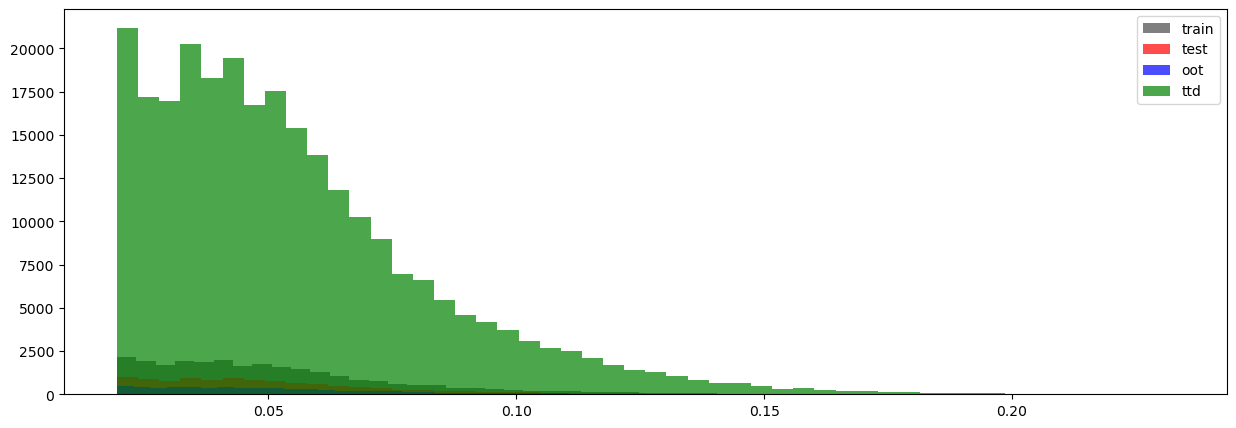

In [107]:
import matplotlib.pyplot as plt
plt.figure(figsize= (15, 5))
plt.hist(Train['p1'], bins= 50, label= 'train', color= 'black', alpha= 0.5)
plt.hist(Test['p1'], bins= 50, label= 'test', color= 'red', alpha= 0.7)
plt.hist(Oot['p1'], bins= 50, label= 'oot', color= 'blue', alpha= 0.7)
plt.hist(TTD['p1'], bins= 50, label= 'ttd', color= 'green', alpha= 0.7)
plt.legend()
plt.show()

In [108]:
Train['p1'].value_counts(dropna= False).head()

p1
0.036045    66
0.050173    60
0.042803    58
0.034675    51
0.020452    48
Name: count, dtype: int64

In [109]:
print(Train['bankruptcystatus'].value_counts(dropna= False))
print(Test['bankruptcystatus'].value_counts(dropna= False))

bankruptcystatus
[0]     24197
[1]      1822
[2]       202
[-1]       19
Name: count, dtype: int64
bankruptcystatus
[0]     10371
[1]       776
[2]        90
[-1]       10
Name: count, dtype: int64


In [110]:
def Bucket_Order(data):
    data['lower_bound'] = data['Bucket'].str.replace('[','').str.replace(']','').str.replace('(','').str.replace(')','').str.split(',').str[0]
    data['lower_bound'] = data['lower_bound'].apply(lambda x: -np.inf if x == '-inf' else np.inf if x == 'inf' else float(x))
    data = data.sort_values('lower_bound')
    a = data.loc[data['lower_bound']==-1]
    b = data.loc[data['lower_bound']!=-1]
    b['Is_Trend']= 'Yes' if (
            (b['Train_BadRate'].is_monotonic_decreasing and b['Test_BadRate'].is_monotonic_decreasing) or
            (b['Train_BadRate'].is_monotonic_increasing and b['Test_BadRate'].is_monotonic_increasing)
        ) else 'No'
    data = pd.concat(objs=[a,b])
    data = data.drop(columns=['lower_bound'])
    return data

In [111]:
df_bv= pd.DataFrame()

for col in col_list:
    print(col)
    ### Train
    temp_tr= Train.groupby(col).agg(
        bad_count_tr= ('bad_flag', 'sum'),
        bad_rate_tr= ('bad_flag', 'mean'),
                                p1_bad_rate_tr= ('p1', 'mean'),
                                   volume_tr= ('unique_id', 'count')).reset_index()
    temp_tr.columns= ['Bucket', 'Train_BadCount', 'Train_BadRate', 'Train_P1', 'Train_Count']
    temp_tr.insert(0, 'variable', col)
    
    # temp_tr= temp_tr.sort_values(by= ['bad_rate_tr']).reset_index(drop= True)
    # temp_tr['bad_rate_rank_tr']= range(1, len(temp_tr)+1)
    # temp_tr= temp_tr.sort_values(by= ['p1_bad_rate_tr']).reset_index(drop= True)
    # temp_tr['p1_bad_rank_tr']= range(1, len(temp_tr)+1)
    
    ### Test
    temp_te= Test.groupby(col).agg(
        bad_count_te= ('bad_flag', 'sum'),
        bad_rate_te= ('bad_flag', 'mean'),
                                p1_bad_rate_te= ('p1', 'mean'),
                                  volume_te= ('unique_id', 'count')).reset_index()
    temp_te.columns= ['Bucket', 'Test_BadCount', 'Test_BadRate', 'Test_P1', 'Test_Count']
    #temp_te['variable']= col
    
    # temp_te= temp_te.sort_values(by= ['bad_rate_te']).reset_index(drop= True)
    # temp_te['bad_rate_rank_te']= range(1, len(temp_te)+1)
    # temp_te= temp_te.sort_values(by= ['p1_bad_rate_te']).reset_index(drop= True)
    # temp_te['p1_bad_rank_te']= range(1, len(temp_te)+1)
    
    ### Concatenating
    temp= temp_tr.merge(temp_te, on= ['Bucket'], how= 'left')
    # temp= temp.sort_values(by= ['bucket']).reset_index(drop= True)
    temp= Bucket_Order(temp)
    # display(temp)
    
    df_bv= pd.concat([df_bv, temp]).reset_index(drop= True)
    
    del temp, temp_tr, temp_te

assetownership
inquiryauto12month
sourcenonderogcount
inquiryshortterm12month
inquirytelcom12month
evictioncount
criminalnonfelonycount
addrinputlengthofres
evictioncount12month
inquirynonshortterm12month
criminalfelonycount
bankruptcystatus
addrpreviouslengthofres
educationattendance
addrcurrenttractratio
educationprogramattended
addrchangecount24month
addrcurrenttimeoldest
criminalnonfelonycount12month
inquirybanking12month
inquirycollections12month
assetpropnewestmortgagetype
addrlastmovetaxratiodiff
bankruptcydismissed24month
addrinputavmratio60monthprior
addrinputdeedmailing
addrchangecount03month
addrinputproblems
derogcount12month
bankruptcychapter
addrchangecount12month
shorttermloanrequest
assetpropevercount
addrinputavmratio12monthprior
alertregulatorycondition
businessassociation
assetproppurchasecount12month
addrinputsubjectowned
addrcurrentdeedmailing
addrchangecount06month
addronfilecollege
assetpropcurrentcount
lienjudgmentothercount
subjectnewestrecord12month
lienjudgme

In [112]:
pd.options.display.max_rows= 1000
df_bv

,variable,Bucket,Train_BadCount,Train_BadRate,Train_P1,Train_Count,Test_BadCount,Test_BadRate,Test_P1,Test_Count,Is_Trend
0,assetownership,[0],1084.0,0.063877,0.063710,16970,454.0,0.062785,0.063295,7231.0,Yes
1,assetownership,[1],248.0,0.026753,0.031410,9270,112.0,0.027888,0.031721,4016.0,Yes
2,inquiryauto12month,[0],812.0,0.041705,0.044207,19470,319.0,0.038452,0.044090,8296.0,Yes
3,inquiryauto12month,[1],520.0,0.076809,0.075570,6770,247.0,0.083700,0.074318,2951.0,Yes
4,sourcenonderogcount,"[-inf, 2.0)",488.0,0.074153,0.069931,6581,200.0,0.070423,0.069674,2840.0,Yes
5,sourcenonderogcount,"[2.0, 3.0)",543.0,0.055357,0.053932,9809,232.0,0.053941,0.052723,4301.0,Yes
6,sourcenonderogcount,"[3.0, 4.0)",233.0,0.038627,0.040409,6032,96.0,0.038156,0.040296,2516.0,Yes
7,sourcenonderogcount,"[4.0, inf)",68.0,0.017810,0.036495,3818,38.0,0.023899,0.037142,1590.0,Yes
8,inquiryshortterm12month,[0],1147.0,0.047603,0.049783,24095,506.0,0.048861,0.049618,10356.0,Yes
9,inquiryshortterm12month,[1],185.0,0.086247,0.080557,2145,60.0,0.067340,0.079948,891.0,Yes


In [113]:
for client in Train['client'].unique():
    print(client)
    get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, 
                  data= Train[Train['client']== client], 
                  data_h2o= train_h2o[train_h2o['client']== client], 
                  target= 'bad_flag', 
                  cols_tuple= col_tuple_pass, 
                  score_col= 'p1', 
                  weight= 'conwt')
    

GESA
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
3554 268.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.080111,0.186886,0.102968,711,632.0,79.0,11.11,20.01,19.23,29.48,10.25
1,0.061413,0.080105,0.069186,711,647.0,64.0,9.00,40.01,38.92,53.36,14.44
2,0.050414,0.061360,0.055667,711,663.0,48.0,6.75,60.02,59.10,71.27,12.17
3,0.038019,0.050372,0.044530,711,658.0,53.0,7.45,80.02,79.12,91.04,11.92
4,0.019663,0.038005,0.029447,710,686.0,24.0,3.38,100.00,100.00,100.00,0.00


{'Gini': 19.509999999999998, 'KS': 14.44}
Arkansas
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
2905 65.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.060594,0.186423,0.083135,582,557.0,25.0,4.30,20.03,19.61,38.46,18.85
1,0.044578,0.060575,0.052012,580,564.0,16.0,2.76,40.00,39.47,63.08,23.61
2,0.035042,0.044577,0.039631,582,571.0,11.0,1.89,60.03,59.58,80.00,20.42
3,0.027199,0.035010,0.031222,581,575.0,6.0,1.03,80.03,79.82,89.23,9.41
4,0.019588,0.027199,0.023162,580,573.0,7.0,1.21,100.00,100.00,100.00,0.00


{'Gini': 28.92, 'KS': 23.61}
CPM
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
1637 60.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.057360,0.145301,0.076507,328,305.0,23.0,7.01,20.04,19.34,38.33,18.99
1,0.041578,0.057238,0.048696,327,312.0,15.0,4.59,40.01,39.12,63.33,24.21
2,0.032695,0.041567,0.036731,328,318.0,10.0,3.05,60.05,59.29,80.00,20.71
3,0.024313,0.032693,0.028325,327,319.0,8.0,2.45,80.02,79.52,93.33,13.81
4,0.019454,0.024285,0.021846,327,323.0,4.0,1.22,100.00,100.00,100.00,0.00


{'Gini': 31.09, 'KS': 24.21}
Guardian
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
6907 236.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.074965,0.214624,0.099974,1382,1286.0,96.0,6.95,20.01,19.28,40.68,21.40
1,0.056591,0.074955,0.064740,1381,1311.0,70.0,5.07,40.00,38.93,70.34,31.41
2,0.043851,0.056586,0.050007,1382,1348.0,34.0,2.46,60.01,59.14,84.75,25.61
3,0.031725,0.043830,0.038060,1381,1359.0,22.0,1.59,80.01,79.51,94.07,14.56
4,0.019454,0.031723,0.025632,1381,1367.0,14.0,1.01,100.00,100.00,100.00,0.00


{'Gini': 37.19, 'KS': 31.41}
SECU
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
3034 223.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.077365,0.208402,0.101904,607,527.0,80.0,13.18,20.01,18.75,35.87,17.12
1,0.057771,0.077365,0.066707,607,542.0,65.0,10.71,40.01,38.03,65.02,26.99
2,0.044603,0.057759,0.051164,607,565.0,42.0,6.92,60.02,58.13,83.86,25.73
3,0.031725,0.044585,0.038239,607,582.0,25.0,4.12,80.03,78.83,95.07,16.24
4,0.019454,0.031714,0.025285,606,595.0,11.0,1.82,100.00,100.00,100.00,0.00


{'Gini': 34.44, 'KS': 26.99}
Numerica
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
3682 167.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.064807,0.213508,0.087697,737,672.0,65.0,8.82,20.02,19.12,38.92,19.80
1,0.050860,0.064807,0.057363,736,705.0,31.0,4.21,40.01,39.17,57.49,18.32
2,0.040088,0.050860,0.045319,737,710.0,27.0,3.66,60.02,59.37,73.65,14.28
3,0.028550,0.040057,0.034502,736,702.0,34.0,4.62,80.01,79.35,94.01,14.66
4,0.019454,0.028516,0.024068,736,726.0,10.0,1.36,100.00,100.00,100.00,0.00


{'Gini': 26.82, 'KS': 19.8}
HFCU
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
400 28.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.060616,0.137014,0.081615,81,74.0,7.0,8.64,20.25,19.89,25.00,5.11
1,0.043795,0.060266,0.050932,79,75.0,4.0,5.06,40.00,40.05,39.29,0.76
2,0.035451,0.043654,0.039171,81,77.0,4.0,4.94,60.25,60.75,53.57,7.18
3,0.028290,0.035438,0.032131,80,72.0,8.0,10.00,80.25,80.11,82.14,2.03
4,0.019799,0.027722,0.022877,79,74.0,5.0,6.33,100.00,100.00,100.00,0.00


{'Gini': -0.33999999999999997, 'KS': 7.18}
Tower
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
2999 259.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.062852,0.168524,0.085188,600,480.0,120.0,20.00,20.01,17.52,46.33,28.81
1,0.048919,0.062849,0.054945,600,549.0,51.0,8.50,40.01,37.55,66.02,28.47
2,0.038194,0.048873,0.043172,600,559.0,41.0,6.83,60.02,57.96,81.85,23.89
3,0.028554,0.038193,0.033610,600,570.0,30.0,5.00,80.03,78.76,93.44,14.68
4,0.019454,0.028542,0.023689,599,582.0,17.0,2.84,100.00,100.00,100.00,0.00


{'Gini': 38.35, 'KS': 28.81}
Bethpage
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
642 12.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.058286,0.118140,0.073584,129,126.0,3.0,2.33,20.09,20.00,25.00,5.00
1,0.044416,0.058286,0.050594,128,123.0,5.0,3.91,40.03,39.52,66.67,27.15
2,0.036045,0.044390,0.039935,129,128.0,1.0,0.78,60.12,59.84,75.00,15.16
3,0.030618,0.036045,0.033736,128,125.0,3.0,2.34,80.06,79.68,100.00,20.32
4,0.019588,0.030591,0.023813,128,128.0,0.0,0.00,100.00,100.00,100.00,0.00


{'Gini': 27.04, 'KS': 27.15}
NCU
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
242 12.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.065547,0.141890,0.086357,49,45.0,4.0,8.16,20.25,19.57,33.33,13.76
1,0.048547,0.063527,0.055011,48,46.0,2.0,4.17,40.08,39.57,50.00,10.43
2,0.038177,0.048441,0.043509,49,45.0,4.0,8.16,60.33,59.13,83.33,24.20
3,0.028195,0.037942,0.033623,48,46.0,2.0,4.17,80.17,79.13,100.00,20.87
4,0.019815,0.027982,0.023809,48,48.0,0.0,0.00,100.00,100.00,100.00,0.00


{'Gini': 27.67, 'KS': 24.2}
Hawaii
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
238 2.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.062002,0.146962,0.082750,48,47.0,1.0,2.08,20.17,19.92,50.0,30.08
1,0.053435,0.062002,0.057494,48,47.0,1.0,2.08,40.34,39.83,100.0,60.17
2,0.046157,0.053385,0.049737,47,47.0,0.0,0.00,60.08,59.75,100.0,40.25
3,0.036045,0.046023,0.041806,48,48.0,0.0,0.00,80.25,80.08,100.0,19.92
4,0.019815,0.035857,0.028297,47,47.0,0.0,0.00,100.00,100.00,100.0,0.00


{'Gini': 60.17, 'KS': 60.17}


### Basic Checks

In [114]:
TTD['funded_flag'].sum(), Train['funded_flag'].sum(), Test['funded_flag'].sum()

(35158.0, 26240.0, 11247.0)

In [115]:
TTD['id']= TTD['unique_id']+TTD['client']
Train['id']= Train['unique_id']+Train['client']
Test['id']= Test['unique_id']+Test['client']
Oot['id']= Oot['unique_id']+Oot['client']

In [116]:
Train[(Train['id'].isin(TTD['id'].unique())) & (Train['client']!= 'CPM')].shape, Train[Train['client']!='CPM'].shape

((24603, 147), (24603, 147))

In [117]:
Test[(Test['id'].isin(TTD['id'].unique())) & (Test['client']!= 'CPM')].shape, Test[Test['client']!='CPM'].shape

((10555, 147), (10555, 147))

In [118]:
Train[(Train['id'].isin(Test['id'].unique()))].shape

(0, 147)

In [119]:
TTD[TTD['id'].isin(Train[Train['client']!= 'CPM']['id'].unique())]['p1'].describe(), Train[Train['client']!= 'CPM']['p1'].describe()

(count    24603.000000
 mean         0.052955
 std          0.026239
 min          0.019454
 25%          0.033598
 50%          0.047582
 75%          0.065157
 max          0.214624
 Name: p1, dtype: float64,
 count    24603.000000
 mean         0.052955
 std          0.026239
 min          0.019454
 25%          0.033598
 50%          0.047582
 75%          0.065157
 max          0.214624
 Name: p1, dtype: float64)

In [120]:
Train['client'].value_counts(dropna= False)

client
Guardian    6907
Numerica    3682
GESA        3554
SECU        3034
Tower       2999
Arkansas    2905
CPM         1637
Bethpage     642
HFCU         400
NCU          242
Hawaii       238
Name: count, dtype: int64

In [121]:
import datetime
Train[col_tuple_pass + ['p1']].to_csv(f'{path_to_save}{pref}_Train_Auto_LN_V2_Scored_Data_{str(datetime.datetime.today().date())}.csv', index= False)
Test[col_tuple_pass + ['p1']].to_csv(f'{path_to_save}{pref}_Test_Auto_LN_V2_Scored_Data_{str(datetime.datetime.today().date())}.csv', index= False)
Oot[col_tuple_pass + ['p1']].to_csv(f'{path_to_save}{pref}_Oot_Auto_LN_V2_Scored_Data_{str(datetime.datetime.today().date())}.csv', index= False)
TTD[col_tuple_pass + ['p1']].to_csv(f'{path_to_save}{pref}_TTD_Auto_LN_V2_Scored_Data_{str(datetime.datetime.today().date())}.csv', index= False)